In [2]:
import pandas as pd
import numpy as np
import helper
import missingno as msno
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import catboost as cb
import seaborn as sns

from mlxtend.regressor import StackingCVRegressor


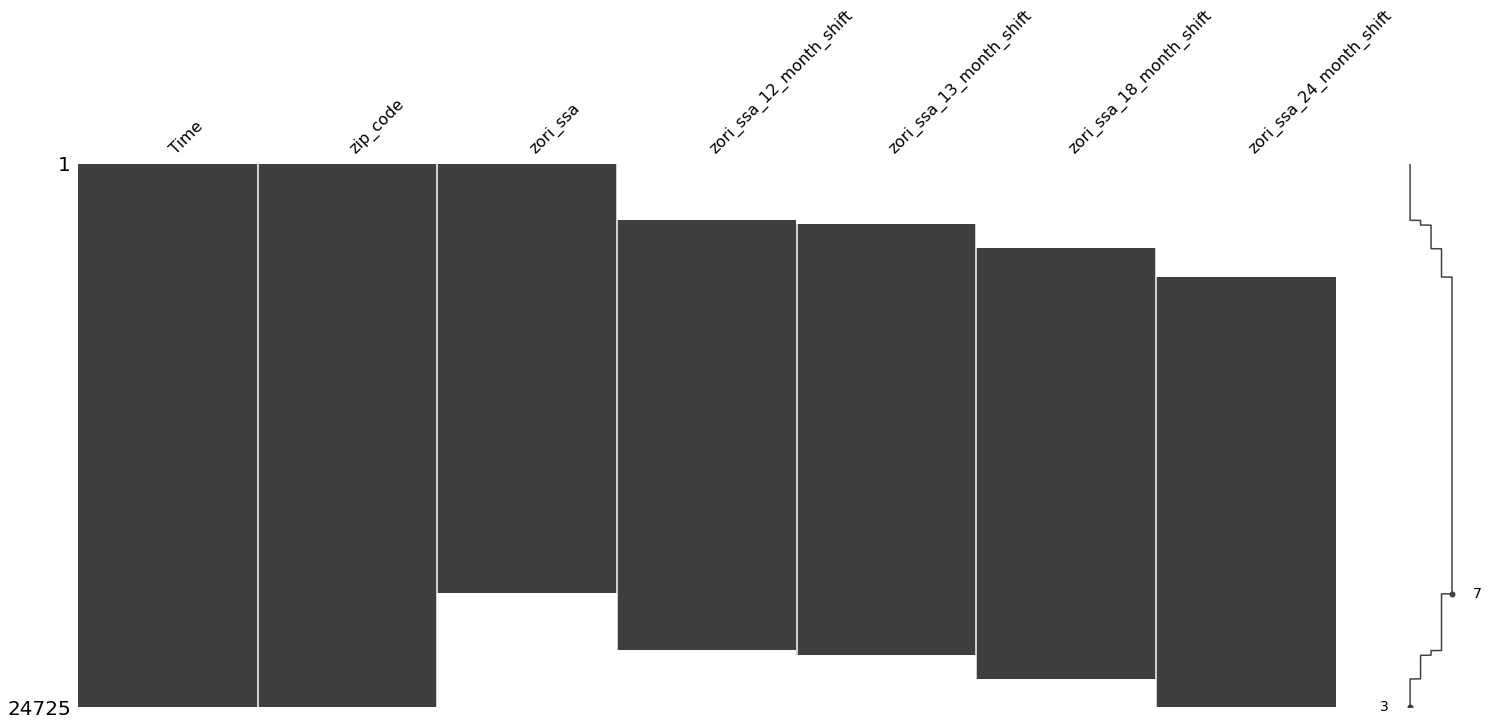

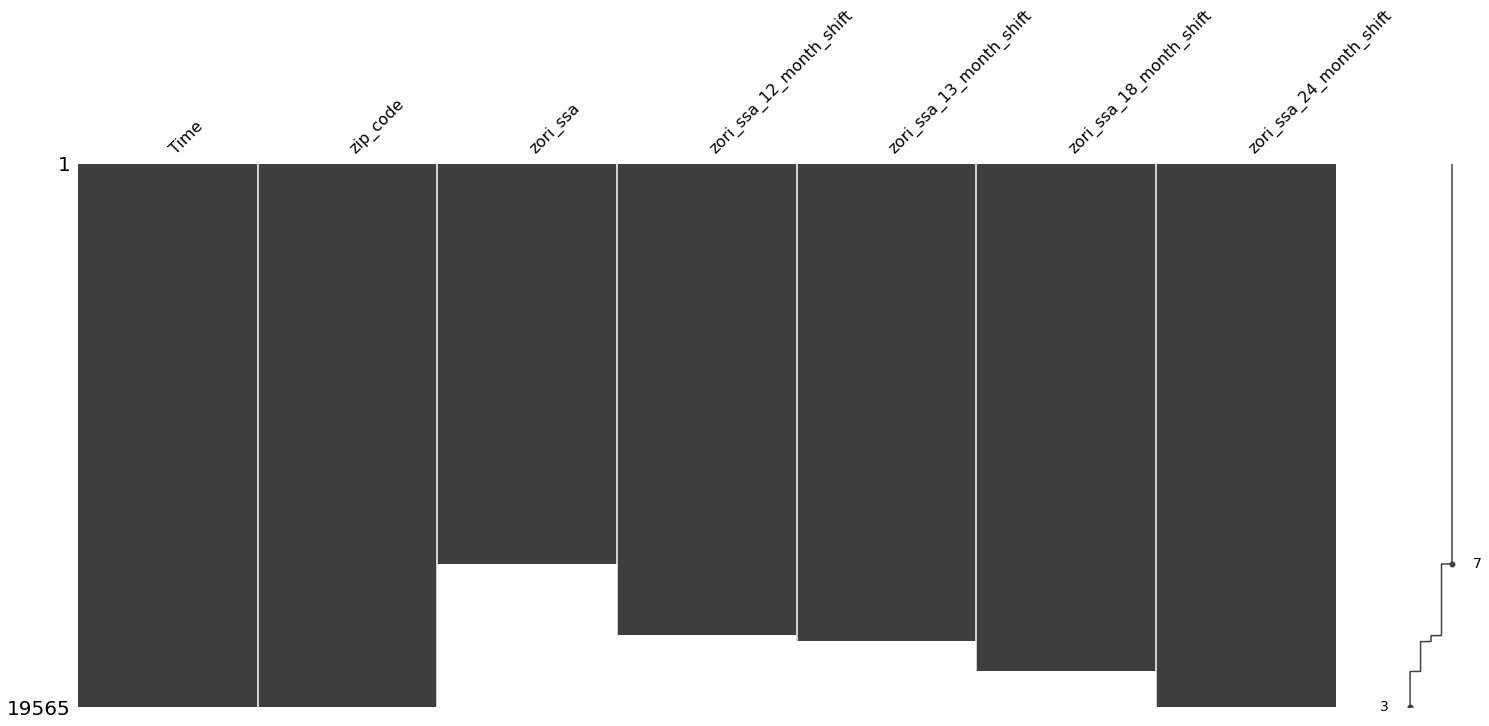

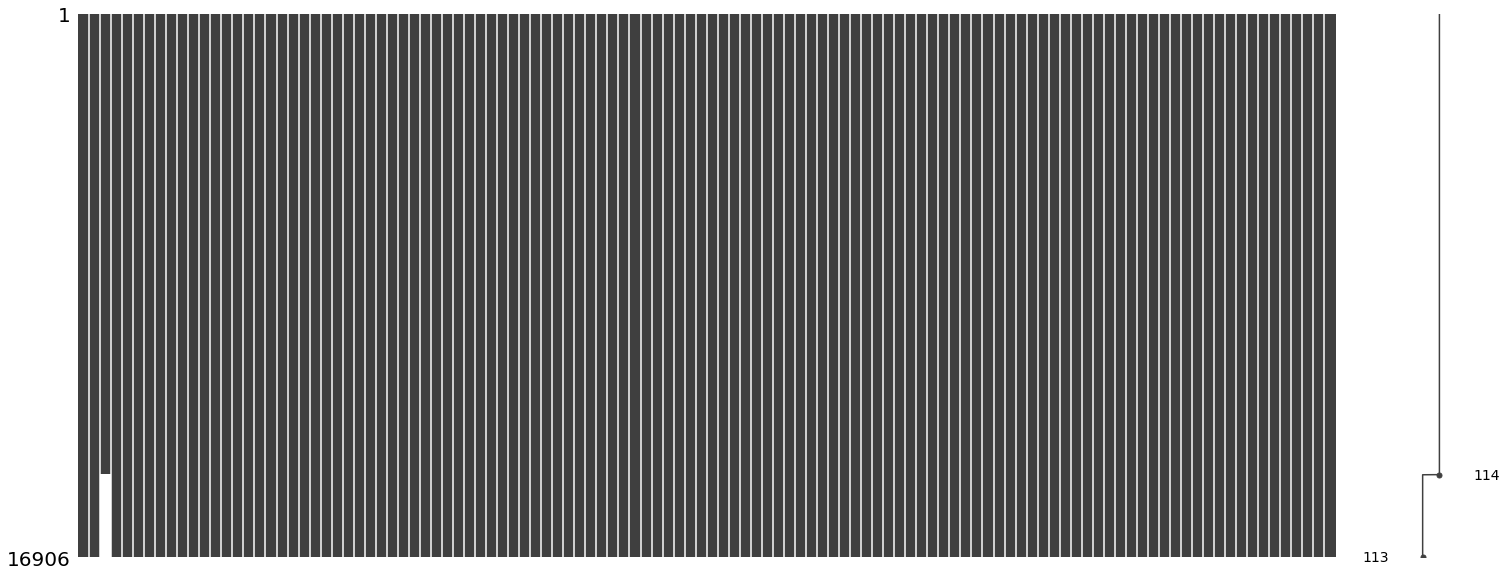

In [3]:
# load data
texas_data = pd.read_csv('cleaned_data/merged_texas_data.csv', index_col = 0,
                   parse_dates = ['Time']
                  )

acs_data = pd.read_csv('cleaned_data/merged_acs_data.csv', index_col = 0,
                      parse_dates = ['Time'])

zri = pd.read_csv('cleaned_data/long_interpolated_target.csv', index_col = 0,
                   parse_dates=['Time']
                  )

# adding shift to zri
zri_shift = helper.time_lag_merge(zri, zri, {
    12:['zori_ssa'],
    13:['zori_ssa'],
    18:['zori_ssa'],
    24:['zori_ssa']
},
                                          return_full = True
                                         )

# there should now be extra values after our target. 
# We are gonna remove the missing values that happen at the start of our inputs tho
zri_shift = zri_shift.sort_values('Time')
msno.matrix(zri_shift)
plt.show()
zri_shift = zri_shift.dropna(subset = ['zori_ssa_24_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)
msno.matrix(zri_shift)
plt.show()
# Adding the shift values
zri_shift.loc[:,'zori_ssa_1_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_13_month_shift'])
zri_shift.loc[:,'zori_ssa_6_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_18_month_shift'])
zri_shift.loc[:,'zori_ssa_12_diff_lag_12'] = (zri_shift.loc[:,'zori_ssa_12_month_shift'] -
                                             zri_shift.loc[:,'zori_ssa_24_month_shift'])
zri_shift['zori_ssa_12_diff_lag_12_per'] = (zri_shift['zori_ssa_12_diff_lag_12']/
                                           zri_shift['zori_ssa_12_month_shift'])

zri_shift = zri_shift[['Time','zip_code','zori_ssa', 
                       'zori_ssa_12_month_shift',
                       'zori_ssa_1_diff_lag_12', 
                       'zori_ssa_6_diff_lag_12',
                       'zori_ssa_12_diff_lag_12_per'
                      ]]


# merge non acs data 
extra_shift = ['Gross Value Natural Gas Production', 'sap_case_shiller_index']
merged_df = helper.time_lag_merge(zri_shift, 
                                                    texas_data, {
    12:list(texas_data.drop(columns = ['Time','zip_code']+extra_shift
                            ).columns),
    13:extra_shift
},
                                          return_full = True
                                         )
# merge acs data
acs_1_cols = [
    'black_pop',
    'white_pop',
    'hispanic_pop',
    'high_school_diploma',
    'female_female_households',
    'armed_forces',
    'children',
    'black_pop_annual_pct_change',
    'white_pop_annual_pct_change',
    'hispanic_pop_annual_pct_change',
    'high_school_diploma_annual_pct_change',
    'children_annual_pct_change',
    ]
merged_df = helper.time_lag_merge(merged_df, 
                                                    acs_data, {
    36:list(acs_data.drop(columns = ['Time','zip_code'] + acs_1_cols).columns),
    48:acs_1_cols                                              
},
                                          return_full = True
                                         )
# # visualize missing values. it should be that acs 2 does not have a single zipcode
# # then removing that line and checking to see that there are no more missing values.
merged_df = merged_df.loc[merged_df['Time']>datetime.datetime(2016,6,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.loc[merged_df['Time']<datetime.datetime(2022,7,2),:
                          ].reset_index(drop=True)
merged_df = merged_df.sort_values('Time')
merged_df = merged_df.dropna(subset = ['single_women_36_month_shift'],axis='index',
                             how = 'any').reset_index(drop = True)

# this now should have no missing values except for the last year when 
# we are doing a forecast
msno.matrix(merged_df)
plt.show()


# creating list of variables to put into the model. initialy is all non index and target
X_vals = [
    'zori_ssa_12_month_shift',
    'zori_ssa_1_diff_lag_12',
    'zori_ssa_6_diff_lag_12',
    'total_sales_tax_12_month_shift',
    'housing_units_over_50_units_36_month_shift',
    'housing_units_built_1960_to_1969_36_month_shift',
    'black_pop_48_month_shift',
    'zori_ssa_12_diff_lag_12_per',
    'children_annual_pct_change_48_month_shift',
    'female_40_to_44_annual_pct_change_36_month_shift',
    'housing_units_10_to_19_units_annual_pct_change_36_month_shift',
    'sales_tax_rate_annual_pct_change_12_month_shift',
    'female_female_households_48_month_shift',
    'women_with_associate_degree_annual_pct_change_36_month_shift',
    'average_household_size_owners_annual_pct_change_36_month_shift',
    'units_paying_cash_rent_annual_pct_change_36_month_shift',
    'quintile_1_upper_limit_annual_pct_change_36_month_shift',
    'Gross Value Natural Gas Production_13_month_shift',
    'women_with_doctoral_degree_annual_pct_change_36_month_shift',
    'total_sales_tax_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_36_month_shift',
    'housing_units_built_1980_to_1989_annual_pct_change_36_month_shift',
    'female_35_to_39_annual_pct_change_36_month_shift',
    'bicycle_population_36_month_shift',
    'housing_units_20_to_49_units_annual_pct_change_36_month_shift',
    'taxpayer_count_12_month_shift',
    'housing_units_5_to_9_units_36_month_shift',
    'high_school_diploma_annual_pct_change_48_month_shift',
    'driving_alone_population_annual_pct_change_36_month_shift',
    'taxpayer_is_ratio_12_month_shift',
    'motorcycle_population_36_month_shift',
    'housing_units_built_1960_to_1969_annual_pct_change_36_month_shift',
    'housing_units_single_family_attached_annual_pct_change_36_month_shift',
    'white_pop_annual_pct_change_48_month_shift',
    'taxpayer_cl_ratio_annual_pct_change_12_month_shift',
    'taxpayer_is_ratio_annual_pct_change_12_month_shift',
    'housing_units_built_1940_to_1949_annual_pct_change_36_month_shift',
    'housing_units_5_to_9_units_annual_pct_change_36_month_shift',
    'median_household_income_annual_pct_change_36_month_shift',
    'black_pop_annual_pct_change_48_month_shift',
    'Gross Value Natural Gas Production_annual_pct_change_12_month_shift',
    'housing_units_single_family_attached_owned_36_month_shift',
    'single_women_annual_pct_change_36_month_shift',
    'housing_units_built_1930_to_1939_36_month_shift',
    'housing_units_built_1930_to_1939_annual_pct_change_36_month_shift',
    'female_25_to_29_annual_pct_change_36_month_shift',
    'female_30_to_34_annual_pct_change_36_month_shift',
    'housing_units_over_50_units_annual_pct_change_36_month_shift',
]
# then remove variables that don't work for that given model.
bad_X_vals = [
    # features that you don't like that you can remove

             ]
X_vals = [X_val for X_val in X_vals if X_val not in bad_X_vals]
y_val = 'zori_ssa'

# split train and test based on a year in advance.
train = merged_df.loc[merged_df['Time']<datetime.datetime(2020,7,2),:].reset_index(drop=True)
post_train = merged_df.loc[merged_df['Time']>datetime.datetime(2020,7,2),:].reset_index(drop=True)
test = post_train.loc[post_train['Time']<datetime.datetime(2021,7,2),:].reset_index(drop=True)
forecast = post_train.loc[post_train['Time']>datetime.datetime(2021,7,2),:].reset_index(drop=True)

# set up x and y values with a scaler
# train first
scaler = StandardScaler(with_mean=False)
X = train[X_vals]
X = scaler.fit_transform(X)
y = train[y_val]
# test second
X_test = test[X_vals]
X_test = scaler.transform(X_test)
y_test = test[y_val]
# forecasted values
X_forecast = forecast[X_vals]
X_forecast = scaler.transform(X_forecast)


In [4]:
### Run Catboost - For ensembling

train_dataset = cb.Pool(X, y)
test_dataset = cb.Pool(X_test, y_test)
model = cb.CatBoostRegressor(loss_function='RMSE', verbose=None)
grid = {'iterations': [150, 200, 250], 
       'learning_rate': [0.03, 0.05, 0.3, 0.5], 
       'depth': [4,6,8], 
       'l2_leaf_reg': [0.5, 0.75, 1]}

model.grid_search(grid, train_dataset)

0:	learn: 1338.7600728	test: 1341.9040775	best: 1341.9040775 (0)	total: 55.1ms	remaining: 8.21s
1:	learn: 1299.3746806	test: 1302.4026817	best: 1302.4026817 (1)	total: 59.6ms	remaining: 4.41s
2:	learn: 1260.9901754	test: 1264.1646084	best: 1264.1646084 (2)	total: 72.6ms	remaining: 3.56s
3:	learn: 1224.3929311	test: 1227.5747738	best: 1227.5747738 (3)	total: 91.2ms	remaining: 3.33s
4:	learn: 1188.9215081	test: 1192.0422885	best: 1192.0422885 (4)	total: 97.7ms	remaining: 2.83s
5:	learn: 1154.5657204	test: 1157.7282002	best: 1157.7282002 (5)	total: 102ms	remaining: 2.45s
6:	learn: 1121.3067240	test: 1124.4655471	best: 1124.4655471 (6)	total: 105ms	remaining: 2.15s
7:	learn: 1089.0474663	test: 1092.2083781	best: 1092.2083781 (7)	total: 109ms	remaining: 1.94s
8:	learn: 1057.1326938	test: 1060.3359430	best: 1060.3359430 (8)	total: 111ms	remaining: 1.74s
9:	learn: 1025.8805136	test: 1029.1089371	best: 1029.1089371 (9)	total: 117ms	remaining: 1.64s
10:	learn: 995.8290367	test: 999.0981553	best

111:	learn: 63.4170289	test: 63.7944283	best: 63.7944283 (111)	total: 442ms	remaining: 150ms
112:	learn: 61.9741540	test: 62.3490135	best: 62.3490135 (112)	total: 447ms	remaining: 146ms
113:	learn: 60.6372095	test: 61.0305429	best: 61.0305429 (113)	total: 450ms	remaining: 142ms
114:	learn: 59.4003277	test: 59.8022386	best: 59.8022386 (114)	total: 453ms	remaining: 138ms
115:	learn: 58.1910092	test: 58.5910027	best: 58.5910027 (115)	total: 458ms	remaining: 134ms
116:	learn: 57.0245959	test: 57.4164153	best: 57.4164153 (116)	total: 462ms	remaining: 130ms
117:	learn: 55.7868127	test: 56.1836325	best: 56.1836325 (117)	total: 468ms	remaining: 127ms
118:	learn: 54.6115770	test: 55.0027988	best: 55.0027988 (118)	total: 473ms	remaining: 123ms
119:	learn: 53.5147767	test: 53.9237462	best: 53.9237462 (119)	total: 478ms	remaining: 120ms
120:	learn: 52.4429937	test: 52.8604341	best: 52.8604341 (120)	total: 482ms	remaining: 116ms
121:	learn: 51.4520083	test: 51.8792047	best: 51.8792047 (121)	total: 

58:	learn: 86.1417540	test: 87.2951233	best: 87.2951233 (58)	total: 215ms	remaining: 331ms
59:	learn: 82.6248499	test: 83.8329939	best: 83.8329939 (59)	total: 219ms	remaining: 328ms
60:	learn: 79.4659067	test: 80.6471692	best: 80.6471692 (60)	total: 223ms	remaining: 326ms
61:	learn: 76.3432773	test: 77.5402562	best: 77.5402562 (61)	total: 227ms	remaining: 322ms
62:	learn: 73.4353257	test: 74.6441297	best: 74.6441297 (62)	total: 230ms	remaining: 318ms
63:	learn: 70.6711416	test: 71.8565377	best: 71.8565377 (63)	total: 235ms	remaining: 316ms
64:	learn: 67.9942087	test: 69.1519902	best: 69.1519902 (64)	total: 239ms	remaining: 313ms
65:	learn: 65.4365685	test: 66.5784528	best: 66.5784528 (65)	total: 243ms	remaining: 309ms
66:	learn: 63.1726270	test: 64.3463571	best: 64.3463571 (66)	total: 248ms	remaining: 307ms
67:	learn: 61.0253652	test: 62.1571378	best: 62.1571378 (67)	total: 251ms	remaining: 303ms
68:	learn: 59.1092527	test: 60.2232062	best: 60.2232062 (68)	total: 255ms	remaining: 300ms

35:	learn: 26.8299574	test: 28.1887527	best: 28.1887527 (35)	total: 109ms	remaining: 344ms
36:	learn: 26.5773350	test: 27.8402660	best: 27.8402660 (36)	total: 113ms	remaining: 345ms
37:	learn: 26.1170008	test: 27.4505565	best: 27.4505565 (37)	total: 118ms	remaining: 346ms
38:	learn: 25.8015520	test: 27.1500559	best: 27.1500559 (38)	total: 121ms	remaining: 344ms
39:	learn: 25.5201170	test: 26.7760436	best: 26.7760436 (39)	total: 125ms	remaining: 343ms
40:	learn: 25.0108027	test: 26.4190847	best: 26.4190847 (40)	total: 128ms	remaining: 341ms
41:	learn: 24.7901705	test: 26.1738086	best: 26.1738086 (41)	total: 133ms	remaining: 342ms
42:	learn: 24.5763276	test: 25.9602223	best: 25.9602223 (42)	total: 135ms	remaining: 337ms
43:	learn: 24.4025576	test: 25.8106109	best: 25.8106109 (43)	total: 138ms	remaining: 332ms
44:	learn: 24.2182750	test: 25.6418159	best: 25.6418159 (44)	total: 140ms	remaining: 327ms
45:	learn: 23.9646431	test: 25.3494966	best: 25.3494966 (45)	total: 146ms	remaining: 331ms

4:	learn: 83.3238627	test: 83.7473620	best: 83.7473620 (4)	total: 17.5ms	remaining: 509ms
5:	learn: 65.6285643	test: 66.3440905	best: 66.3440905 (5)	total: 22.1ms	remaining: 531ms
6:	learn: 56.9025687	test: 57.5275622	best: 57.5275622 (6)	total: 26ms	remaining: 532ms
7:	learn: 48.4101292	test: 48.7691155	best: 48.7691155 (7)	total: 30.3ms	remaining: 538ms
8:	learn: 45.4879059	test: 45.7852790	best: 45.7852790 (8)	total: 34.6ms	remaining: 543ms
9:	learn: 42.7459021	test: 43.1928315	best: 43.1928315 (9)	total: 38.3ms	remaining: 537ms
10:	learn: 40.3482758	test: 41.0641409	best: 41.0641409 (10)	total: 42.7ms	remaining: 539ms
11:	learn: 39.2676553	test: 40.0187775	best: 40.0187775 (11)	total: 47.4ms	remaining: 545ms
12:	learn: 38.4961526	test: 39.3131824	best: 39.3131824 (12)	total: 50.4ms	remaining: 531ms
13:	learn: 36.3264311	test: 37.2818305	best: 37.2818305 (13)	total: 52.7ms	remaining: 512ms
14:	learn: 35.3334614	test: 36.3178181	best: 36.3178181 (14)	total: 55.2ms	remaining: 497ms
15

96:	learn: 14.8250810	test: 16.8207212	best: 16.8207212 (96)	total: 404ms	remaining: 221ms
97:	learn: 14.7262536	test: 16.7498092	best: 16.7498092 (97)	total: 408ms	remaining: 216ms
98:	learn: 14.6581339	test: 16.7351967	best: 16.7351967 (98)	total: 412ms	remaining: 212ms
99:	learn: 14.5958069	test: 16.6659196	best: 16.6659196 (99)	total: 415ms	remaining: 208ms
100:	learn: 14.5356074	test: 16.6265194	best: 16.6265194 (100)	total: 419ms	remaining: 203ms
101:	learn: 14.4649389	test: 16.5633046	best: 16.5633046 (101)	total: 425ms	remaining: 200ms
102:	learn: 14.4075354	test: 16.5430839	best: 16.5430839 (102)	total: 427ms	remaining: 195ms
103:	learn: 14.3429465	test: 16.5308753	best: 16.5308753 (103)	total: 431ms	remaining: 190ms
104:	learn: 14.2736337	test: 16.4319922	best: 16.4319922 (104)	total: 433ms	remaining: 186ms
105:	learn: 14.2264410	test: 16.3927161	best: 16.3927161 (105)	total: 435ms	remaining: 181ms
106:	learn: 14.1606016	test: 16.3456660	best: 16.3456660 (106)	total: 438ms	re

43:	learn: 384.5121359	test: 386.1513504	best: 386.1513504 (43)	total: 191ms	remaining: 460ms
44:	learn: 373.5291424	test: 375.1474474	best: 375.1474474 (44)	total: 196ms	remaining: 457ms
45:	learn: 363.0155684	test: 364.6276280	best: 364.6276280 (45)	total: 200ms	remaining: 453ms
46:	learn: 352.6960877	test: 354.2430338	best: 354.2430338 (46)	total: 205ms	remaining: 449ms
47:	learn: 342.7295042	test: 344.2137218	best: 344.2137218 (47)	total: 209ms	remaining: 443ms
48:	learn: 332.9899249	test: 334.4202406	best: 334.4202406 (48)	total: 213ms	remaining: 438ms
49:	learn: 324.0457215	test: 325.4808383	best: 325.4808383 (49)	total: 219ms	remaining: 439ms
50:	learn: 314.8523403	test: 316.2890864	best: 316.2890864 (50)	total: 226ms	remaining: 438ms
51:	learn: 306.0803533	test: 307.4567110	best: 307.4567110 (51)	total: 228ms	remaining: 430ms
52:	learn: 297.5547624	test: 298.8721876	best: 298.8721876 (52)	total: 231ms	remaining: 422ms
53:	learn: 289.2763838	test: 290.6131363	best: 290.6131363 (

9:	learn: 840.4888018	test: 843.7350383	best: 843.7350383 (9)	total: 28.8ms	remaining: 403ms
10:	learn: 799.8454178	test: 802.7862479	best: 802.7862479 (10)	total: 32.3ms	remaining: 408ms
11:	learn: 762.2634834	test: 765.2652262	best: 765.2652262 (11)	total: 36.1ms	remaining: 415ms
12:	learn: 725.6685178	test: 728.8507524	best: 728.8507524 (12)	total: 40.4ms	remaining: 426ms
13:	learn: 690.9055333	test: 693.7806429	best: 693.7806429 (13)	total: 44.4ms	remaining: 432ms
14:	learn: 657.8623135	test: 660.5982326	best: 660.5982326 (14)	total: 48.7ms	remaining: 438ms
15:	learn: 626.4261822	test: 629.0070733	best: 629.0070733 (15)	total: 52.9ms	remaining: 443ms
16:	learn: 596.6754804	test: 599.0352659	best: 599.0352659 (16)	total: 55.4ms	remaining: 434ms
17:	learn: 569.5874257	test: 571.8648515	best: 571.8648515 (17)	total: 57.9ms	remaining: 424ms
18:	learn: 542.6646408	test: 545.0107409	best: 545.0107409 (18)	total: 62ms	remaining: 427ms
19:	learn: 517.1246807	test: 519.3709723	best: 519.370

126:	learn: 25.7356809	test: 26.5977250	best: 26.5977250 (126)	total: 413ms	remaining: 74.7ms
127:	learn: 25.6444388	test: 26.5163670	best: 26.5163670 (127)	total: 416ms	remaining: 71.5ms
128:	learn: 25.5583111	test: 26.4351933	best: 26.4351933 (128)	total: 420ms	remaining: 68.4ms
129:	learn: 25.4672432	test: 26.3514699	best: 26.3514699 (129)	total: 424ms	remaining: 65.2ms
130:	learn: 25.4038094	test: 26.2706178	best: 26.2706178 (130)	total: 428ms	remaining: 62ms
131:	learn: 25.3006180	test: 26.1711020	best: 26.1711020 (131)	total: 432ms	remaining: 59ms
132:	learn: 25.2267872	test: 26.0702779	best: 26.0702779 (132)	total: 437ms	remaining: 55.9ms
133:	learn: 25.1410992	test: 25.9867283	best: 25.9867283 (133)	total: 441ms	remaining: 52.6ms
134:	learn: 25.0615500	test: 25.9119332	best: 25.9119332 (134)	total: 445ms	remaining: 49.4ms
135:	learn: 24.9647812	test: 25.8028456	best: 25.8028456 (135)	total: 447ms	remaining: 46ms
136:	learn: 24.8877082	test: 25.7061208	best: 25.7061208 (136)	tot

105:	learn: 16.7794584	test: 18.7264347	best: 18.7264347 (105)	total: 310ms	remaining: 129ms
106:	learn: 16.7074009	test: 18.6733594	best: 18.6733594 (106)	total: 314ms	remaining: 126ms
107:	learn: 16.6219860	test: 18.5755165	best: 18.5755165 (107)	total: 320ms	remaining: 125ms
108:	learn: 16.5718734	test: 18.5091072	best: 18.5091072 (108)	total: 325ms	remaining: 122ms
109:	learn: 16.5053436	test: 18.4234733	best: 18.4234733 (109)	total: 329ms	remaining: 120ms
110:	learn: 16.4497980	test: 18.3902273	best: 18.3902273 (110)	total: 333ms	remaining: 117ms
111:	learn: 16.3873890	test: 18.3261589	best: 18.3261589 (111)	total: 338ms	remaining: 115ms
112:	learn: 16.3217952	test: 18.2736550	best: 18.2736550 (112)	total: 342ms	remaining: 112ms
113:	learn: 16.2613583	test: 18.2114162	best: 18.2114162 (113)	total: 345ms	remaining: 109ms
114:	learn: 16.1986511	test: 18.1404755	best: 18.1404755 (114)	total: 347ms	remaining: 106ms
115:	learn: 16.1432592	test: 18.1105195	best: 18.1105195 (115)	total: 

59:	learn: 18.9282124	test: 20.5287190	best: 20.5287190 (59)	total: 212ms	remaining: 318ms
60:	learn: 18.8566467	test: 20.4742470	best: 20.4742470 (60)	total: 218ms	remaining: 318ms
61:	learn: 18.7588060	test: 20.3817370	best: 20.3817370 (61)	total: 223ms	remaining: 316ms
62:	learn: 18.6294382	test: 20.2882969	best: 20.2882969 (62)	total: 226ms	remaining: 313ms
63:	learn: 18.4986483	test: 20.1335813	best: 20.1335813 (63)	total: 231ms	remaining: 311ms
64:	learn: 18.4043440	test: 20.0075533	best: 20.0075533 (64)	total: 237ms	remaining: 310ms
65:	learn: 18.2712645	test: 19.8822028	best: 19.8822028 (65)	total: 240ms	remaining: 305ms
66:	learn: 18.1763268	test: 19.8065156	best: 19.8065156 (66)	total: 245ms	remaining: 304ms
67:	learn: 17.8374424	test: 19.5267070	best: 19.5267070 (67)	total: 249ms	remaining: 300ms
68:	learn: 17.7420245	test: 19.4705950	best: 19.4705950 (68)	total: 253ms	remaining: 297ms
69:	learn: 17.6438913	test: 19.4097774	best: 19.4097774 (69)	total: 255ms	remaining: 292ms

19:	learn: 765.9442502	test: 768.6761348	best: 768.6761348 (19)	total: 66.4ms	remaining: 432ms
20:	learn: 743.7451076	test: 746.3593256	best: 746.3593256 (20)	total: 70.6ms	remaining: 433ms
21:	learn: 722.2850633	test: 724.7771789	best: 724.7771789 (21)	total: 75ms	remaining: 436ms
22:	learn: 701.5864177	test: 704.1058811	best: 704.1058811 (22)	total: 78.9ms	remaining: 436ms
23:	learn: 681.3653822	test: 683.8665775	best: 683.8665775 (23)	total: 83.3ms	remaining: 438ms
24:	learn: 662.4865492	test: 664.9484995	best: 664.9484995 (24)	total: 87.3ms	remaining: 436ms
25:	learn: 644.1796740	test: 646.7446271	best: 646.7446271 (25)	total: 92ms	remaining: 439ms
26:	learn: 625.2894880	test: 627.8053168	best: 627.8053168 (26)	total: 94.6ms	remaining: 431ms
27:	learn: 607.4528810	test: 609.8243486	best: 609.8243486 (27)	total: 96.7ms	remaining: 422ms
28:	learn: 590.1470620	test: 592.5669898	best: 592.5669898 (28)	total: 99.5ms	remaining: 415ms
29:	learn: 573.3091692	test: 575.7214663	best: 575.721

147:	learn: 34.4132199	test: 34.8872190	best: 34.8872190 (147)	total: 449ms	remaining: 6.06ms
148:	learn: 34.0253320	test: 34.4992024	best: 34.4992024 (148)	total: 454ms	remaining: 3.05ms
149:	learn: 33.6629287	test: 34.1416424	best: 34.1416424 (149)	total: 458ms	remaining: 0us

bestTest = 34.14164239
bestIteration = 149

8:	loss: 34.1416424	best: 14.5798283 (7)	total: 4.98s	remaining: 54.7s
0:	learn: 1312.0568111	test: 1315.1918810	best: 1315.1918810 (0)	total: 5.32ms	remaining: 793ms
1:	learn: 1247.8527742	test: 1250.8045545	best: 1250.8045545 (1)	total: 9.41ms	remaining: 697ms
2:	learn: 1186.5253337	test: 1189.7202586	best: 1189.7202586 (2)	total: 13.1ms	remaining: 644ms
3:	learn: 1129.3651627	test: 1132.5683646	best: 1132.5683646 (3)	total: 17.6ms	remaining: 642ms
4:	learn: 1075.1391840	test: 1078.2431385	best: 1078.2431385 (4)	total: 20.4ms	remaining: 592ms
5:	learn: 1023.7574823	test: 1026.9279524	best: 1026.9279524 (5)	total: 27.8ms	remaining: 668ms
6:	learn: 975.0877007	test: 9

108:	learn: 27.7995190	test: 28.5644872	best: 28.5644872 (108)	total: 377ms	remaining: 142ms
109:	learn: 27.6312773	test: 28.3896339	best: 28.3896339 (109)	total: 382ms	remaining: 139ms
110:	learn: 27.4682205	test: 28.2271092	best: 28.2271092 (110)	total: 385ms	remaining: 135ms
111:	learn: 27.3155725	test: 28.0670570	best: 28.0670570 (111)	total: 390ms	remaining: 132ms
112:	learn: 27.1648998	test: 27.9011856	best: 27.9011856 (112)	total: 394ms	remaining: 129ms
113:	learn: 27.0309495	test: 27.7735471	best: 27.7735471 (113)	total: 399ms	remaining: 126ms
114:	learn: 26.8801937	test: 27.6238529	best: 27.6238529 (114)	total: 403ms	remaining: 123ms
115:	learn: 26.7296593	test: 27.4509750	best: 27.4509750 (115)	total: 409ms	remaining: 120ms
116:	learn: 26.5945596	test: 27.3016224	best: 27.3016224 (116)	total: 414ms	remaining: 117ms
117:	learn: 26.4684381	test: 27.1713441	best: 27.1713441 (117)	total: 418ms	remaining: 113ms
118:	learn: 26.3456822	test: 27.0529232	best: 27.0529232 (118)	total: 

81:	learn: 18.6717454	test: 20.7308370	best: 20.7308370 (81)	total: 236ms	remaining: 196ms
82:	learn: 18.4944758	test: 20.5817424	best: 20.5817424 (82)	total: 241ms	remaining: 194ms
83:	learn: 18.4150875	test: 20.4630596	best: 20.4630596 (83)	total: 245ms	remaining: 192ms
84:	learn: 18.3191246	test: 20.3468294	best: 20.3468294 (84)	total: 248ms	remaining: 190ms
85:	learn: 18.2373149	test: 20.2971934	best: 20.2971934 (85)	total: 252ms	remaining: 188ms
86:	learn: 18.1378626	test: 20.2251531	best: 20.2251531 (86)	total: 256ms	remaining: 185ms
87:	learn: 18.0567426	test: 20.1499150	best: 20.1499150 (87)	total: 260ms	remaining: 183ms
88:	learn: 17.9474688	test: 20.0665020	best: 20.0665020 (88)	total: 264ms	remaining: 181ms
89:	learn: 17.7639033	test: 19.8925206	best: 19.8925206 (89)	total: 268ms	remaining: 178ms
90:	learn: 17.6341751	test: 19.7781116	best: 19.7781116 (90)	total: 271ms	remaining: 176ms
91:	learn: 17.5406425	test: 19.7363436	best: 19.7363436 (91)	total: 275ms	remaining: 173ms

49:	learn: 20.1460985	test: 21.4986571	best: 21.4986571 (49)	total: 150ms	remaining: 299ms
50:	learn: 20.0072569	test: 21.3944312	best: 21.3944312 (50)	total: 153ms	remaining: 298ms
51:	learn: 19.8933506	test: 21.2905327	best: 21.2905327 (51)	total: 158ms	remaining: 298ms
52:	learn: 19.6945276	test: 21.0427006	best: 21.0427006 (52)	total: 165ms	remaining: 302ms
53:	learn: 19.5254639	test: 20.8988701	best: 20.8988701 (53)	total: 170ms	remaining: 303ms
54:	learn: 19.3570512	test: 20.9286098	best: 20.8988701 (53)	total: 175ms	remaining: 302ms
55:	learn: 19.2214393	test: 20.8764946	best: 20.8764946 (55)	total: 180ms	remaining: 302ms
56:	learn: 19.0654553	test: 20.7594500	best: 20.7594500 (56)	total: 182ms	remaining: 297ms
57:	learn: 18.9713873	test: 20.6271593	best: 20.6271593 (57)	total: 184ms	remaining: 293ms
58:	learn: 18.8438362	test: 20.5423120	best: 20.5423120 (58)	total: 187ms	remaining: 289ms
59:	learn: 18.6523659	test: 20.4238569	best: 20.4238569 (59)	total: 190ms	remaining: 285ms

13:	learn: 912.3213307	test: 915.4593265	best: 915.4593265 (13)	total: 42ms	remaining: 558ms
14:	learn: 885.7559033	test: 888.7031174	best: 888.7031174 (14)	total: 47.5ms	remaining: 586ms
15:	learn: 859.9218298	test: 862.7678916	best: 862.7678916 (15)	total: 52.9ms	remaining: 609ms
16:	learn: 834.8976038	test: 837.5936846	best: 837.5936846 (16)	total: 56.8ms	remaining: 611ms
17:	learn: 811.3224322	test: 813.9666566	best: 813.9666566 (17)	total: 63.6ms	remaining: 643ms
18:	learn: 787.7607245	test: 790.4657186	best: 790.4657186 (18)	total: 71.4ms	remaining: 680ms
19:	learn: 765.5907058	test: 768.3086705	best: 768.3086705 (19)	total: 77.7ms	remaining: 699ms
20:	learn: 743.3827586	test: 745.9816470	best: 745.9816470 (20)	total: 80.9ms	remaining: 689ms
21:	learn: 721.9190697	test: 724.3962694	best: 724.3962694 (21)	total: 85.7ms	remaining: 693ms
22:	learn: 701.2067719	test: 703.7096278	best: 703.7096278 (22)	total: 89.7ms	remaining: 690ms
23:	learn: 680.9787675	test: 683.4619738	best: 683.4

103:	learn: 76.4637850	test: 76.8374047	best: 76.8374047 (103)	total: 430ms	remaining: 397ms
104:	learn: 74.7156836	test: 75.1000400	best: 75.1000400 (104)	total: 439ms	remaining: 398ms
105:	learn: 72.8778756	test: 73.2805246	best: 73.2805246 (105)	total: 445ms	remaining: 394ms
106:	learn: 71.1525824	test: 71.5619445	best: 71.5619445 (106)	total: 449ms	remaining: 390ms
107:	learn: 69.5050492	test: 69.9092725	best: 69.9092725 (107)	total: 453ms	remaining: 385ms
108:	learn: 67.8794923	test: 68.2690170	best: 68.2690170 (108)	total: 457ms	remaining: 381ms
109:	learn: 66.2976999	test: 66.6755189	best: 66.6755189 (109)	total: 459ms	remaining: 376ms
110:	learn: 64.8549215	test: 65.2167955	best: 65.2167955 (110)	total: 461ms	remaining: 370ms
111:	learn: 63.4170289	test: 63.7944283	best: 63.7944283 (111)	total: 486ms	remaining: 382ms
112:	learn: 61.9741540	test: 62.3490135	best: 62.3490135 (112)	total: 492ms	remaining: 379ms
113:	learn: 60.6372095	test: 61.0305429	best: 61.0305429 (113)	total: 

21:	learn: 469.7808542	test: 471.6932448	best: 471.6932448 (21)	total: 89.8ms	remaining: 726ms
22:	learn: 448.0179963	test: 449.9571002	best: 449.9571002 (22)	total: 94.8ms	remaining: 729ms
23:	learn: 427.2940276	test: 429.1836742	best: 429.1836742 (23)	total: 99.5ms	remaining: 729ms
24:	learn: 407.7330108	test: 409.6312515	best: 409.6312515 (24)	total: 104ms	remaining: 727ms
25:	learn: 390.1996162	test: 392.2175257	best: 392.2175257 (25)	total: 108ms	remaining: 721ms
26:	learn: 371.5415078	test: 373.5062070	best: 373.5062070 (26)	total: 113ms	remaining: 724ms
27:	learn: 353.9836432	test: 355.8393062	best: 355.8393062 (27)	total: 117ms	remaining: 716ms
28:	learn: 337.1663502	test: 338.9328708	best: 338.9328708 (28)	total: 121ms	remaining: 713ms
29:	learn: 321.5190884	test: 323.2642260	best: 323.2642260 (29)	total: 125ms	remaining: 709ms
30:	learn: 307.3048522	test: 308.8402248	best: 308.8402248 (30)	total: 129ms	remaining: 703ms
31:	learn: 292.9997654	test: 294.3297836	best: 294.329783

121:	learn: 26.0563765	test: 26.8685956	best: 26.8685956 (121)	total: 479ms	remaining: 306ms
122:	learn: 25.9490405	test: 26.7516417	best: 26.7516417 (122)	total: 482ms	remaining: 302ms
123:	learn: 25.8261671	test: 26.6109230	best: 26.6109230 (123)	total: 486ms	remaining: 298ms
124:	learn: 25.7110732	test: 26.5029434	best: 26.5029434 (124)	total: 489ms	remaining: 293ms
125:	learn: 25.6115771	test: 26.3941079	best: 26.3941079 (125)	total: 493ms	remaining: 289ms
126:	learn: 25.5203658	test: 26.3116910	best: 26.3116910 (126)	total: 496ms	remaining: 285ms
127:	learn: 25.4274318	test: 26.2120626	best: 26.2120626 (127)	total: 500ms	remaining: 281ms
128:	learn: 25.3432833	test: 26.1190456	best: 26.1190456 (128)	total: 504ms	remaining: 278ms
129:	learn: 25.2556098	test: 26.0352064	best: 26.0352064 (129)	total: 509ms	remaining: 274ms
130:	learn: 25.1783923	test: 25.9602329	best: 25.9602329 (130)	total: 513ms	remaining: 270ms
131:	learn: 25.0919733	test: 25.8859067	best: 25.8859067 (131)	total: 

44:	learn: 24.2182750	test: 25.6418159	best: 25.6418159 (44)	total: 132ms	remaining: 455ms
45:	learn: 23.9646431	test: 25.3494966	best: 25.3494966 (45)	total: 135ms	remaining: 453ms
46:	learn: 23.7887794	test: 25.2350610	best: 25.2350610 (46)	total: 139ms	remaining: 453ms
47:	learn: 23.5910746	test: 25.0515889	best: 25.0515889 (47)	total: 143ms	remaining: 453ms
48:	learn: 23.4207001	test: 24.7890383	best: 24.7890383 (48)	total: 147ms	remaining: 454ms
49:	learn: 23.2460987	test: 24.6440725	best: 24.6440725 (49)	total: 153ms	remaining: 459ms
50:	learn: 23.1487705	test: 24.5617528	best: 24.5617528 (50)	total: 157ms	remaining: 458ms
51:	learn: 22.9773869	test: 24.3960562	best: 24.3960562 (51)	total: 161ms	remaining: 459ms
52:	learn: 22.8945000	test: 24.3397962	best: 24.3397962 (52)	total: 165ms	remaining: 457ms
53:	learn: 22.7843679	test: 24.3013006	best: 24.3013006 (53)	total: 169ms	remaining: 456ms
54:	learn: 22.5039510	test: 24.0688864	best: 24.0688864 (54)	total: 173ms	remaining: 455ms

171:	learn: 13.0940350	test: 15.6290851	best: 15.6290851 (171)	total: 514ms	remaining: 83.7ms
172:	learn: 13.0558493	test: 15.5780398	best: 15.5780398 (172)	total: 519ms	remaining: 80.9ms
173:	learn: 13.0174186	test: 15.5545862	best: 15.5545862 (173)	total: 522ms	remaining: 78.1ms
174:	learn: 12.9768569	test: 15.4993168	best: 15.4993168 (174)	total: 527ms	remaining: 75.2ms
175:	learn: 12.9243097	test: 15.4646908	best: 15.4646908 (175)	total: 530ms	remaining: 72.3ms
176:	learn: 12.8945325	test: 15.4489964	best: 15.4489964 (176)	total: 534ms	remaining: 69.4ms
177:	learn: 12.8678775	test: 15.4231987	best: 15.4231987 (177)	total: 538ms	remaining: 66.5ms
178:	learn: 12.8301920	test: 15.3864766	best: 15.3864766 (178)	total: 542ms	remaining: 63.5ms
179:	learn: 12.7944977	test: 15.3574771	best: 15.3574771 (179)	total: 544ms	remaining: 60.5ms
180:	learn: 12.7600846	test: 15.3379946	best: 15.3379946 (180)	total: 548ms	remaining: 57.5ms
181:	learn: 12.7344753	test: 15.3160585	best: 15.3160585 (18

95:	learn: 14.9143332	test: 16.9040010	best: 16.9040010 (95)	total: 291ms	remaining: 315ms
96:	learn: 14.8250810	test: 16.8207212	best: 16.8207212 (96)	total: 295ms	remaining: 314ms
97:	learn: 14.7262536	test: 16.7498092	best: 16.7498092 (97)	total: 300ms	remaining: 312ms
98:	learn: 14.6581339	test: 16.7351967	best: 16.7351967 (98)	total: 304ms	remaining: 310ms
99:	learn: 14.5958069	test: 16.6659196	best: 16.6659196 (99)	total: 309ms	remaining: 309ms
100:	learn: 14.5356074	test: 16.6265194	best: 16.6265194 (100)	total: 312ms	remaining: 306ms
101:	learn: 14.4649389	test: 16.5633046	best: 16.5633046 (101)	total: 317ms	remaining: 305ms
102:	learn: 14.4075354	test: 16.5430839	best: 16.5430839 (102)	total: 321ms	remaining: 302ms
103:	learn: 14.3429465	test: 16.5308753	best: 16.5308753 (103)	total: 323ms	remaining: 298ms
104:	learn: 14.2736337	test: 16.4319922	best: 16.4319922 (104)	total: 325ms	remaining: 294ms
105:	learn: 14.2264410	test: 16.3927161	best: 16.3927161 (105)	total: 327ms	rema

13:	learn: 912.4695470	test: 915.6116421	best: 915.6116421 (13)	total: 41.2ms	remaining: 547ms
14:	learn: 885.9090558	test: 888.8602926	best: 888.8602926 (14)	total: 45.3ms	remaining: 559ms
15:	learn: 860.0818277	test: 862.9323629	best: 862.9323629 (15)	total: 48.8ms	remaining: 561ms
16:	learn: 835.0642183	test: 837.7652478	best: 837.7652478 (16)	total: 53.5ms	remaining: 576ms
17:	learn: 811.4900400	test: 814.1398882	best: 814.1398882 (17)	total: 58.7ms	remaining: 593ms
18:	learn: 787.9329722	test: 790.6449342	best: 790.6449342 (18)	total: 64.3ms	remaining: 613ms
19:	learn: 765.7681586	test: 768.4931407	best: 768.4931407 (19)	total: 67.9ms	remaining: 611ms
20:	learn: 743.5646046	test: 746.1712195	best: 746.1712195 (20)	total: 73.5ms	remaining: 627ms
21:	learn: 722.1027208	test: 724.5874393	best: 724.5874393 (21)	total: 75.9ms	remaining: 614ms
22:	learn: 701.3973448	test: 703.9085249	best: 703.9085249 (22)	total: 80.2ms	remaining: 617ms
23:	learn: 681.1729465	test: 683.6651571	best: 683

116:	learn: 57.1105184	test: 57.4678232	best: 57.4678232 (116)	total: 427ms	remaining: 303ms
117:	learn: 55.9686111	test: 56.3166032	best: 56.3166032 (117)	total: 431ms	remaining: 299ms
118:	learn: 54.8063347	test: 55.1520312	best: 55.1520312 (118)	total: 434ms	remaining: 295ms
119:	learn: 53.7068387	test: 54.0701911	best: 54.0701911 (119)	total: 438ms	remaining: 292ms
120:	learn: 52.6341908	test: 53.0063892	best: 53.0063892 (120)	total: 442ms	remaining: 288ms
121:	learn: 51.6599536	test: 52.0213626	best: 52.0213626 (121)	total: 446ms	remaining: 285ms
122:	learn: 50.6097093	test: 50.9808617	best: 50.9808617 (122)	total: 451ms	remaining: 282ms
123:	learn: 49.5995509	test: 49.9729324	best: 49.9729324 (123)	total: 453ms	remaining: 278ms
124:	learn: 48.6999039	test: 49.0732218	best: 49.0732218 (124)	total: 455ms	remaining: 273ms
125:	learn: 47.7978932	test: 48.1814631	best: 48.1814631 (125)	total: 460ms	remaining: 270ms
126:	learn: 46.9881606	test: 47.3619880	best: 47.3619880 (126)	total: 

35:	learn: 242.3291270	test: 243.7858627	best: 243.7858627 (35)	total: 101ms	remaining: 462ms
36:	learn: 231.0912708	test: 232.5355332	best: 232.5355332 (36)	total: 106ms	remaining: 465ms
37:	learn: 220.4731215	test: 221.8701872	best: 221.8701872 (37)	total: 109ms	remaining: 464ms
38:	learn: 210.2667686	test: 211.6991079	best: 211.6991079 (38)	total: 114ms	remaining: 469ms
39:	learn: 200.5240513	test: 201.8529430	best: 201.8529430 (39)	total: 117ms	remaining: 469ms
40:	learn: 191.7195244	test: 193.0029146	best: 193.0029146 (40)	total: 121ms	remaining: 471ms
41:	learn: 182.7641652	test: 184.0440931	best: 184.0440931 (41)	total: 125ms	remaining: 472ms
42:	learn: 174.5213057	test: 175.7628033	best: 175.7628033 (42)	total: 129ms	remaining: 471ms
43:	learn: 166.5162724	test: 167.7517936	best: 167.7517936 (43)	total: 132ms	remaining: 469ms
44:	learn: 158.9074732	test: 160.1486815	best: 160.1486815 (44)	total: 135ms	remaining: 463ms
45:	learn: 152.0061560	test: 153.2057669	best: 153.2057669 (

167:	learn: 23.0747440	test: 23.8830044	best: 23.8830044 (167)	total: 482ms	remaining: 91.8ms
168:	learn: 23.0264801	test: 23.8419255	best: 23.8419255 (168)	total: 486ms	remaining: 89.1ms
169:	learn: 22.9837135	test: 23.8055355	best: 23.8055355 (169)	total: 489ms	remaining: 86.3ms
170:	learn: 22.9491586	test: 23.7673344	best: 23.7673344 (170)	total: 494ms	remaining: 83.7ms
171:	learn: 22.8958069	test: 23.7265553	best: 23.7265553 (171)	total: 497ms	remaining: 80.9ms
172:	learn: 22.8465947	test: 23.6815765	best: 23.6815765 (172)	total: 501ms	remaining: 78.1ms
173:	learn: 22.8046007	test: 23.6384585	best: 23.6384585 (173)	total: 504ms	remaining: 75.4ms
174:	learn: 22.7621617	test: 23.6027054	best: 23.6027054 (174)	total: 508ms	remaining: 72.6ms
175:	learn: 22.7138602	test: 23.5652218	best: 23.5652218 (175)	total: 513ms	remaining: 69.9ms
176:	learn: 22.6594155	test: 23.5244952	best: 23.5244952 (176)	total: 515ms	remaining: 67ms
177:	learn: 22.6040340	test: 23.4799479	best: 23.4799479 (177)

95:	learn: 17.5641594	test: 19.5122744	best: 19.5122744 (95)	total: 277ms	remaining: 300ms
96:	learn: 17.4770638	test: 19.4441280	best: 19.4441280 (96)	total: 281ms	remaining: 299ms
97:	learn: 17.4099158	test: 19.3858688	best: 19.3858688 (97)	total: 285ms	remaining: 297ms
98:	learn: 17.3249433	test: 19.2667474	best: 19.2667474 (98)	total: 289ms	remaining: 295ms
99:	learn: 17.2340313	test: 19.1891477	best: 19.1891477 (99)	total: 293ms	remaining: 293ms
100:	learn: 17.1206392	test: 19.0963516	best: 19.0963516 (100)	total: 296ms	remaining: 291ms
101:	learn: 17.0476420	test: 19.0219808	best: 19.0219808 (101)	total: 301ms	remaining: 289ms
102:	learn: 16.9917342	test: 18.9858399	best: 18.9858399 (102)	total: 305ms	remaining: 287ms
103:	learn: 16.9152179	test: 18.8960371	best: 18.8960371 (103)	total: 310ms	remaining: 286ms
104:	learn: 16.8252607	test: 18.7790506	best: 18.7790506 (104)	total: 314ms	remaining: 284ms
105:	learn: 16.7794584	test: 18.7264347	best: 18.7264347 (105)	total: 318ms	rema

21:	learn: 29.6423832	test: 30.5748774	best: 30.5748774 (21)	total: 74ms	remaining: 599ms
22:	learn: 29.2847144	test: 30.3584803	best: 30.3584803 (22)	total: 79.2ms	remaining: 609ms
23:	learn: 28.9090400	test: 29.9778802	best: 29.9778802 (23)	total: 84.3ms	remaining: 618ms
24:	learn: 28.5854333	test: 29.6053475	best: 29.6053475 (24)	total: 88.7ms	remaining: 621ms
25:	learn: 27.9934183	test: 29.1340989	best: 29.1340989 (25)	total: 92.1ms	remaining: 616ms
26:	learn: 27.6963640	test: 28.9207409	best: 28.9207409 (26)	total: 97.9ms	remaining: 627ms
27:	learn: 27.1493132	test: 28.3157898	best: 28.3157898 (27)	total: 103ms	remaining: 630ms
28:	learn: 26.5726821	test: 27.7727334	best: 27.7727334 (28)	total: 106ms	remaining: 626ms
29:	learn: 26.2749397	test: 27.4342059	best: 27.4342059 (29)	total: 109ms	remaining: 616ms
30:	learn: 25.9532968	test: 27.0952507	best: 27.0952507 (30)	total: 114ms	remaining: 619ms
31:	learn: 25.7413534	test: 26.8588775	best: 26.8588775 (31)	total: 116ms	remaining: 6

121:	learn: 13.2885709	test: 15.6781147	best: 15.6781147 (121)	total: 458ms	remaining: 293ms
122:	learn: 13.2286909	test: 15.6204281	best: 15.6204281 (122)	total: 462ms	remaining: 289ms
123:	learn: 13.1784979	test: 15.5334298	best: 15.5334298 (123)	total: 466ms	remaining: 285ms
124:	learn: 13.1416564	test: 15.4952396	best: 15.4952396 (124)	total: 469ms	remaining: 281ms
125:	learn: 13.0988718	test: 15.4574221	best: 15.4574221 (125)	total: 472ms	remaining: 277ms
126:	learn: 12.9957118	test: 15.3641405	best: 15.3641405 (126)	total: 476ms	remaining: 274ms
127:	learn: 12.9462810	test: 15.2760986	best: 15.2760986 (127)	total: 481ms	remaining: 271ms
128:	learn: 12.8868496	test: 15.2241475	best: 15.2241475 (128)	total: 486ms	remaining: 267ms
129:	learn: 12.8379260	test: 15.1462174	best: 15.1462174 (129)	total: 489ms	remaining: 263ms
130:	learn: 12.7902763	test: 15.1143139	best: 15.1143139 (130)	total: 492ms	remaining: 259ms
131:	learn: 12.7425075	test: 15.0721288	best: 15.0721288 (131)	total: 

31:	learn: 541.9552050	test: 544.3473125	best: 544.3473125 (31)	total: 94.3ms	remaining: 495ms
32:	learn: 526.6401087	test: 529.0281228	best: 529.0281228 (32)	total: 98.9ms	remaining: 501ms
33:	learn: 511.4721958	test: 513.8298570	best: 513.8298570 (33)	total: 103ms	remaining: 502ms
34:	learn: 497.1070238	test: 499.4099681	best: 499.4099681 (34)	total: 107ms	remaining: 503ms
35:	learn: 483.1713957	test: 485.4466025	best: 485.4466025 (35)	total: 112ms	remaining: 510ms
36:	learn: 469.6742536	test: 471.9048151	best: 471.9048151 (36)	total: 120ms	remaining: 527ms
37:	learn: 456.1681445	test: 458.3023431	best: 458.3023431 (37)	total: 124ms	remaining: 531ms
38:	learn: 443.1516353	test: 445.2208785	best: 445.2208785 (38)	total: 127ms	remaining: 523ms
39:	learn: 430.8284651	test: 432.7584857	best: 432.7584857 (39)	total: 129ms	remaining: 517ms
40:	learn: 418.9283354	test: 420.7884849	best: 420.7884849 (40)	total: 132ms	remaining: 513ms
41:	learn: 407.2056050	test: 408.9776310	best: 408.9776310

158:	learn: 30.7521890	test: 31.2454135	best: 31.2454135 (158)	total: 477ms	remaining: 123ms
159:	learn: 30.4991391	test: 30.9936034	best: 30.9936034 (159)	total: 481ms	remaining: 120ms
160:	learn: 30.2586582	test: 30.7576565	best: 30.7576565 (160)	total: 484ms	remaining: 117ms
161:	learn: 30.0246382	test: 30.5302571	best: 30.5302571 (161)	total: 488ms	remaining: 114ms
162:	learn: 29.7859018	test: 30.2958201	best: 30.2958201 (162)	total: 492ms	remaining: 112ms
163:	learn: 29.5826783	test: 30.1015142	best: 30.1015142 (163)	total: 497ms	remaining: 109ms
164:	learn: 29.3567717	test: 29.8789098	best: 29.8789098 (164)	total: 500ms	remaining: 106ms
165:	learn: 29.1370264	test: 29.6641351	best: 29.6641351 (165)	total: 504ms	remaining: 103ms
166:	learn: 28.9309635	test: 29.4562162	best: 29.4562162 (166)	total: 507ms	remaining: 100ms
167:	learn: 28.7278836	test: 29.2552579	best: 29.2552579 (167)	total: 510ms	remaining: 97.2ms
168:	learn: 28.5151484	test: 29.0498741	best: 29.0498741 (168)	total:

86:	learn: 36.0853928	test: 36.9501253	best: 36.9501253 (86)	total: 261ms	remaining: 339ms
87:	learn: 35.4742918	test: 36.3047530	best: 36.3047530 (87)	total: 265ms	remaining: 338ms
88:	learn: 34.8446448	test: 35.6892773	best: 35.6892773 (88)	total: 270ms	remaining: 337ms
89:	learn: 34.2671093	test: 35.0993536	best: 35.0993536 (89)	total: 276ms	remaining: 337ms
90:	learn: 33.6840150	test: 34.5001781	best: 34.5001781 (90)	total: 280ms	remaining: 335ms
91:	learn: 33.1426718	test: 33.9501672	best: 33.9501672 (91)	total: 283ms	remaining: 333ms
92:	learn: 32.6236320	test: 33.4315780	best: 33.4315780 (92)	total: 287ms	remaining: 330ms
93:	learn: 32.2117961	test: 33.0124932	best: 33.0124932 (93)	total: 291ms	remaining: 328ms
94:	learn: 31.7888424	test: 32.5867891	best: 32.5867891 (94)	total: 295ms	remaining: 326ms
95:	learn: 31.4012398	test: 32.2253214	best: 32.2253214 (95)	total: 297ms	remaining: 322ms
96:	learn: 31.0318962	test: 31.8355270	best: 31.8355270 (96)	total: 300ms	remaining: 318ms

9:	learn: 67.2991959	test: 68.1048004	best: 68.1048004 (9)	total: 28.2ms	remaining: 535ms
10:	learn: 56.6787639	test: 57.4001577	best: 57.4001577 (10)	total: 33.9ms	remaining: 583ms
11:	learn: 49.5375838	test: 50.5371708	best: 50.5371708 (11)	total: 39.9ms	remaining: 626ms
12:	learn: 45.1370810	test: 46.1960660	best: 46.1960660 (12)	total: 43.1ms	remaining: 619ms
13:	learn: 42.2953844	test: 43.5580056	best: 43.5580056 (13)	total: 46.4ms	remaining: 616ms
14:	learn: 40.3893805	test: 41.7120755	best: 41.7120755 (14)	total: 50ms	remaining: 616ms
15:	learn: 38.2894567	test: 39.7137072	best: 39.7137072 (15)	total: 54ms	remaining: 621ms
16:	learn: 37.2641427	test: 38.7355916	best: 38.7355916 (16)	total: 58.4ms	remaining: 629ms
17:	learn: 35.9127353	test: 37.3389734	best: 37.3389734 (17)	total: 60.7ms	remaining: 614ms
18:	learn: 35.3414186	test: 36.7190646	best: 36.7190646 (18)	total: 64ms	remaining: 610ms
19:	learn: 34.6925644	test: 36.0687719	best: 36.0687719 (19)	total: 68.4ms	remaining: 61

126:	learn: 15.0766889	test: 17.6266293	best: 17.6266293 (126)	total: 414ms	remaining: 238ms
127:	learn: 15.0101871	test: 17.5754243	best: 17.5754243 (127)	total: 419ms	remaining: 236ms
128:	learn: 14.9583428	test: 17.5249262	best: 17.5249262 (128)	total: 424ms	remaining: 233ms
129:	learn: 14.9110208	test: 17.4858103	best: 17.4858103 (129)	total: 428ms	remaining: 231ms
130:	learn: 14.8566024	test: 17.4288827	best: 17.4288827 (130)	total: 432ms	remaining: 228ms
131:	learn: 14.8087370	test: 17.3995938	best: 17.3995938 (131)	total: 436ms	remaining: 225ms
132:	learn: 14.7532284	test: 17.3459137	best: 17.3459137 (132)	total: 439ms	remaining: 221ms
133:	learn: 14.6884831	test: 17.3009461	best: 17.3009461 (133)	total: 443ms	remaining: 218ms
134:	learn: 14.6220069	test: 17.1490540	best: 17.1490540 (134)	total: 445ms	remaining: 214ms
135:	learn: 14.5645981	test: 17.1085339	best: 17.1085339 (135)	total: 448ms	remaining: 211ms
136:	learn: 14.5183749	test: 17.0755726	best: 17.0755726 (136)	total: 

25:	learn: 27.6718472	test: 28.5791820	best: 28.5791820 (25)	total: 84.4ms	remaining: 565ms
26:	learn: 27.2878122	test: 28.3913050	best: 28.3913050 (26)	total: 88.5ms	remaining: 567ms
27:	learn: 26.9458729	test: 28.1165039	best: 28.1165039 (27)	total: 92ms	remaining: 565ms
28:	learn: 26.0553751	test: 27.0755760	best: 27.0755760 (28)	total: 96.2ms	remaining: 567ms
29:	learn: 25.5546831	test: 26.5006467	best: 26.5006467 (29)	total: 100ms	remaining: 567ms
30:	learn: 25.3382181	test: 26.2463781	best: 26.2463781 (30)	total: 105ms	remaining: 570ms
31:	learn: 24.7942469	test: 25.7143282	best: 25.7143282 (31)	total: 108ms	remaining: 570ms
32:	learn: 24.1686404	test: 25.0615741	best: 25.0615741 (32)	total: 113ms	remaining: 571ms
33:	learn: 23.9215708	test: 24.8960072	best: 24.8960072 (33)	total: 116ms	remaining: 565ms
34:	learn: 23.5626962	test: 24.5696746	best: 24.5696746 (34)	total: 121ms	remaining: 568ms
35:	learn: 23.2617838	test: 24.1908909	best: 24.1908909 (35)	total: 124ms	remaining: 567

133:	learn: 12.5965067	test: 15.5165884	best: 15.5165884 (133)	total: 470ms	remaining: 232ms
134:	learn: 12.5582058	test: 15.5002349	best: 15.5002349 (134)	total: 474ms	remaining: 228ms
135:	learn: 12.4951198	test: 15.4559148	best: 15.4559148 (135)	total: 478ms	remaining: 225ms
136:	learn: 12.4485515	test: 15.4021688	best: 15.4021688 (136)	total: 482ms	remaining: 222ms
137:	learn: 12.4059614	test: 15.4262263	best: 15.4021688 (136)	total: 486ms	remaining: 218ms
138:	learn: 12.3799671	test: 15.4105927	best: 15.4021688 (136)	total: 490ms	remaining: 215ms
139:	learn: 12.3333958	test: 15.3668074	best: 15.3668074 (139)	total: 494ms	remaining: 212ms
140:	learn: 12.2958042	test: 15.3341077	best: 15.3341077 (140)	total: 498ms	remaining: 208ms
141:	learn: 12.2669879	test: 15.3089956	best: 15.3089956 (141)	total: 502ms	remaining: 205ms
142:	learn: 12.2304191	test: 15.2940669	best: 15.2940669 (142)	total: 504ms	remaining: 201ms
143:	learn: 12.2170906	test: 15.2934183	best: 15.2934183 (143)	total: 

47:	learn: 342.5400553	test: 344.0153627	best: 344.0153627 (47)	total: 170ms	remaining: 713ms
48:	learn: 332.8012408	test: 334.2225390	best: 334.2225390 (48)	total: 176ms	remaining: 723ms
49:	learn: 323.8583165	test: 325.2844209	best: 325.2844209 (49)	total: 181ms	remaining: 725ms
50:	learn: 314.6644373	test: 316.0922820	best: 316.0922820 (50)	total: 186ms	remaining: 726ms
51:	learn: 305.8944358	test: 307.2623880	best: 307.2623880 (51)	total: 190ms	remaining: 725ms
52:	learn: 297.3719578	test: 298.6812165	best: 298.6812165 (52)	total: 197ms	remaining: 730ms
53:	learn: 289.0924605	test: 290.4215775	best: 290.4215775 (53)	total: 199ms	remaining: 723ms
54:	learn: 280.9457209	test: 282.1844397	best: 282.1844397 (54)	total: 201ms	remaining: 714ms
55:	learn: 273.1965415	test: 274.4386252	best: 274.4386252 (55)	total: 204ms	remaining: 706ms
56:	learn: 265.5570654	test: 266.8447832	best: 266.8447832 (56)	total: 206ms	remaining: 699ms
57:	learn: 258.5680196	test: 259.7835751	best: 259.7835751 (

158:	learn: 30.6261414	test: 31.1830492	best: 31.1830492 (158)	total: 557ms	remaining: 319ms
159:	learn: 30.3768166	test: 30.9351220	best: 30.9351220 (159)	total: 562ms	remaining: 316ms
160:	learn: 30.1407447	test: 30.7001395	best: 30.7001395 (160)	total: 566ms	remaining: 313ms
161:	learn: 29.9120620	test: 30.4801325	best: 30.4801325 (161)	total: 570ms	remaining: 310ms
162:	learn: 29.6764982	test: 30.2461181	best: 30.2461181 (162)	total: 576ms	remaining: 307ms
163:	learn: 29.4562430	test: 30.0310076	best: 30.0310076 (163)	total: 580ms	remaining: 304ms
164:	learn: 29.2403017	test: 29.8103783	best: 29.8103783 (164)	total: 585ms	remaining: 301ms
165:	learn: 29.0367279	test: 29.6141193	best: 29.6141193 (165)	total: 588ms	remaining: 298ms
166:	learn: 28.8473402	test: 29.4326195	best: 29.4326195 (166)	total: 592ms	remaining: 294ms
167:	learn: 28.6482237	test: 29.2668486	best: 29.2668486 (167)	total: 596ms	remaining: 291ms
168:	learn: 28.4407943	test: 29.0645269	best: 29.0645269 (168)	total: 

18:	learn: 542.4621930	test: 544.7974884	best: 544.7974884 (18)	total: 63.4ms	remaining: 770ms
19:	learn: 516.9211447	test: 519.1567284	best: 519.1567284 (19)	total: 68.6ms	remaining: 789ms
20:	learn: 492.6414662	test: 494.7053916	best: 494.7053916 (20)	total: 72.1ms	remaining: 786ms
21:	learn: 469.7808542	test: 471.6932448	best: 471.6932448 (21)	total: 77.7ms	remaining: 805ms
22:	learn: 448.0179963	test: 449.9571002	best: 449.9571002 (22)	total: 81.4ms	remaining: 803ms
23:	learn: 427.2940276	test: 429.1836742	best: 429.1836742 (23)	total: 84.8ms	remaining: 799ms
24:	learn: 407.7330108	test: 409.6312515	best: 409.6312515 (24)	total: 90.1ms	remaining: 811ms
25:	learn: 390.1996162	test: 392.2175257	best: 392.2175257 (25)	total: 94.6ms	remaining: 815ms
26:	learn: 371.5415078	test: 373.5062070	best: 373.5062070 (26)	total: 98.6ms	remaining: 815ms
27:	learn: 353.9836432	test: 355.8393062	best: 355.8393062 (27)	total: 102ms	remaining: 809ms
28:	learn: 337.1663502	test: 338.9328708	best: 338.

131:	learn: 25.0919733	test: 25.8859067	best: 25.8859067 (131)	total: 448ms	remaining: 401ms
132:	learn: 25.0156762	test: 25.7823387	best: 25.7823387 (132)	total: 453ms	remaining: 398ms
133:	learn: 24.9359865	test: 25.7048377	best: 25.7048377 (133)	total: 456ms	remaining: 395ms
134:	learn: 24.8666238	test: 25.6512718	best: 25.6512718 (134)	total: 460ms	remaining: 392ms
135:	learn: 24.7792445	test: 25.5643414	best: 25.5643414 (135)	total: 464ms	remaining: 389ms
136:	learn: 24.7024132	test: 25.4679366	best: 25.4679366 (136)	total: 467ms	remaining: 386ms
137:	learn: 24.6365152	test: 25.4012652	best: 25.4012652 (137)	total: 472ms	remaining: 383ms
138:	learn: 24.5732186	test: 25.3228826	best: 25.3228826 (138)	total: 476ms	remaining: 380ms
139:	learn: 24.5172884	test: 25.2556502	best: 25.2556502 (139)	total: 478ms	remaining: 376ms
140:	learn: 24.4612626	test: 25.1936167	best: 25.1936167 (140)	total: 482ms	remaining: 372ms
141:	learn: 24.3922050	test: 25.1400461	best: 25.1400461 (141)	total: 

232:	learn: 20.2895265	test: 21.2338279	best: 21.2338279 (232)	total: 846ms	remaining: 61.7ms
233:	learn: 20.2573008	test: 21.2103307	best: 21.2103307 (233)	total: 860ms	remaining: 58.8ms
234:	learn: 20.2134367	test: 21.1768864	best: 21.1768864 (234)	total: 869ms	remaining: 55.5ms
235:	learn: 20.1755344	test: 21.1401536	best: 21.1401536 (235)	total: 874ms	remaining: 51.9ms
236:	learn: 20.1417344	test: 21.1149675	best: 21.1149675 (236)	total: 879ms	remaining: 48.2ms
237:	learn: 20.1086962	test: 21.0877745	best: 21.0877745 (237)	total: 887ms	remaining: 44.7ms
238:	learn: 20.0851216	test: 21.0726358	best: 21.0726358 (238)	total: 895ms	remaining: 41.2ms
239:	learn: 20.0473669	test: 21.0337853	best: 21.0337853 (239)	total: 900ms	remaining: 37.5ms
240:	learn: 20.0234514	test: 21.0025581	best: 21.0025581 (240)	total: 903ms	remaining: 33.7ms
241:	learn: 19.9867021	test: 20.9693596	best: 20.9693596 (241)	total: 908ms	remaining: 30ms
242:	learn: 19.9578781	test: 20.9448539	best: 20.9448539 (242)

73:	learn: 19.7454873	test: 21.5560830	best: 21.5560830 (73)	total: 301ms	remaining: 716ms
74:	learn: 19.6052820	test: 21.4307872	best: 21.4307872 (74)	total: 306ms	remaining: 714ms
75:	learn: 19.5040975	test: 21.3459698	best: 21.3459698 (75)	total: 310ms	remaining: 710ms
76:	learn: 19.4337291	test: 21.3102522	best: 21.3102522 (76)	total: 315ms	remaining: 707ms
77:	learn: 19.3084823	test: 21.1928063	best: 21.1928063 (77)	total: 319ms	remaining: 703ms
78:	learn: 19.2173635	test: 21.1175700	best: 21.1175700 (78)	total: 323ms	remaining: 700ms
79:	learn: 19.1151009	test: 21.0433592	best: 21.0433592 (79)	total: 327ms	remaining: 695ms
80:	learn: 19.0073780	test: 20.9190793	best: 20.9190793 (80)	total: 332ms	remaining: 693ms
81:	learn: 18.9241725	test: 20.8553025	best: 20.8553025 (81)	total: 337ms	remaining: 690ms
82:	learn: 18.8247120	test: 20.7580755	best: 20.7580755 (82)	total: 341ms	remaining: 686ms
83:	learn: 18.7202575	test: 20.6808299	best: 20.6808299 (83)	total: 345ms	remaining: 681ms

178:	learn: 12.8301920	test: 15.3864766	best: 15.3864766 (178)	total: 690ms	remaining: 274ms
179:	learn: 12.7944977	test: 15.3574771	best: 15.3574771 (179)	total: 694ms	remaining: 270ms
180:	learn: 12.7600846	test: 15.3379946	best: 15.3379946 (180)	total: 698ms	remaining: 266ms
181:	learn: 12.7344753	test: 15.3160585	best: 15.3160585 (181)	total: 702ms	remaining: 262ms
182:	learn: 12.6931946	test: 15.2825232	best: 15.2825232 (182)	total: 706ms	remaining: 259ms
183:	learn: 12.6540323	test: 15.2561808	best: 15.2561808 (183)	total: 710ms	remaining: 255ms
184:	learn: 12.6258436	test: 15.2251762	best: 15.2251762 (184)	total: 714ms	remaining: 251ms
185:	learn: 12.5807198	test: 15.1721291	best: 15.1721291 (185)	total: 720ms	remaining: 248ms
186:	learn: 12.5519239	test: 15.1515608	best: 15.1515608 (186)	total: 722ms	remaining: 243ms
187:	learn: 12.5204747	test: 15.1434574	best: 15.1434574 (187)	total: 724ms	remaining: 239ms
188:	learn: 12.4845162	test: 15.1137091	best: 15.1137091 (188)	total: 

44:	learn: 21.1127245	test: 22.0670336	best: 22.0670336 (44)	total: 160ms	remaining: 728ms
45:	learn: 20.8898983	test: 21.9416457	best: 21.9416457 (45)	total: 164ms	remaining: 728ms
46:	learn: 20.6862268	test: 21.8115266	best: 21.8115266 (46)	total: 169ms	remaining: 732ms
47:	learn: 20.5397380	test: 21.6701544	best: 21.6701544 (47)	total: 174ms	remaining: 732ms
48:	learn: 20.4014446	test: 21.5478171	best: 21.5478171 (48)	total: 178ms	remaining: 729ms
49:	learn: 20.2001083	test: 21.4163237	best: 21.4163237 (49)	total: 182ms	remaining: 727ms
50:	learn: 20.0246840	test: 21.3318307	best: 21.3318307 (50)	total: 191ms	remaining: 744ms
51:	learn: 19.8995585	test: 21.2344464	best: 21.2344464 (51)	total: 194ms	remaining: 739ms
52:	learn: 19.7522469	test: 21.1322743	best: 21.1322743 (52)	total: 197ms	remaining: 731ms
53:	learn: 19.4929890	test: 20.8990380	best: 20.8990380 (53)	total: 199ms	remaining: 723ms
54:	learn: 19.3644415	test: 20.8266745	best: 20.8266745 (54)	total: 203ms	remaining: 721ms

155:	learn: 11.5647260	test: 14.4625305	best: 14.4625305 (155)	total: 541ms	remaining: 326ms
156:	learn: 11.5234877	test: 14.4137032	best: 14.4137032 (156)	total: 546ms	remaining: 323ms
157:	learn: 11.4912891	test: 14.3462094	best: 14.3462094 (157)	total: 552ms	remaining: 321ms
158:	learn: 11.4586957	test: 14.3139688	best: 14.3139688 (158)	total: 555ms	remaining: 318ms
159:	learn: 11.4273348	test: 14.2876308	best: 14.2876308 (159)	total: 559ms	remaining: 315ms
160:	learn: 11.3944338	test: 14.2822710	best: 14.2822710 (160)	total: 564ms	remaining: 312ms
161:	learn: 11.3429955	test: 14.2527693	best: 14.2527693 (161)	total: 568ms	remaining: 309ms
162:	learn: 11.2934861	test: 14.1875737	best: 14.1875737 (162)	total: 572ms	remaining: 305ms
163:	learn: 11.2310318	test: 14.1350361	best: 14.1350361 (163)	total: 575ms	remaining: 301ms
164:	learn: 11.2017408	test: 14.1024116	best: 14.1024116 (164)	total: 577ms	remaining: 297ms
165:	learn: 11.1707161	test: 14.0724523	best: 14.0724523 (165)	total: 

14:	learn: 885.9090558	test: 888.8602926	best: 888.8602926 (14)	total: 54.2ms	remaining: 849ms
15:	learn: 860.0818277	test: 862.9323629	best: 862.9323629 (15)	total: 58ms	remaining: 849ms
16:	learn: 835.0642183	test: 837.7652478	best: 837.7652478 (16)	total: 61.9ms	remaining: 849ms
17:	learn: 811.4900400	test: 814.1398882	best: 814.1398882 (17)	total: 65.8ms	remaining: 848ms
18:	learn: 787.9329722	test: 790.6449342	best: 790.6449342 (18)	total: 72.4ms	remaining: 880ms
19:	learn: 765.7681586	test: 768.4931407	best: 768.4931407 (19)	total: 77.9ms	remaining: 895ms
20:	learn: 743.5646046	test: 746.1712195	best: 746.1712195 (20)	total: 82.3ms	remaining: 897ms
21:	learn: 722.1027208	test: 724.5874393	best: 724.5874393 (21)	total: 86.1ms	remaining: 893ms
22:	learn: 701.3973448	test: 703.9085249	best: 703.9085249 (22)	total: 88.8ms	remaining: 877ms
23:	learn: 681.1729465	test: 683.6651571	best: 683.6651571 (23)	total: 91.7ms	remaining: 864ms
24:	learn: 662.2924350	test: 664.7451254	best: 664.7

119:	learn: 53.7068387	test: 54.0701911	best: 54.0701911 (119)	total: 441ms	remaining: 477ms
120:	learn: 52.6341908	test: 53.0063892	best: 53.0063892 (120)	total: 445ms	remaining: 474ms
121:	learn: 51.6599536	test: 52.0213626	best: 52.0213626 (121)	total: 450ms	remaining: 472ms
122:	learn: 50.6097093	test: 50.9808617	best: 50.9808617 (122)	total: 454ms	remaining: 469ms
123:	learn: 49.5995509	test: 49.9729324	best: 49.9729324 (123)	total: 458ms	remaining: 466ms
124:	learn: 48.6999039	test: 49.0732218	best: 49.0732218 (124)	total: 462ms	remaining: 462ms
125:	learn: 47.7978932	test: 48.1814631	best: 48.1814631 (125)	total: 467ms	remaining: 460ms
126:	learn: 46.9881606	test: 47.3619880	best: 47.3619880 (126)	total: 470ms	remaining: 455ms
127:	learn: 46.1447623	test: 46.5414484	best: 46.5414484 (127)	total: 473ms	remaining: 450ms
128:	learn: 45.3004063	test: 45.7130912	best: 45.7130912 (128)	total: 477ms	remaining: 447ms
129:	learn: 44.5383869	test: 44.9604087	best: 44.9604087 (129)	total: 

226:	learn: 23.4115598	test: 24.0563283	best: 24.0563283 (226)	total: 826ms	remaining: 83.7ms
227:	learn: 23.3732351	test: 24.0210245	best: 24.0210245 (227)	total: 832ms	remaining: 80.3ms
228:	learn: 23.3203459	test: 23.9722257	best: 23.9722257 (228)	total: 836ms	remaining: 76.7ms
229:	learn: 23.2775619	test: 23.9225470	best: 23.9225470 (229)	total: 841ms	remaining: 73.2ms
230:	learn: 23.2382328	test: 23.8778403	best: 23.8778403 (230)	total: 847ms	remaining: 69.7ms
231:	learn: 23.1954757	test: 23.8471016	best: 23.8471016 (231)	total: 851ms	remaining: 66.1ms
232:	learn: 23.1604092	test: 23.7979234	best: 23.7979234 (232)	total: 857ms	remaining: 62.5ms
233:	learn: 23.1249486	test: 23.7607343	best: 23.7607343 (233)	total: 862ms	remaining: 58.9ms
234:	learn: 23.0823982	test: 23.7202664	best: 23.7202664 (234)	total: 866ms	remaining: 55.3ms
235:	learn: 23.0500758	test: 23.6914717	best: 23.6914717 (235)	total: 869ms	remaining: 51.5ms
236:	learn: 23.0110498	test: 23.6514698	best: 23.6514698 (23

72:	learn: 51.6225343	test: 52.7719674	best: 52.7719674 (72)	total: 284ms	remaining: 688ms
73:	learn: 50.0672710	test: 51.1952497	best: 51.1952497 (73)	total: 288ms	remaining: 685ms
74:	learn: 48.5977384	test: 49.7080829	best: 49.7080829 (74)	total: 293ms	remaining: 684ms
75:	learn: 47.1569202	test: 48.2598497	best: 48.2598497 (75)	total: 297ms	remaining: 681ms
76:	learn: 45.7390523	test: 46.8491728	best: 46.8491728 (76)	total: 301ms	remaining: 677ms
77:	learn: 44.5055576	test: 45.6431889	best: 45.6431889 (77)	total: 307ms	remaining: 676ms
78:	learn: 43.3698098	test: 44.4925682	best: 44.4925682 (78)	total: 312ms	remaining: 676ms
79:	learn: 42.2558296	test: 43.4007755	best: 43.4007755 (79)	total: 315ms	remaining: 670ms
80:	learn: 41.2544357	test: 42.3630228	best: 42.3630228 (80)	total: 318ms	remaining: 663ms
81:	learn: 40.3471707	test: 41.4503550	best: 41.4503550 (81)	total: 321ms	remaining: 658ms
82:	learn: 39.4596400	test: 40.5694095	best: 40.5694095 (82)	total: 325ms	remaining: 654ms

184:	learn: 22.2906530	test: 23.2029412	best: 23.2029412 (184)	total: 668ms	remaining: 235ms
185:	learn: 22.2487246	test: 23.1488930	best: 23.1488930 (185)	total: 672ms	remaining: 231ms
186:	learn: 22.2178404	test: 23.1227168	best: 23.1227168 (186)	total: 677ms	remaining: 228ms
187:	learn: 22.1663839	test: 23.0837447	best: 23.0837447 (187)	total: 682ms	remaining: 225ms
188:	learn: 22.1309607	test: 23.0465206	best: 23.0465206 (188)	total: 686ms	remaining: 221ms
189:	learn: 22.0964765	test: 23.0106970	best: 23.0106970 (189)	total: 692ms	remaining: 218ms
190:	learn: 22.0497887	test: 22.9630216	best: 22.9630216 (190)	total: 697ms	remaining: 215ms
191:	learn: 22.0197472	test: 22.9255469	best: 22.9255469 (191)	total: 700ms	remaining: 211ms
192:	learn: 21.9768513	test: 22.8914257	best: 22.8914257 (192)	total: 702ms	remaining: 207ms
193:	learn: 21.9455807	test: 22.8733482	best: 22.8733482 (193)	total: 706ms	remaining: 204ms
194:	learn: 21.9000896	test: 22.8336936	best: 22.8336936 (194)	total: 

44:	learn: 24.5795362	test: 26.1734975	best: 26.1734975 (44)	total: 156ms	remaining: 708ms
45:	learn: 24.4214739	test: 26.0110962	best: 26.0110962 (45)	total: 160ms	remaining: 709ms
46:	learn: 24.2551606	test: 25.8946209	best: 25.8946209 (46)	total: 164ms	remaining: 709ms
47:	learn: 24.0960446	test: 25.7570417	best: 25.7570417 (47)	total: 169ms	remaining: 712ms
48:	learn: 23.9363556	test: 25.6030615	best: 25.6030615 (48)	total: 174ms	remaining: 714ms
49:	learn: 23.7521326	test: 25.4085201	best: 25.4085201 (49)	total: 177ms	remaining: 709ms
50:	learn: 23.3762244	test: 25.1093671	best: 25.1093671 (50)	total: 181ms	remaining: 707ms
51:	learn: 23.2957722	test: 25.0329391	best: 25.0329391 (51)	total: 185ms	remaining: 706ms
52:	learn: 23.1626126	test: 24.9050389	best: 24.9050389 (52)	total: 190ms	remaining: 705ms
53:	learn: 22.9047677	test: 24.6641001	best: 24.6641001 (53)	total: 194ms	remaining: 703ms
54:	learn: 22.7587957	test: 24.5019983	best: 24.5019983 (54)	total: 198ms	remaining: 701ms

152:	learn: 14.0687802	test: 16.2225532	best: 16.2225532 (152)	total: 542ms	remaining: 343ms
153:	learn: 14.0378855	test: 16.1816442	best: 16.1816442 (153)	total: 546ms	remaining: 340ms
154:	learn: 13.9957111	test: 16.1505162	best: 16.1505162 (154)	total: 550ms	remaining: 337ms
155:	learn: 13.9218847	test: 16.0829980	best: 16.0829980 (155)	total: 555ms	remaining: 334ms
156:	learn: 13.8795222	test: 16.0506277	best: 16.0506277 (156)	total: 559ms	remaining: 331ms
157:	learn: 13.8190505	test: 16.0087048	best: 16.0087048 (157)	total: 564ms	remaining: 328ms
158:	learn: 13.7700834	test: 15.9422558	best: 15.9422558 (158)	total: 569ms	remaining: 325ms
159:	learn: 13.7330902	test: 15.9141832	best: 15.9141832 (159)	total: 572ms	remaining: 322ms
160:	learn: 13.6594537	test: 15.8488001	best: 15.8488001 (160)	total: 576ms	remaining: 318ms
161:	learn: 13.5900808	test: 15.7750183	best: 15.7750183 (161)	total: 580ms	remaining: 315ms
162:	learn: 13.5492951	test: 15.7377562	best: 15.7377562 (162)	total: 

10:	learn: 39.8134346	test: 40.7575288	best: 40.7575288 (10)	total: 30.9ms	remaining: 671ms
11:	learn: 38.3307512	test: 39.4722984	best: 39.4722984 (11)	total: 35.2ms	remaining: 698ms
12:	learn: 36.8740162	test: 38.0010253	best: 38.0010253 (12)	total: 39ms	remaining: 712ms
13:	learn: 35.8664182	test: 36.9636503	best: 36.9636503 (13)	total: 42.4ms	remaining: 715ms
14:	learn: 35.3394859	test: 36.3830457	best: 36.3830457 (14)	total: 46.1ms	remaining: 722ms
15:	learn: 33.8735459	test: 34.9978953	best: 34.9978953 (15)	total: 54.2ms	remaining: 793ms
16:	learn: 33.3655055	test: 34.6026827	best: 34.6026827 (16)	total: 64.1ms	remaining: 879ms
17:	learn: 32.8573240	test: 33.9973461	best: 33.9973461 (17)	total: 67.8ms	remaining: 874ms
18:	learn: 31.9613596	test: 33.0520049	best: 33.0520049 (18)	total: 71.9ms	remaining: 875ms
19:	learn: 31.2147869	test: 32.5285787	best: 32.5285787 (19)	total: 74.5ms	remaining: 856ms
20:	learn: 30.2273730	test: 31.1867639	best: 31.1867639 (20)	total: 77.7ms	remaini

112:	learn: 13.8779216	test: 16.2051861	best: 16.2051861 (112)	total: 418ms	remaining: 506ms
113:	learn: 13.7965947	test: 16.1208258	best: 16.1208258 (113)	total: 433ms	remaining: 517ms
114:	learn: 13.7337374	test: 16.0561503	best: 16.0561503 (114)	total: 440ms	remaining: 516ms
115:	learn: 13.6811559	test: 16.0261614	best: 16.0261614 (115)	total: 445ms	remaining: 514ms
116:	learn: 13.6204573	test: 15.9833899	best: 15.9833899 (116)	total: 451ms	remaining: 513ms
117:	learn: 13.5460373	test: 15.9182555	best: 15.9182555 (117)	total: 454ms	remaining: 508ms
118:	learn: 13.4792319	test: 15.8644493	best: 15.8644493 (118)	total: 457ms	remaining: 503ms
119:	learn: 13.4335677	test: 15.8409602	best: 15.8409602 (119)	total: 460ms	remaining: 498ms
120:	learn: 13.3734806	test: 15.7680928	best: 15.7680928 (120)	total: 465ms	remaining: 495ms
121:	learn: 13.2885709	test: 15.6781147	best: 15.6781147 (121)	total: 472ms	remaining: 495ms
122:	learn: 13.2286909	test: 15.6204281	best: 15.6204281 (122)	total: 

212:	learn: 9.7970136	test: 12.9093581	best: 12.9093581 (212)	total: 805ms	remaining: 140ms
213:	learn: 9.7705449	test: 12.8858954	best: 12.8858954 (213)	total: 810ms	remaining: 136ms
214:	learn: 9.7447468	test: 12.8837926	best: 12.8837926 (214)	total: 814ms	remaining: 133ms
215:	learn: 9.7274498	test: 12.8867873	best: 12.8837926 (214)	total: 820ms	remaining: 129ms
216:	learn: 9.6986001	test: 12.8942091	best: 12.8837926 (214)	total: 824ms	remaining: 125ms
217:	learn: 9.6698168	test: 12.8695770	best: 12.8695770 (217)	total: 828ms	remaining: 122ms
218:	learn: 9.6462670	test: 12.8548960	best: 12.8548960 (218)	total: 832ms	remaining: 118ms
219:	learn: 9.5595159	test: 12.7740720	best: 12.7740720 (219)	total: 836ms	remaining: 114ms
220:	learn: 9.5257294	test: 12.7257158	best: 12.7257158 (220)	total: 840ms	remaining: 110ms
221:	learn: 9.4893727	test: 12.7304521	best: 12.7257158 (220)	total: 844ms	remaining: 107ms
222:	learn: 9.4757793	test: 12.7068798	best: 12.7068798 (222)	total: 847ms	remai

75:	learn: 158.1080881	test: 158.7972072	best: 158.7972072 (75)	total: 244ms	remaining: 559ms
76:	learn: 153.9712897	test: 154.6312602	best: 154.6312602 (76)	total: 250ms	remaining: 562ms
77:	learn: 150.2147524	test: 150.8297680	best: 150.8297680 (77)	total: 255ms	remaining: 562ms
78:	learn: 146.1666948	test: 146.7604753	best: 146.7604753 (78)	total: 259ms	remaining: 561ms
79:	learn: 142.1511634	test: 142.7722946	best: 142.7722946 (79)	total: 263ms	remaining: 559ms
80:	learn: 138.4673112	test: 139.0613056	best: 139.0613056 (80)	total: 267ms	remaining: 556ms
81:	learn: 134.8968547	test: 135.4411773	best: 135.4411773 (81)	total: 271ms	remaining: 555ms
82:	learn: 131.2921660	test: 131.8325717	best: 131.8325717 (82)	total: 275ms	remaining: 554ms
83:	learn: 127.8029144	test: 128.3562633	best: 128.3562633 (83)	total: 278ms	remaining: 550ms
84:	learn: 124.5563054	test: 125.0929804	best: 125.0929804 (84)	total: 282ms	remaining: 547ms
85:	learn: 121.2660868	test: 121.7725845	best: 121.7725845 (

189:	learn: 25.7095269	test: 26.2631892	best: 26.2631892 (189)	total: 632ms	remaining: 200ms
190:	learn: 25.6076479	test: 26.1672569	best: 26.1672569 (190)	total: 636ms	remaining: 196ms
191:	learn: 25.5283077	test: 26.0861690	best: 26.0861690 (191)	total: 640ms	remaining: 193ms
192:	learn: 25.4363942	test: 25.9970639	best: 25.9970639 (192)	total: 644ms	remaining: 190ms
193:	learn: 25.3553017	test: 25.9185880	best: 25.9185880 (193)	total: 649ms	remaining: 187ms
194:	learn: 25.2682573	test: 25.8313775	best: 25.8313775 (194)	total: 653ms	remaining: 184ms
195:	learn: 25.1772881	test: 25.7500491	best: 25.7500491 (195)	total: 658ms	remaining: 181ms
196:	learn: 25.0816070	test: 25.6480385	best: 25.6480385 (196)	total: 662ms	remaining: 178ms
197:	learn: 24.9904415	test: 25.5726285	best: 25.5726285 (197)	total: 667ms	remaining: 175ms
198:	learn: 24.9281653	test: 25.5145903	best: 25.5145903 (198)	total: 669ms	remaining: 171ms
199:	learn: 24.8605626	test: 25.4508030	best: 25.4508030 (199)	total: 

44:	learn: 159.6758406	test: 160.7032732	best: 160.7032732 (44)	total: 165ms	remaining: 753ms
45:	learn: 152.5533264	test: 153.5154734	best: 153.5154734 (45)	total: 169ms	remaining: 751ms
46:	learn: 145.7310667	test: 146.6478392	best: 146.6478392 (46)	total: 174ms	remaining: 750ms
47:	learn: 139.4072276	test: 140.2915010	best: 140.2915010 (47)	total: 178ms	remaining: 748ms
48:	learn: 133.1059739	test: 134.0064673	best: 134.0064673 (48)	total: 181ms	remaining: 744ms
49:	learn: 127.1363093	test: 128.0028003	best: 128.0028003 (49)	total: 186ms	remaining: 745ms
50:	learn: 121.5678629	test: 122.4259044	best: 122.4259044 (50)	total: 192ms	remaining: 747ms
51:	learn: 116.1966148	test: 117.0233568	best: 117.0233568 (51)	total: 196ms	remaining: 745ms
52:	learn: 111.2807408	test: 112.1505266	best: 112.1505266 (52)	total: 201ms	remaining: 747ms
53:	learn: 106.5642258	test: 107.3885137	best: 107.3885137 (53)	total: 205ms	remaining: 745ms
54:	learn: 102.0168381	test: 102.8712126	best: 102.8712126 (

146:	learn: 24.1503586	test: 24.8450406	best: 24.8450406 (146)	total: 553ms	remaining: 387ms
147:	learn: 24.0949122	test: 24.7929449	best: 24.7929449 (147)	total: 558ms	remaining: 384ms
148:	learn: 24.0112481	test: 24.7089133	best: 24.7089133 (148)	total: 562ms	remaining: 381ms
149:	learn: 23.9542837	test: 24.6427061	best: 24.6427061 (149)	total: 567ms	remaining: 378ms
150:	learn: 23.9032435	test: 24.5990566	best: 24.5990566 (150)	total: 572ms	remaining: 375ms
151:	learn: 23.8460122	test: 24.5318146	best: 24.5318146 (151)	total: 576ms	remaining: 371ms
152:	learn: 23.7887327	test: 24.4724803	best: 24.4724803 (152)	total: 581ms	remaining: 368ms
153:	learn: 23.7028830	test: 24.3842121	best: 24.3842121 (153)	total: 586ms	remaining: 365ms
154:	learn: 23.6519459	test: 24.3318866	best: 24.3318866 (154)	total: 589ms	remaining: 361ms
155:	learn: 23.6007281	test: 24.2703829	best: 24.2703829 (155)	total: 592ms	remaining: 356ms
156:	learn: 23.5663779	test: 24.2313674	best: 24.2313674 (156)	total: 

0:	learn: 979.9938125	test: 982.9849993	best: 982.9849993 (0)	total: 3.04ms	remaining: 757ms
1:	learn: 696.4261563	test: 697.2705652	best: 697.2705652 (1)	total: 7.04ms	remaining: 873ms
2:	learn: 497.0086227	test: 498.9002004	best: 498.9002004 (2)	total: 12.5ms	remaining: 1.03s
3:	learn: 359.9026614	test: 361.0079578	best: 361.0079578 (3)	total: 16.3ms	remaining: 1s
4:	learn: 261.2447789	test: 262.1597201	best: 262.1597201 (4)	total: 19.9ms	remaining: 973ms
5:	learn: 189.4321984	test: 191.0410281	best: 191.0410281 (5)	total: 25.6ms	remaining: 1.04s
6:	learn: 140.8495210	test: 141.7159072	best: 141.7159072 (6)	total: 29.9ms	remaining: 1.04s
7:	learn: 106.9534830	test: 107.7182322	best: 107.7182322 (7)	total: 34.7ms	remaining: 1.05s
8:	learn: 84.1002518	test: 84.9627687	best: 84.9627687 (8)	total: 37.6ms	remaining: 1.01s
9:	learn: 67.2991959	test: 68.1048004	best: 68.1048004 (9)	total: 40.4ms	remaining: 969ms
10:	learn: 56.6787639	test: 57.4001577	best: 57.4001577 (10)	total: 45.1ms	rema

100:	learn: 16.7849017	test: 18.9535731	best: 18.9535731 (100)	total: 387ms	remaining: 571ms
101:	learn: 16.7251860	test: 18.8881831	best: 18.8881831 (101)	total: 393ms	remaining: 570ms
102:	learn: 16.6741734	test: 18.8379139	best: 18.8379139 (102)	total: 397ms	remaining: 566ms
103:	learn: 16.5949363	test: 18.7685658	best: 18.7685658 (103)	total: 402ms	remaining: 564ms
104:	learn: 16.5226185	test: 18.7409356	best: 18.7409356 (104)	total: 411ms	remaining: 568ms
105:	learn: 16.4636523	test: 18.7004233	best: 18.7004233 (105)	total: 420ms	remaining: 571ms
106:	learn: 16.4205427	test: 18.6715800	best: 18.6715800 (106)	total: 425ms	remaining: 568ms
107:	learn: 16.3512348	test: 18.6314400	best: 18.6314400 (107)	total: 430ms	remaining: 566ms
108:	learn: 16.2821962	test: 18.6006574	best: 18.6006574 (108)	total: 434ms	remaining: 561ms
109:	learn: 16.2082494	test: 18.5330671	best: 18.5330671 (109)	total: 437ms	remaining: 556ms
110:	learn: 16.1357743	test: 18.4598327	best: 18.4598327 (110)	total: 

195:	learn: 12.2258428	test: 14.8521348	best: 14.8521348 (195)	total: 773ms	remaining: 213ms
196:	learn: 12.2073921	test: 14.8469298	best: 14.8469298 (196)	total: 778ms	remaining: 209ms
197:	learn: 12.1805255	test: 14.8174330	best: 14.8174330 (197)	total: 782ms	remaining: 205ms
198:	learn: 12.1626224	test: 14.7908479	best: 14.7908479 (198)	total: 787ms	remaining: 202ms
199:	learn: 12.1318083	test: 14.7454767	best: 14.7454767 (199)	total: 791ms	remaining: 198ms
200:	learn: 12.1008175	test: 14.7177449	best: 14.7177449 (200)	total: 796ms	remaining: 194ms
201:	learn: 12.0696400	test: 14.6977954	best: 14.6977954 (201)	total: 800ms	remaining: 190ms
202:	learn: 12.0429080	test: 14.6757094	best: 14.6757094 (202)	total: 806ms	remaining: 187ms
203:	learn: 12.0173265	test: 14.6481740	best: 14.6481740 (203)	total: 810ms	remaining: 183ms
204:	learn: 11.9845051	test: 14.6219780	best: 14.6219780 (204)	total: 814ms	remaining: 179ms
205:	learn: 11.9513034	test: 14.6100449	best: 14.6100449 (205)	total: 

55:	learn: 19.2214393	test: 20.8764946	best: 20.8764946 (55)	total: 189ms	remaining: 653ms
56:	learn: 19.0654553	test: 20.7594500	best: 20.7594500 (56)	total: 193ms	remaining: 654ms
57:	learn: 18.9713873	test: 20.6271593	best: 20.6271593 (57)	total: 197ms	remaining: 654ms
58:	learn: 18.8438362	test: 20.5423120	best: 20.5423120 (58)	total: 202ms	remaining: 654ms
59:	learn: 18.6523659	test: 20.4238569	best: 20.4238569 (59)	total: 206ms	remaining: 653ms
60:	learn: 18.5194927	test: 20.2839178	best: 20.2839178 (60)	total: 210ms	remaining: 650ms
61:	learn: 18.3959138	test: 20.1802016	best: 20.1802016 (61)	total: 214ms	remaining: 648ms
62:	learn: 18.3068649	test: 20.0913081	best: 20.0913081 (62)	total: 220ms	remaining: 654ms
63:	learn: 18.1583077	test: 19.9761857	best: 19.9761857 (63)	total: 224ms	remaining: 650ms
64:	learn: 18.0831986	test: 19.9441884	best: 19.9441884 (64)	total: 226ms	remaining: 643ms
65:	learn: 17.9308616	test: 19.8506354	best: 19.8506354 (65)	total: 230ms	remaining: 642ms

154:	learn: 11.7672438	test: 15.0080253	best: 15.0080253 (154)	total: 576ms	remaining: 353ms
155:	learn: 11.7366375	test: 14.9938965	best: 14.9938965 (155)	total: 581ms	remaining: 350ms
156:	learn: 11.7203034	test: 14.9991940	best: 14.9938965 (155)	total: 586ms	remaining: 347ms
157:	learn: 11.6861787	test: 14.9903347	best: 14.9903347 (157)	total: 589ms	remaining: 343ms
158:	learn: 11.6454472	test: 14.9908309	best: 14.9903347 (157)	total: 594ms	remaining: 340ms
159:	learn: 11.6109569	test: 14.9500833	best: 14.9500833 (159)	total: 600ms	remaining: 337ms
160:	learn: 11.5642943	test: 14.9135998	best: 14.9135998 (160)	total: 602ms	remaining: 333ms
161:	learn: 11.5384063	test: 14.8929683	best: 14.8929683 (161)	total: 606ms	remaining: 329ms
162:	learn: 11.5156227	test: 14.8915314	best: 14.8915314 (162)	total: 609ms	remaining: 325ms
163:	learn: 11.4804994	test: 14.8742756	best: 14.8742756 (163)	total: 614ms	remaining: 322ms
164:	learn: 11.4508163	test: 14.8552815	best: 14.8552815 (164)	total: 

1:	learn: 1299.8726826	test: 1303.0910248	best: 1303.0910248 (1)	total: 14ms	remaining: 1.04s
2:	learn: 1261.6674339	test: 1264.7247933	best: 1264.7247933 (2)	total: 21.2ms	remaining: 1.04s
3:	learn: 1224.5052074	test: 1227.5992915	best: 1227.5992915 (3)	total: 28.9ms	remaining: 1.06s
4:	learn: 1188.4389913	test: 1191.5137072	best: 1191.5137072 (4)	total: 36.3ms	remaining: 1.05s
5:	learn: 1153.4669590	test: 1156.6138549	best: 1156.6138549 (5)	total: 42.8ms	remaining: 1.03s
6:	learn: 1120.0832371	test: 1123.2736091	best: 1123.2736091 (6)	total: 47.7ms	remaining: 975ms
7:	learn: 1087.8137863	test: 1091.0273338	best: 1091.0273338 (7)	total: 54.6ms	remaining: 969ms
8:	learn: 1056.6019777	test: 1059.8396561	best: 1059.8396561 (8)	total: 60.3ms	remaining: 944ms
9:	learn: 1026.2725947	test: 1029.5877614	best: 1029.5877614 (9)	total: 66.5ms	remaining: 931ms
10:	learn: 996.8261545	test: 1000.1768097	best: 1000.1768097 (10)	total: 72.6ms	remaining: 918ms
11:	learn: 967.6483884	test: 970.9211746	

93:	learn: 95.5472425	test: 96.0618393	best: 96.0618393 (93)	total: 612ms	remaining: 364ms
94:	learn: 93.0275046	test: 93.5542350	best: 93.5542350 (94)	total: 618ms	remaining: 358ms
95:	learn: 90.6797362	test: 91.1991183	best: 91.1991183 (95)	total: 625ms	remaining: 352ms
96:	learn: 88.4093062	test: 88.9282493	best: 88.9282493 (96)	total: 631ms	remaining: 345ms
97:	learn: 86.1354488	test: 86.6631217	best: 86.6631217 (97)	total: 642ms	remaining: 341ms
98:	learn: 84.0528872	test: 84.5973763	best: 84.5973763 (98)	total: 651ms	remaining: 336ms
99:	learn: 82.0010918	test: 82.5099521	best: 82.5099521 (99)	total: 657ms	remaining: 328ms
100:	learn: 79.9419215	test: 80.4715571	best: 80.4715571 (100)	total: 661ms	remaining: 321ms
101:	learn: 77.9710535	test: 78.5024154	best: 78.5024154 (101)	total: 666ms	remaining: 314ms
102:	learn: 76.0389333	test: 76.5496156	best: 76.5496156 (102)	total: 673ms	remaining: 307ms
103:	learn: 74.1461866	test: 74.6586203	best: 74.6586203 (103)	total: 677ms	remainin

37:	learn: 217.2982005	test: 217.9653082	best: 217.9653082 (37)	total: 229ms	remaining: 675ms
38:	learn: 207.1454977	test: 207.8304057	best: 207.8304057 (38)	total: 236ms	remaining: 672ms
39:	learn: 197.4302022	test: 198.0942649	best: 198.0942649 (39)	total: 242ms	remaining: 666ms
40:	learn: 188.6867863	test: 189.3203365	best: 189.3203365 (40)	total: 250ms	remaining: 666ms
41:	learn: 179.8758171	test: 180.5801834	best: 180.5801834 (41)	total: 256ms	remaining: 659ms
42:	learn: 171.9100729	test: 172.5783011	best: 172.5783011 (42)	total: 261ms	remaining: 649ms
43:	learn: 164.2207942	test: 164.9197385	best: 164.9197385 (43)	total: 266ms	remaining: 642ms
44:	learn: 156.7123451	test: 157.4306854	best: 157.4306854 (44)	total: 272ms	remaining: 635ms
45:	learn: 149.4923764	test: 150.2870383	best: 150.2870383 (45)	total: 278ms	remaining: 629ms
46:	learn: 142.7613970	test: 143.5314072	best: 143.5314072 (46)	total: 283ms	remaining: 621ms
47:	learn: 136.1829831	test: 136.9545125	best: 136.9545125 (

3:	learn: 359.1098702	test: 360.4525212	best: 360.4525212 (3)	total: 23.1ms	remaining: 845ms
4:	learn: 259.0924671	test: 259.7575044	best: 259.7575044 (4)	total: 29.5ms	remaining: 855ms
5:	learn: 188.7153131	test: 189.1512034	best: 189.1512034 (5)	total: 35ms	remaining: 841ms
6:	learn: 139.7580318	test: 139.9201527	best: 139.9201527 (6)	total: 41.6ms	remaining: 850ms
7:	learn: 106.0850443	test: 106.4492403	best: 106.4492403 (7)	total: 47.9ms	remaining: 851ms
8:	learn: 81.9247791	test: 82.7856058	best: 82.7856058 (8)	total: 55.3ms	remaining: 866ms
9:	learn: 66.3193560	test: 67.1508603	best: 67.1508603 (9)	total: 59.6ms	remaining: 834ms
10:	learn: 55.0563327	test: 56.0382839	best: 56.0382839 (10)	total: 65ms	remaining: 822ms
11:	learn: 47.7628569	test: 48.8504727	best: 48.8504727 (11)	total: 69.6ms	remaining: 801ms
12:	learn: 43.0442676	test: 44.2157148	best: 44.2157148 (12)	total: 75.2ms	remaining: 792ms
13:	learn: 39.9457502	test: 41.1456332	best: 41.1456332 (13)	total: 79.1ms	remainin

104:	learn: 13.3054617	test: 18.4357233	best: 18.4357233 (104)	total: 617ms	remaining: 265ms
105:	learn: 13.2227776	test: 18.3661502	best: 18.3661502 (105)	total: 626ms	remaining: 260ms
106:	learn: 13.1950539	test: 18.3506451	best: 18.3506451 (106)	total: 633ms	remaining: 254ms
107:	learn: 13.1129411	test: 18.2987871	best: 18.2987871 (107)	total: 642ms	remaining: 250ms
108:	learn: 13.0171239	test: 18.2051569	best: 18.2051569 (108)	total: 650ms	remaining: 244ms
109:	learn: 12.9364771	test: 18.1580750	best: 18.1580750 (109)	total: 657ms	remaining: 239ms
110:	learn: 12.8443674	test: 18.0856030	best: 18.0856030 (110)	total: 664ms	remaining: 233ms
111:	learn: 12.7859885	test: 18.0127428	best: 18.0127428 (111)	total: 669ms	remaining: 227ms
112:	learn: 12.6963840	test: 17.9623169	best: 17.9623169 (112)	total: 676ms	remaining: 221ms
113:	learn: 12.6135725	test: 17.8582736	best: 17.8582736 (113)	total: 680ms	remaining: 215ms
114:	learn: 12.5464147	test: 17.8084389	best: 17.8084389 (114)	total: 

58:	learn: 15.7500654	test: 22.1755004	best: 22.1755004 (58)	total: 310ms	remaining: 478ms
59:	learn: 15.5834573	test: 22.0815851	best: 22.0815851 (59)	total: 317ms	remaining: 476ms
60:	learn: 15.4334157	test: 22.0319351	best: 22.0319351 (60)	total: 326ms	remaining: 475ms
61:	learn: 15.3174020	test: 21.9698830	best: 21.9698830 (61)	total: 333ms	remaining: 472ms
62:	learn: 15.1617435	test: 21.8420201	best: 21.8420201 (62)	total: 340ms	remaining: 470ms
63:	learn: 14.9538210	test: 21.7408356	best: 21.7408356 (63)	total: 348ms	remaining: 468ms
64:	learn: 14.8215959	test: 21.6181045	best: 21.6181045 (64)	total: 357ms	remaining: 467ms
65:	learn: 14.5948832	test: 21.4781235	best: 21.4781235 (65)	total: 362ms	remaining: 461ms
66:	learn: 14.4806560	test: 21.1439994	best: 21.1439994 (66)	total: 366ms	remaining: 454ms
67:	learn: 14.3311240	test: 21.0531492	best: 21.0531492 (67)	total: 372ms	remaining: 449ms
68:	learn: 14.2403980	test: 20.9606508	best: 20.9606508 (68)	total: 378ms	remaining: 444ms

10:	learn: 997.2240886	test: 1000.5852545	best: 1000.5852545 (10)	total: 55.2ms	remaining: 698ms
11:	learn: 968.0552183	test: 971.3428073	best: 971.3428073 (11)	total: 61ms	remaining: 702ms
12:	learn: 940.4584233	test: 943.6691479	best: 943.6691479 (12)	total: 68.2ms	remaining: 719ms
13:	learn: 913.0239029	test: 916.1109217	best: 916.1109217 (13)	total: 74.7ms	remaining: 726ms
14:	learn: 886.3656156	test: 889.4385849	best: 889.4385849 (14)	total: 82.3ms	remaining: 741ms
15:	learn: 860.6122035	test: 863.5756090	best: 863.5756090 (15)	total: 88.6ms	remaining: 742ms
16:	learn: 836.3114791	test: 839.2466756	best: 839.2466756 (16)	total: 92.6ms	remaining: 724ms
17:	learn: 812.7193613	test: 815.5961125	best: 815.5961125 (17)	total: 97.3ms	remaining: 713ms
18:	learn: 789.1944119	test: 791.9267059	best: 791.9267059 (18)	total: 104ms	remaining: 715ms
19:	learn: 766.3132088	test: 769.0826570	best: 769.0826570 (19)	total: 108ms	remaining: 702ms
20:	learn: 744.3719785	test: 747.1174126	best: 747.1

118:	learn: 52.6874776	test: 53.3014983	best: 53.3014983 (118)	total: 654ms	remaining: 170ms
119:	learn: 51.6222555	test: 52.2262488	best: 52.2262488 (119)	total: 661ms	remaining: 165ms
120:	learn: 50.5346615	test: 51.1372647	best: 51.1372647 (120)	total: 669ms	remaining: 160ms
121:	learn: 49.4963981	test: 50.1126637	best: 50.1126637 (121)	total: 676ms	remaining: 155ms
122:	learn: 48.5585314	test: 49.1751320	best: 49.1751320 (122)	total: 685ms	remaining: 150ms
123:	learn: 47.5677072	test: 48.1946205	best: 48.1946205 (123)	total: 690ms	remaining: 145ms
124:	learn: 46.6695755	test: 47.3068777	best: 47.3068777 (124)	total: 696ms	remaining: 139ms
125:	learn: 45.7533256	test: 46.4026355	best: 46.4026355 (125)	total: 703ms	remaining: 134ms
126:	learn: 44.8761227	test: 45.5320588	best: 45.5320588 (126)	total: 708ms	remaining: 128ms
127:	learn: 44.0072051	test: 44.6727467	best: 44.6727467 (127)	total: 715ms	remaining: 123ms
128:	learn: 43.2274346	test: 43.8937458	best: 43.8937458 (128)	total: 

80:	learn: 38.5188997	test: 39.4607332	best: 39.4607332 (80)	total: 430ms	remaining: 366ms
81:	learn: 37.5925638	test: 38.5636094	best: 38.5636094 (81)	total: 437ms	remaining: 362ms
82:	learn: 36.6897566	test: 37.6749547	best: 37.6749547 (82)	total: 443ms	remaining: 358ms
83:	learn: 35.7899517	test: 36.7680053	best: 36.7680053 (83)	total: 450ms	remaining: 354ms
84:	learn: 34.9666049	test: 35.9228793	best: 35.9228793 (84)	total: 457ms	remaining: 349ms
85:	learn: 34.1500429	test: 35.0995706	best: 35.0995706 (85)	total: 462ms	remaining: 344ms
86:	learn: 33.4307463	test: 34.3689284	best: 34.3689284 (86)	total: 467ms	remaining: 338ms
87:	learn: 32.7211470	test: 33.6678592	best: 33.6678592 (87)	total: 471ms	remaining: 332ms
88:	learn: 32.0705652	test: 33.0116615	best: 33.0116615 (88)	total: 475ms	remaining: 326ms
89:	learn: 31.4875664	test: 32.4402344	best: 32.4402344 (89)	total: 482ms	remaining: 321ms
90:	learn: 30.9729754	test: 31.9461190	best: 31.9461190 (90)	total: 490ms	remaining: 318ms

18:	learn: 33.2194960	test: 34.6978770	best: 34.6978770 (18)	total: 94.8ms	remaining: 654ms
19:	learn: 32.4310568	test: 33.8910183	best: 33.8910183 (19)	total: 101ms	remaining: 659ms
20:	learn: 31.6314852	test: 33.0889088	best: 33.0889088 (20)	total: 109ms	remaining: 667ms
21:	learn: 31.2836777	test: 32.7313415	best: 32.7313415 (21)	total: 119ms	remaining: 695ms
22:	learn: 30.7813993	test: 32.3328368	best: 32.3328368 (22)	total: 126ms	remaining: 698ms
23:	learn: 30.3272527	test: 31.9837282	best: 31.9837282 (23)	total: 132ms	remaining: 691ms
24:	learn: 29.7672850	test: 31.4919098	best: 31.4919098 (24)	total: 137ms	remaining: 687ms
25:	learn: 29.4064375	test: 31.2358442	best: 31.2358442 (25)	total: 142ms	remaining: 677ms
26:	learn: 28.5281677	test: 30.4181712	best: 30.4181712 (26)	total: 147ms	remaining: 669ms
27:	learn: 28.1642537	test: 30.1268458	best: 30.1268458 (27)	total: 151ms	remaining: 659ms
28:	learn: 27.5686779	test: 29.6692401	best: 29.6692401 (28)	total: 156ms	remaining: 651m

137:	learn: 10.9567206	test: 16.4657913	best: 16.4657913 (137)	total: 696ms	remaining: 60.6ms
138:	learn: 10.9050071	test: 16.4319734	best: 16.4319734 (138)	total: 707ms	remaining: 55.9ms
139:	learn: 10.8832580	test: 16.4207601	best: 16.4207601 (139)	total: 715ms	remaining: 51.1ms
140:	learn: 10.8294503	test: 16.3730131	best: 16.3730131 (140)	total: 721ms	remaining: 46ms
141:	learn: 10.7777935	test: 16.3533955	best: 16.3533955 (141)	total: 727ms	remaining: 41ms
142:	learn: 10.7372855	test: 16.3217660	best: 16.3217660 (142)	total: 732ms	remaining: 35.8ms
143:	learn: 10.6865393	test: 16.2648801	best: 16.2648801 (143)	total: 738ms	remaining: 30.7ms
144:	learn: 10.6371046	test: 16.2385984	best: 16.2385984 (144)	total: 742ms	remaining: 25.6ms
145:	learn: 10.5950152	test: 16.2158944	best: 16.2158944 (145)	total: 748ms	remaining: 20.5ms
146:	learn: 10.5588108	test: 16.2033020	best: 16.2033020 (146)	total: 755ms	remaining: 15.4ms
147:	learn: 10.4867798	test: 16.1484959	best: 16.1484959 (147)	t

83:	learn: 12.6696384	test: 20.4266068	best: 20.4266068 (83)	total: 519ms	remaining: 407ms
84:	learn: 12.5774792	test: 20.3967274	best: 20.3967274 (84)	total: 526ms	remaining: 402ms
85:	learn: 12.4811324	test: 20.3923691	best: 20.3923691 (85)	total: 534ms	remaining: 398ms
86:	learn: 12.4101354	test: 20.3581451	best: 20.3581451 (86)	total: 541ms	remaining: 392ms
87:	learn: 12.3375208	test: 20.3467639	best: 20.3467639 (87)	total: 548ms	remaining: 386ms
88:	learn: 12.2348105	test: 20.2968456	best: 20.2968456 (88)	total: 555ms	remaining: 380ms
89:	learn: 12.0940939	test: 20.1718224	best: 20.1718224 (89)	total: 559ms	remaining: 373ms
90:	learn: 12.0422899	test: 20.1611755	best: 20.1611755 (90)	total: 565ms	remaining: 366ms
91:	learn: 11.9336939	test: 20.0254031	best: 20.0254031 (91)	total: 571ms	remaining: 360ms
92:	learn: 11.8568760	test: 19.9888299	best: 19.9888299 (92)	total: 576ms	remaining: 353ms
93:	learn: 11.7715232	test: 19.9330977	best: 19.9330977 (93)	total: 580ms	remaining: 346ms

27:	learn: 608.4934472	test: 610.8761955	best: 610.8761955 (27)	total: 164ms	remaining: 714ms
28:	learn: 590.8216908	test: 593.1659443	best: 593.1659443 (28)	total: 172ms	remaining: 716ms
29:	learn: 573.9973706	test: 576.3917028	best: 576.3917028 (29)	total: 183ms	remaining: 733ms
30:	learn: 557.6884950	test: 559.9420563	best: 559.9420563 (30)	total: 205ms	remaining: 786ms
31:	learn: 541.8847579	test: 544.0910598	best: 544.0910598 (31)	total: 213ms	remaining: 787ms
32:	learn: 526.5361568	test: 528.6408382	best: 528.6408382 (32)	total: 223ms	remaining: 789ms
33:	learn: 511.7039867	test: 513.7674349	best: 513.7674349 (33)	total: 233ms	remaining: 794ms
34:	learn: 497.0388503	test: 499.0844549	best: 499.0844549 (34)	total: 238ms	remaining: 783ms
35:	learn: 482.7207240	test: 484.7462825	best: 484.7462825 (35)	total: 243ms	remaining: 769ms
36:	learn: 468.7851240	test: 470.7310525	best: 470.7310525 (36)	total: 247ms	remaining: 754ms
37:	learn: 455.4204232	test: 457.3815781	best: 457.3815781 (

130:	learn: 41.8562236	test: 42.5867870	best: 42.5867870 (130)	total: 989ms	remaining: 144ms
131:	learn: 41.1489027	test: 41.8910456	best: 41.8910456 (131)	total: 999ms	remaining: 136ms
132:	learn: 40.4363383	test: 41.1855377	best: 41.1855377 (132)	total: 1.01s	remaining: 129ms
133:	learn: 39.7878505	test: 40.5474853	best: 40.5474853 (133)	total: 1.02s	remaining: 122ms
134:	learn: 39.1095575	test: 39.8739025	best: 39.8739025 (134)	total: 1.03s	remaining: 115ms
135:	learn: 38.4773735	test: 39.2549004	best: 39.2549004 (135)	total: 1.04s	remaining: 107ms
136:	learn: 37.8523684	test: 38.6249594	best: 38.6249594 (136)	total: 1.05s	remaining: 99.5ms
137:	learn: 37.2613788	test: 38.0372451	best: 38.0372451 (137)	total: 1.06s	remaining: 92ms
138:	learn: 36.6569808	test: 37.4416235	best: 37.4416235 (138)	total: 1.06s	remaining: 84.3ms
139:	learn: 36.0874653	test: 36.8730338	best: 36.8730338 (139)	total: 1.07s	remaining: 76.7ms
140:	learn: 35.5985903	test: 36.3891793	best: 36.3891793 (140)	total

84:	learn: 35.0222962	test: 36.0537093	best: 36.0537093 (84)	total: 629ms	remaining: 481ms
85:	learn: 34.2699303	test: 35.3153923	best: 35.3153923 (85)	total: 635ms	remaining: 473ms
86:	learn: 33.5160138	test: 34.5670501	best: 34.5670501 (86)	total: 643ms	remaining: 465ms
87:	learn: 32.8654333	test: 33.9236771	best: 33.9236771 (87)	total: 650ms	remaining: 458ms
88:	learn: 32.2235888	test: 33.2991756	best: 33.2991756 (88)	total: 658ms	remaining: 451ms
89:	learn: 31.6005558	test: 32.6828869	best: 32.6828869 (89)	total: 668ms	remaining: 446ms
90:	learn: 31.0966452	test: 32.1920977	best: 32.1920977 (90)	total: 678ms	remaining: 439ms
91:	learn: 30.5057377	test: 31.5928666	best: 31.5928666 (91)	total: 686ms	remaining: 433ms
92:	learn: 29.9644156	test: 31.0550169	best: 31.0550169 (92)	total: 693ms	remaining: 424ms
93:	learn: 29.5197951	test: 30.6419721	best: 30.6419721 (93)	total: 700ms	remaining: 417ms
94:	learn: 29.1189360	test: 30.2624397	best: 30.2624397 (94)	total: 706ms	remaining: 409ms

33:	learn: 25.7297395	test: 28.0796699	best: 28.0796699 (33)	total: 215ms	remaining: 734ms
34:	learn: 25.3151758	test: 27.7113184	best: 27.7113184 (34)	total: 222ms	remaining: 728ms
35:	learn: 24.9970952	test: 27.4993137	best: 27.4993137 (35)	total: 227ms	remaining: 720ms
36:	learn: 24.5425058	test: 27.1995158	best: 27.1995158 (36)	total: 236ms	remaining: 721ms
37:	learn: 24.1830958	test: 26.7975328	best: 26.7975328 (37)	total: 246ms	remaining: 726ms
38:	learn: 23.8890971	test: 26.5032432	best: 26.5032432 (38)	total: 258ms	remaining: 735ms
39:	learn: 23.3513890	test: 25.9425569	best: 25.9425569 (39)	total: 265ms	remaining: 728ms
40:	learn: 23.0460250	test: 25.6349118	best: 25.6349118 (40)	total: 270ms	remaining: 717ms
41:	learn: 22.7515983	test: 25.4379271	best: 25.4379271 (41)	total: 275ms	remaining: 706ms
42:	learn: 22.4348491	test: 25.2070033	best: 25.2070033 (42)	total: 283ms	remaining: 705ms
43:	learn: 22.1464990	test: 24.9201596	best: 24.9201596 (43)	total: 291ms	remaining: 700ms

136:	learn: 11.1109757	test: 16.1996092	best: 16.1996092 (136)	total: 826ms	remaining: 78.4ms
137:	learn: 11.0572827	test: 16.1511182	best: 16.1511182 (137)	total: 839ms	remaining: 72.9ms
138:	learn: 10.9961897	test: 16.1063904	best: 16.1063904 (138)	total: 847ms	remaining: 67ms
139:	learn: 10.9372812	test: 16.0648721	best: 16.0648721 (139)	total: 853ms	remaining: 60.9ms
140:	learn: 10.8943063	test: 16.0491777	best: 16.0491777 (140)	total: 858ms	remaining: 54.8ms
141:	learn: 10.8566462	test: 16.0311612	best: 16.0311612 (141)	total: 868ms	remaining: 48.9ms
142:	learn: 10.8026557	test: 16.0173505	best: 16.0173505 (142)	total: 879ms	remaining: 43ms
143:	learn: 10.7547561	test: 15.9892198	best: 15.9892198 (143)	total: 889ms	remaining: 37ms
144:	learn: 10.7139120	test: 15.9628719	best: 15.9628719 (144)	total: 894ms	remaining: 30.8ms
145:	learn: 10.6812352	test: 15.9296543	best: 15.9296543 (145)	total: 899ms	remaining: 24.6ms
146:	learn: 10.6669546	test: 15.9306126	best: 15.9296543 (145)	tot

94:	learn: 11.9917523	test: 18.6363775	best: 18.6363775 (94)	total: 497ms	remaining: 288ms
95:	learn: 11.9132121	test: 18.5933651	best: 18.5933651 (95)	total: 503ms	remaining: 283ms
96:	learn: 11.8382921	test: 18.5475381	best: 18.5475381 (96)	total: 510ms	remaining: 278ms
97:	learn: 11.7496351	test: 18.5003001	best: 18.5003001 (97)	total: 516ms	remaining: 274ms
98:	learn: 11.6630008	test: 18.4586296	best: 18.4586296 (98)	total: 524ms	remaining: 270ms
99:	learn: 11.6007523	test: 18.4600766	best: 18.4586296 (98)	total: 530ms	remaining: 265ms
100:	learn: 11.5432976	test: 18.3747995	best: 18.3747995 (100)	total: 534ms	remaining: 259ms
101:	learn: 11.4771614	test: 18.3533247	best: 18.3533247 (101)	total: 539ms	remaining: 254ms
102:	learn: 11.3860908	test: 18.2886452	best: 18.2886452 (102)	total: 543ms	remaining: 248ms
103:	learn: 11.3425279	test: 18.2748131	best: 18.2748131 (103)	total: 548ms	remaining: 242ms
104:	learn: 11.2649712	test: 18.2593495	best: 18.2593495 (104)	total: 553ms	remain

57:	learn: 256.4165305	test: 257.1983217	best: 257.1983217 (57)	total: 292ms	remaining: 716ms
58:	learn: 249.3238938	test: 250.0362099	best: 250.0362099 (58)	total: 298ms	remaining: 712ms
59:	learn: 242.3311091	test: 242.9998679	best: 242.9998679 (59)	total: 304ms	remaining: 710ms
60:	learn: 235.5619386	test: 236.2367455	best: 236.2367455 (60)	total: 311ms	remaining: 708ms
61:	learn: 229.2763091	test: 229.9908092	best: 229.9908092 (61)	total: 319ms	remaining: 710ms
62:	learn: 223.2132285	test: 223.9126285	best: 223.9126285 (62)	total: 325ms	remaining: 707ms
63:	learn: 216.9068111	test: 217.5684784	best: 217.5684784 (63)	total: 331ms	remaining: 702ms
64:	learn: 210.6898160	test: 211.3401870	best: 211.3401870 (64)	total: 336ms	remaining: 699ms
65:	learn: 204.6728209	test: 205.3096769	best: 205.3096769 (65)	total: 341ms	remaining: 692ms
66:	learn: 199.0620723	test: 199.7143564	best: 199.7143564 (66)	total: 345ms	remaining: 685ms
67:	learn: 193.5685700	test: 194.1488898	best: 194.1488898 (

162:	learn: 27.4401602	test: 28.0830882	best: 28.0830882 (162)	total: 889ms	remaining: 202ms
163:	learn: 27.2056258	test: 27.8469856	best: 27.8469856 (163)	total: 897ms	remaining: 197ms
164:	learn: 26.9872980	test: 27.6263323	best: 27.6263323 (164)	total: 904ms	remaining: 192ms
165:	learn: 26.7512162	test: 27.3922360	best: 27.3922360 (165)	total: 911ms	remaining: 187ms
166:	learn: 26.5422561	test: 27.1940625	best: 27.1940625 (166)	total: 920ms	remaining: 182ms
167:	learn: 26.3445490	test: 27.0056823	best: 27.0056823 (167)	total: 925ms	remaining: 176ms
168:	learn: 26.1534149	test: 26.8112308	best: 26.8112308 (168)	total: 930ms	remaining: 171ms
169:	learn: 25.9673395	test: 26.6207134	best: 26.6207134 (169)	total: 935ms	remaining: 165ms
170:	learn: 25.7787953	test: 26.4379225	best: 26.4379225 (170)	total: 943ms	remaining: 160ms
171:	learn: 25.6060540	test: 26.2740480	best: 26.2740480 (171)	total: 950ms	remaining: 155ms
172:	learn: 25.4320382	test: 26.1052627	best: 26.1052627 (172)	total: 

68:	learn: 55.7666520	test: 56.4607527	best: 56.4607527 (68)	total: 374ms	remaining: 711ms
69:	learn: 53.7727993	test: 54.4869732	best: 54.4869732 (69)	total: 381ms	remaining: 707ms
70:	learn: 51.9065069	test: 52.6254224	best: 52.6254224 (70)	total: 387ms	remaining: 702ms
71:	learn: 50.1487150	test: 50.8767312	best: 50.8767312 (71)	total: 393ms	remaining: 698ms
72:	learn: 48.4751494	test: 49.2077460	best: 49.2077460 (72)	total: 399ms	remaining: 695ms
73:	learn: 46.8335278	test: 47.5724505	best: 47.5724505 (73)	total: 406ms	remaining: 691ms
74:	learn: 45.3380764	test: 46.0992013	best: 46.0992013 (74)	total: 411ms	remaining: 685ms
75:	learn: 43.9184341	test: 44.6981449	best: 44.6981449 (75)	total: 417ms	remaining: 680ms
76:	learn: 42.5962903	test: 43.4078271	best: 43.4078271 (76)	total: 424ms	remaining: 677ms
77:	learn: 41.3871796	test: 42.2239402	best: 42.2239402 (77)	total: 432ms	remaining: 676ms
78:	learn: 40.2078674	test: 41.0785648	best: 41.0785648 (78)	total: 441ms	remaining: 676ms

157:	learn: 20.0627199	test: 21.1332222	best: 21.1332222 (157)	total: 1.35s	remaining: 360ms
158:	learn: 20.0135291	test: 21.0942616	best: 21.0942616 (158)	total: 1.36s	remaining: 351ms
159:	learn: 19.9557139	test: 21.0521363	best: 21.0521363 (159)	total: 1.37s	remaining: 343ms
160:	learn: 19.8900649	test: 20.9998186	best: 20.9998186 (160)	total: 1.38s	remaining: 334ms
161:	learn: 19.8378970	test: 20.9427042	best: 20.9427042 (161)	total: 1.38s	remaining: 324ms
162:	learn: 19.7733104	test: 20.8789870	best: 20.8789870 (162)	total: 1.39s	remaining: 315ms
163:	learn: 19.7276875	test: 20.8370293	best: 20.8370293 (163)	total: 1.39s	remaining: 306ms
164:	learn: 19.6578046	test: 20.7449649	best: 20.7449649 (164)	total: 1.4s	remaining: 297ms
165:	learn: 19.6196392	test: 20.7041111	best: 20.7041111 (165)	total: 1.4s	remaining: 288ms
166:	learn: 19.5649021	test: 20.6473553	best: 20.6473553 (166)	total: 1.41s	remaining: 278ms
167:	learn: 19.4919524	test: 20.5885452	best: 20.5885452 (167)	total: 1.

58:	learn: 18.8180474	test: 22.8003210	best: 22.8003210 (58)	total: 342ms	remaining: 817ms
59:	learn: 18.6413299	test: 22.7127969	best: 22.7127969 (59)	total: 349ms	remaining: 815ms
60:	learn: 18.4520332	test: 22.5091302	best: 22.5091302 (60)	total: 355ms	remaining: 810ms
61:	learn: 18.2836444	test: 22.4078569	best: 22.4078569 (61)	total: 362ms	remaining: 805ms
62:	learn: 18.0757002	test: 22.2724101	best: 22.2724101 (62)	total: 370ms	remaining: 804ms
63:	learn: 17.8046648	test: 22.0486235	best: 22.0486235 (63)	total: 376ms	remaining: 799ms
64:	learn: 17.6308167	test: 21.9110412	best: 21.9110412 (64)	total: 382ms	remaining: 794ms
65:	learn: 17.5357144	test: 21.7985075	best: 21.7985075 (65)	total: 387ms	remaining: 786ms
66:	learn: 17.4106464	test: 21.7063115	best: 21.7063115 (66)	total: 392ms	remaining: 778ms
67:	learn: 17.2571002	test: 21.6115903	best: 21.6115903 (67)	total: 397ms	remaining: 770ms
68:	learn: 17.0526437	test: 21.4297089	best: 21.4297089 (68)	total: 401ms	remaining: 761ms

166:	learn: 9.7862148	test: 15.7741344	best: 15.7741344 (166)	total: 939ms	remaining: 186ms
167:	learn: 9.7632355	test: 15.7843072	best: 15.7741344 (166)	total: 946ms	remaining: 180ms
168:	learn: 9.7075262	test: 15.7451517	best: 15.7451517 (168)	total: 965ms	remaining: 177ms
169:	learn: 9.6885495	test: 15.7389917	best: 15.7389917 (169)	total: 980ms	remaining: 173ms
170:	learn: 9.6445880	test: 15.6974874	best: 15.6974874 (170)	total: 990ms	remaining: 168ms
171:	learn: 9.6115892	test: 15.6833793	best: 15.6833793 (171)	total: 999ms	remaining: 163ms
172:	learn: 9.5703226	test: 15.6621366	best: 15.6621366 (172)	total: 1.01s	remaining: 158ms
173:	learn: 9.5409595	test: 15.6429167	best: 15.6429167 (173)	total: 1.02s	remaining: 152ms
174:	learn: 9.5110791	test: 15.6179981	best: 15.6179981 (174)	total: 1.02s	remaining: 146ms
175:	learn: 9.4862988	test: 15.6076854	best: 15.6076854 (175)	total: 1.03s	remaining: 141ms
176:	learn: 9.4514803	test: 15.5934340	best: 15.5934340 (176)	total: 1.04s	remai

70:	learn: 13.9052602	test: 20.6659318	best: 20.6659318 (70)	total: 502ms	remaining: 912ms
71:	learn: 13.7808110	test: 20.5633569	best: 20.5633569 (71)	total: 509ms	remaining: 906ms
72:	learn: 13.6866979	test: 20.5433344	best: 20.5433344 (72)	total: 518ms	remaining: 901ms
73:	learn: 13.5989651	test: 20.4801038	best: 20.4801038 (73)	total: 525ms	remaining: 894ms
74:	learn: 13.5024098	test: 20.4478929	best: 20.4478929 (74)	total: 533ms	remaining: 889ms
75:	learn: 13.4149563	test: 20.4229049	best: 20.4229049 (75)	total: 539ms	remaining: 880ms
76:	learn: 13.3325427	test: 20.3826014	best: 20.3826014 (76)	total: 544ms	remaining: 868ms
77:	learn: 13.2364914	test: 20.3170021	best: 20.3170021 (77)	total: 548ms	remaining: 858ms
78:	learn: 13.1744394	test: 20.1391256	best: 20.1391256 (78)	total: 554ms	remaining: 849ms
79:	learn: 13.0680406	test: 20.1088128	best: 20.1088128 (79)	total: 558ms	remaining: 837ms
80:	learn: 12.9915711	test: 20.0046692	best: 20.0046692 (80)	total: 562ms	remaining: 826ms

187:	learn: 7.1411105	test: 17.2868954	best: 17.2860244 (186)	total: 1.3s	remaining: 82.8ms
188:	learn: 7.1128080	test: 17.2903359	best: 17.2860244 (186)	total: 1.3s	remaining: 75.9ms
189:	learn: 7.0856667	test: 17.2937317	best: 17.2860244 (186)	total: 1.31s	remaining: 69.1ms
190:	learn: 7.0448881	test: 17.2802003	best: 17.2802003 (190)	total: 1.32s	remaining: 62.2ms
191:	learn: 7.0158758	test: 17.2533072	best: 17.2533072 (191)	total: 1.33s	remaining: 55.3ms
192:	learn: 6.9871814	test: 17.2639701	best: 17.2533072 (191)	total: 1.33s	remaining: 48.4ms
193:	learn: 6.9640044	test: 17.2503571	best: 17.2503571 (193)	total: 1.34s	remaining: 41.4ms
194:	learn: 6.9336746	test: 17.2465547	best: 17.2465547 (194)	total: 1.34s	remaining: 34.5ms
195:	learn: 6.9013666	test: 17.2268140	best: 17.2268140 (195)	total: 1.35s	remaining: 27.6ms
196:	learn: 6.8670230	test: 17.1984217	best: 17.1984217 (196)	total: 1.36s	remaining: 20.7ms
197:	learn: 6.8553814	test: 17.1991119	best: 17.1984217 (196)	total: 1.3

100:	learn: 80.0961059	test: 80.7476322	best: 80.7476322 (100)	total: 498ms	remaining: 488ms
101:	learn: 78.1170489	test: 78.7725196	best: 78.7725196 (101)	total: 504ms	remaining: 484ms
102:	learn: 76.1822386	test: 76.8184135	best: 76.8184135 (102)	total: 511ms	remaining: 481ms
103:	learn: 74.2910945	test: 74.9299011	best: 74.9299011 (103)	total: 519ms	remaining: 479ms
104:	learn: 72.5160292	test: 73.1533533	best: 73.1533533 (104)	total: 528ms	remaining: 477ms
105:	learn: 70.8688507	test: 71.5010078	best: 71.5010078 (105)	total: 535ms	remaining: 474ms
106:	learn: 69.1118585	test: 69.7286852	best: 69.7286852 (106)	total: 539ms	remaining: 468ms
107:	learn: 67.4522964	test: 68.0696964	best: 68.0696964 (107)	total: 546ms	remaining: 465ms
108:	learn: 65.9352496	test: 66.5397238	best: 66.5397238 (108)	total: 552ms	remaining: 461ms
109:	learn: 64.3667529	test: 64.9752122	best: 64.9752122 (109)	total: 558ms	remaining: 456ms
110:	learn: 62.9357937	test: 63.5090604	best: 63.5090604 (110)	total: 

4:	learn: 1074.3939427	test: 1077.4191380	best: 1077.4191380 (4)	total: 33.5ms	remaining: 1.31s
5:	learn: 1021.9085307	test: 1025.0644967	best: 1025.0644967 (5)	total: 42.3ms	remaining: 1.37s
6:	learn: 972.9593927	test: 976.1835737	best: 976.1835737 (6)	total: 49.2ms	remaining: 1.36s
7:	learn: 926.6863783	test: 929.9445269	best: 929.9445269 (7)	total: 58.4ms	remaining: 1.4s
8:	learn: 882.9325049	test: 886.2269113	best: 886.2269113 (8)	total: 65ms	remaining: 1.38s
9:	learn: 841.3278563	test: 844.7825222	best: 844.7825222 (9)	total: 73ms	remaining: 1.39s
10:	learn: 801.5410440	test: 804.8764977	best: 804.8764977 (10)	total: 78.2ms	remaining: 1.34s
11:	learn: 762.8718277	test: 766.0843569	best: 766.0843569 (11)	total: 83.8ms	remaining: 1.31s
12:	learn: 727.3831283	test: 730.4743174	best: 730.4743174 (12)	total: 90.3ms	remaining: 1.3s
13:	learn: 692.5556395	test: 695.6306775	best: 695.6306775 (13)	total: 95.9ms	remaining: 1.27s
14:	learn: 659.1897497	test: 662.1814802	best: 662.1814802 (14

93:	learn: 29.4361077	test: 30.4333838	best: 30.4333838 (93)	total: 628ms	remaining: 708ms
94:	learn: 29.0329115	test: 30.0373808	best: 30.0373808 (94)	total: 636ms	remaining: 703ms
95:	learn: 28.6110034	test: 29.6090215	best: 29.6090215 (95)	total: 646ms	remaining: 699ms
96:	learn: 28.2420403	test: 29.2457714	best: 29.2457714 (96)	total: 655ms	remaining: 695ms
97:	learn: 27.9287736	test: 28.9333485	best: 28.9333485 (97)	total: 661ms	remaining: 688ms
98:	learn: 27.5630942	test: 28.5777850	best: 28.5777850 (98)	total: 668ms	remaining: 681ms
99:	learn: 27.2931969	test: 28.3142367	best: 28.3142367 (99)	total: 672ms	remaining: 672ms
100:	learn: 26.9744890	test: 27.9889344	best: 27.9889344 (100)	total: 676ms	remaining: 663ms
101:	learn: 26.6471944	test: 27.6486184	best: 27.6486184 (101)	total: 682ms	remaining: 655ms
102:	learn: 26.3689516	test: 27.3752912	best: 27.3752912 (102)	total: 687ms	remaining: 647ms
103:	learn: 26.1196845	test: 27.1166735	best: 27.1166735 (103)	total: 691ms	remainin

5:	learn: 186.9552654	test: 187.5322282	best: 187.5322282 (5)	total: 33.8ms	remaining: 1.09s
6:	learn: 136.0282300	test: 136.2567235	best: 136.2567235 (6)	total: 40.3ms	remaining: 1.11s
7:	learn: 103.9620139	test: 104.0881069	best: 104.0881069 (7)	total: 46.5ms	remaining: 1.12s
8:	learn: 80.4732661	test: 80.6451523	best: 80.6451523 (8)	total: 53.3ms	remaining: 1.13s
9:	learn: 64.9568770	test: 65.0546446	best: 65.0546446 (9)	total: 60.1ms	remaining: 1.14s
10:	learn: 53.7604180	test: 54.0221376	best: 54.0221376 (10)	total: 65.1ms	remaining: 1.12s
11:	learn: 46.6234885	test: 47.1336928	best: 47.1336928 (11)	total: 70.7ms	remaining: 1.11s
12:	learn: 42.0512812	test: 42.6586317	best: 42.6586317 (12)	total: 75.8ms	remaining: 1.09s
13:	learn: 38.8716552	test: 39.6404457	best: 39.6404457 (13)	total: 80.6ms	remaining: 1.07s
14:	learn: 37.3536910	test: 38.1808490	best: 38.1808490 (14)	total: 86.2ms	remaining: 1.06s
15:	learn: 35.8938622	test: 36.8174313	best: 36.8174313 (15)	total: 92ms	remainin

119:	learn: 11.9204356	test: 17.0248492	best: 17.0248492 (119)	total: 630ms	remaining: 420ms
120:	learn: 11.8655189	test: 17.0039681	best: 17.0039681 (120)	total: 637ms	remaining: 416ms
121:	learn: 11.8139096	test: 16.9776036	best: 16.9776036 (121)	total: 644ms	remaining: 412ms
122:	learn: 11.7473093	test: 16.9456410	best: 16.9456410 (122)	total: 651ms	remaining: 408ms
123:	learn: 11.6947616	test: 16.8538366	best: 16.8538366 (123)	total: 662ms	remaining: 406ms
124:	learn: 11.6224152	test: 16.8087148	best: 16.8087148 (124)	total: 678ms	remaining: 407ms
125:	learn: 11.5895380	test: 16.8030611	best: 16.8030611 (125)	total: 687ms	remaining: 403ms
126:	learn: 11.5380103	test: 16.7975058	best: 16.7975058 (126)	total: 696ms	remaining: 400ms
127:	learn: 11.4902999	test: 16.7894812	best: 16.7894812 (127)	total: 706ms	remaining: 397ms
128:	learn: 11.4251191	test: 16.7341307	best: 16.7341307 (128)	total: 714ms	remaining: 393ms
129:	learn: 11.3790625	test: 16.7052539	best: 16.7052539 (129)	total: 

27:	learn: 24.7358410	test: 28.8744403	best: 28.8744403 (27)	total: 229ms	remaining: 1.41s
28:	learn: 24.1107364	test: 28.5756688	best: 28.5756688 (28)	total: 241ms	remaining: 1.42s
29:	learn: 23.6475789	test: 28.3012700	best: 28.3012700 (29)	total: 252ms	remaining: 1.43s
30:	learn: 23.3168034	test: 27.7474109	best: 27.7474109 (30)	total: 259ms	remaining: 1.41s
31:	learn: 23.0542355	test: 27.5922238	best: 27.5922238 (31)	total: 265ms	remaining: 1.39s
32:	learn: 22.7067507	test: 27.3603454	best: 27.3603454 (32)	total: 274ms	remaining: 1.39s
33:	learn: 22.3886704	test: 27.1173588	best: 27.1173588 (33)	total: 280ms	remaining: 1.37s
34:	learn: 22.0711260	test: 26.9294989	best: 26.9294989 (34)	total: 292ms	remaining: 1.38s
35:	learn: 21.5436915	test: 26.3819667	best: 26.3819667 (35)	total: 299ms	remaining: 1.36s
36:	learn: 21.1879525	test: 26.1365215	best: 26.1365215 (36)	total: 307ms	remaining: 1.35s
37:	learn: 20.8663724	test: 25.8921811	best: 25.8921811 (37)	total: 313ms	remaining: 1.33s

128:	learn: 9.5590069	test: 18.7554629	best: 18.7554629 (128)	total: 829ms	remaining: 456ms
129:	learn: 9.5112830	test: 18.7407414	best: 18.7407414 (129)	total: 837ms	remaining: 451ms
130:	learn: 9.4598565	test: 18.7052904	best: 18.7052904 (130)	total: 843ms	remaining: 444ms
131:	learn: 9.3867878	test: 18.6765668	best: 18.6765668 (131)	total: 849ms	remaining: 437ms
132:	learn: 9.2944699	test: 18.6114991	best: 18.6114991 (132)	total: 857ms	remaining: 432ms
133:	learn: 9.2472903	test: 18.6079429	best: 18.6079429 (133)	total: 862ms	remaining: 424ms
134:	learn: 9.1964556	test: 18.5738218	best: 18.5738218 (134)	total: 868ms	remaining: 418ms
135:	learn: 9.1510813	test: 18.5394734	best: 18.5394734 (135)	total: 873ms	remaining: 411ms
136:	learn: 9.1011702	test: 18.5319452	best: 18.5319452 (136)	total: 883ms	remaining: 406ms
137:	learn: 9.0574828	test: 18.4940232	best: 18.4940232 (137)	total: 891ms	remaining: 400ms
138:	learn: 9.0058226	test: 18.4744063	best: 18.4744063 (138)	total: 898ms	remai

22:	learn: 703.2295975	test: 705.7881556	best: 705.7881556 (22)	total: 197ms	remaining: 1.51s
23:	learn: 682.8788995	test: 685.4179977	best: 685.4179977 (23)	total: 204ms	remaining: 1.5s
24:	learn: 663.8149365	test: 666.2901964	best: 666.2901964 (24)	total: 210ms	remaining: 1.47s
25:	learn: 645.4283368	test: 647.9325176	best: 647.9325176 (25)	total: 216ms	remaining: 1.45s
26:	learn: 626.6667775	test: 629.1123698	best: 629.1123698 (26)	total: 223ms	remaining: 1.43s
27:	learn: 608.4934472	test: 610.8761955	best: 610.8761955 (27)	total: 228ms	remaining: 1.4s
28:	learn: 590.8216908	test: 593.1659443	best: 593.1659443 (28)	total: 232ms	remaining: 1.37s
29:	learn: 573.9973706	test: 576.3917028	best: 576.3917028 (29)	total: 238ms	remaining: 1.35s
30:	learn: 557.6884950	test: 559.9420563	best: 559.9420563 (30)	total: 243ms	remaining: 1.32s
31:	learn: 541.8847579	test: 544.0910598	best: 544.0910598 (31)	total: 248ms	remaining: 1.3s
32:	learn: 526.5361568	test: 528.6408382	best: 528.6408382 (32)

119:	learn: 51.7932469	test: 52.4662695	best: 52.4662695 (119)	total: 1.06s	remaining: 710ms
120:	learn: 50.6945703	test: 51.3504663	best: 51.3504663 (120)	total: 1.07s	remaining: 700ms
121:	learn: 49.6300646	test: 50.3090478	best: 50.3090478 (121)	total: 1.08s	remaining: 691ms
122:	learn: 48.6923937	test: 49.3727381	best: 49.3727381 (122)	total: 1.09s	remaining: 685ms
123:	learn: 47.7086767	test: 48.3937853	best: 48.3937853 (123)	total: 1.1s	remaining: 678ms
124:	learn: 46.8072505	test: 47.4994115	best: 47.4994115 (124)	total: 1.11s	remaining: 669ms
125:	learn: 45.8905358	test: 46.5957790	best: 46.5957790 (125)	total: 1.13s	remaining: 662ms
126:	learn: 45.0230577	test: 45.7344057	best: 45.7344057 (126)	total: 1.14s	remaining: 653ms
127:	learn: 44.1539153	test: 44.8743362	best: 44.8743362 (127)	total: 1.15s	remaining: 645ms
128:	learn: 43.3728635	test: 44.0867865	best: 44.0867865 (128)	total: 1.16s	remaining: 637ms
129:	learn: 42.5923190	test: 43.3067637	best: 43.3067637 (129)	total: 1

21:	learn: 468.3585814	test: 470.3502349	best: 470.3502349 (21)	total: 103ms	remaining: 836ms
22:	learn: 446.5288239	test: 448.4148733	best: 448.4148733 (22)	total: 110ms	remaining: 847ms
23:	learn: 425.3003311	test: 427.0083310	best: 427.0083310 (23)	total: 118ms	remaining: 865ms
24:	learn: 405.6309541	test: 407.2218062	best: 407.2218062 (24)	total: 125ms	remaining: 873ms
25:	learn: 386.9669965	test: 388.3879511	best: 388.3879511 (25)	total: 132ms	remaining: 881ms
26:	learn: 368.6619195	test: 369.8769278	best: 369.8769278 (26)	total: 137ms	remaining: 875ms
27:	learn: 351.4184669	test: 352.5469836	best: 352.5469836 (27)	total: 142ms	remaining: 870ms
28:	learn: 334.6890524	test: 335.7440536	best: 335.7440536 (28)	total: 146ms	remaining: 862ms
29:	learn: 318.7117056	test: 319.7811667	best: 319.7811667 (29)	total: 153ms	remaining: 869ms
30:	learn: 303.9833702	test: 304.9789760	best: 304.9789760 (30)	total: 158ms	remaining: 859ms
31:	learn: 289.6482135	test: 290.6158916	best: 290.6158916 (

137:	learn: 21.6445249	test: 22.7473953	best: 22.7473953 (137)	total: 697ms	remaining: 313ms
138:	learn: 21.5572329	test: 22.6694838	best: 22.6694838 (138)	total: 702ms	remaining: 308ms
139:	learn: 21.4708923	test: 22.5989023	best: 22.5989023 (139)	total: 708ms	remaining: 303ms
140:	learn: 21.4111263	test: 22.5430595	best: 22.5430595 (140)	total: 714ms	remaining: 299ms
141:	learn: 21.3155074	test: 22.4489343	best: 22.4489343 (141)	total: 721ms	remaining: 295ms
142:	learn: 21.2232016	test: 22.3595949	best: 22.3595949 (142)	total: 729ms	remaining: 291ms
143:	learn: 21.1667041	test: 22.3003637	best: 22.3003637 (143)	total: 734ms	remaining: 285ms
144:	learn: 21.0749666	test: 22.2001206	best: 22.2001206 (144)	total: 738ms	remaining: 280ms
145:	learn: 21.0133663	test: 22.1396298	best: 22.1396298 (145)	total: 742ms	remaining: 275ms
146:	learn: 20.9598390	test: 22.0847838	best: 22.0847838 (146)	total: 746ms	remaining: 269ms
147:	learn: 20.8749588	test: 21.9892546	best: 21.9892546 (147)	total: 

32:	learn: 26.0967747	test: 28.4198137	best: 28.4198137 (32)	total: 251ms	remaining: 1.27s
33:	learn: 25.7297395	test: 28.0796699	best: 28.0796699 (33)	total: 259ms	remaining: 1.26s
34:	learn: 25.3151758	test: 27.7113184	best: 27.7113184 (34)	total: 267ms	remaining: 1.26s
35:	learn: 24.9970952	test: 27.4993137	best: 27.4993137 (35)	total: 275ms	remaining: 1.25s
36:	learn: 24.5425058	test: 27.1995158	best: 27.1995158 (36)	total: 282ms	remaining: 1.24s
37:	learn: 24.1830958	test: 26.7975328	best: 26.7975328 (37)	total: 288ms	remaining: 1.23s
38:	learn: 23.8890971	test: 26.5032432	best: 26.5032432 (38)	total: 295ms	remaining: 1.22s
39:	learn: 23.3513890	test: 25.9425569	best: 25.9425569 (39)	total: 302ms	remaining: 1.21s
40:	learn: 23.0460250	test: 25.6349118	best: 25.6349118 (40)	total: 307ms	remaining: 1.19s
41:	learn: 22.7515983	test: 25.4379271	best: 25.4379271 (41)	total: 315ms	remaining: 1.18s
42:	learn: 22.4348491	test: 25.2070033	best: 25.2070033 (42)	total: 320ms	remaining: 1.17s

152:	learn: 10.3184488	test: 15.6614349	best: 15.6614349 (152)	total: 1.05s	remaining: 323ms
153:	learn: 10.2645320	test: 15.6194278	best: 15.6194278 (153)	total: 1.06s	remaining: 316ms
154:	learn: 10.2188519	test: 15.5848652	best: 15.5848652 (154)	total: 1.06s	remaining: 309ms
155:	learn: 10.1748985	test: 15.5438272	best: 15.5438272 (155)	total: 1.07s	remaining: 303ms
156:	learn: 10.1329510	test: 15.5126449	best: 15.5126449 (156)	total: 1.08s	remaining: 295ms
157:	learn: 10.0794385	test: 15.4541693	best: 15.4541693 (157)	total: 1.08s	remaining: 288ms
158:	learn: 10.0210101	test: 15.4162124	best: 15.4162124 (158)	total: 1.09s	remaining: 282ms
159:	learn: 9.9913162	test: 15.4126873	best: 15.4126873 (159)	total: 1.1s	remaining: 275ms
160:	learn: 9.9593183	test: 15.3870698	best: 15.3870698 (160)	total: 1.1s	remaining: 267ms
161:	learn: 9.9136698	test: 15.3518315	best: 15.3518315 (161)	total: 1.11s	remaining: 261ms
162:	learn: 9.8772020	test: 15.3217746	best: 15.3217746 (162)	total: 1.12s	

65:	learn: 15.1485400	test: 20.6330537	best: 20.6330537 (65)	total: 332ms	remaining: 674ms
66:	learn: 15.0295489	test: 20.5577417	best: 20.5577417 (66)	total: 338ms	remaining: 671ms
67:	learn: 14.8886983	test: 20.4950804	best: 20.4950804 (67)	total: 345ms	remaining: 670ms
68:	learn: 14.6892935	test: 20.3940234	best: 20.3940234 (68)	total: 351ms	remaining: 667ms
69:	learn: 14.5600797	test: 20.3413909	best: 20.3413909 (69)	total: 357ms	remaining: 664ms
70:	learn: 14.4658564	test: 20.3310168	best: 20.3310168 (70)	total: 366ms	remaining: 665ms
71:	learn: 14.2795943	test: 20.1697982	best: 20.1697982 (71)	total: 373ms	remaining: 662ms
72:	learn: 14.1821686	test: 20.1133304	best: 20.1133304 (72)	total: 377ms	remaining: 656ms
73:	learn: 14.0565425	test: 19.9622239	best: 19.9622239 (73)	total: 382ms	remaining: 651ms
74:	learn: 13.9085418	test: 19.8099058	best: 19.8099058 (74)	total: 388ms	remaining: 647ms
75:	learn: 13.8134599	test: 19.8189421	best: 19.8099058 (74)	total: 395ms	remaining: 644ms

184:	learn: 7.4627176	test: 16.6233927	best: 16.6220638 (183)	total: 917ms	remaining: 74.4ms
185:	learn: 7.4480823	test: 16.6159564	best: 16.6159564 (185)	total: 925ms	remaining: 69.6ms
186:	learn: 7.4120402	test: 16.6072374	best: 16.6072374 (186)	total: 932ms	remaining: 64.8ms
187:	learn: 7.3764991	test: 16.5978156	best: 16.5978156 (187)	total: 938ms	remaining: 59.9ms
188:	learn: 7.3184075	test: 16.5717221	best: 16.5717221 (188)	total: 944ms	remaining: 55ms
189:	learn: 7.2984868	test: 16.5748992	best: 16.5717221 (188)	total: 950ms	remaining: 50ms
190:	learn: 7.2826986	test: 16.5687673	best: 16.5687673 (190)	total: 957ms	remaining: 45.1ms
191:	learn: 7.2634767	test: 16.5675846	best: 16.5675846 (191)	total: 962ms	remaining: 40.1ms
192:	learn: 7.2323998	test: 16.5765194	best: 16.5675846 (191)	total: 966ms	remaining: 35ms
193:	learn: 7.2059257	test: 16.5611110	best: 16.5611110 (193)	total: 970ms	remaining: 30ms
194:	learn: 7.1664586	test: 16.5363807	best: 16.5363807 (194)	total: 974ms	rem

97:	learn: 86.1354488	test: 86.6631217	best: 86.6631217 (97)	total: 516ms	remaining: 801ms
98:	learn: 84.0528872	test: 84.5973763	best: 84.5973763 (98)	total: 524ms	remaining: 799ms
99:	learn: 82.0010918	test: 82.5099521	best: 82.5099521 (99)	total: 530ms	remaining: 795ms
100:	learn: 79.9419215	test: 80.4715571	best: 80.4715571 (100)	total: 537ms	remaining: 792ms
101:	learn: 77.9710535	test: 78.5024154	best: 78.5024154 (101)	total: 544ms	remaining: 790ms
102:	learn: 76.0389333	test: 76.5496156	best: 76.5496156 (102)	total: 549ms	remaining: 783ms
103:	learn: 74.1461866	test: 74.6586203	best: 74.6586203 (103)	total: 553ms	remaining: 776ms
104:	learn: 72.3677586	test: 72.8736713	best: 72.8736713 (104)	total: 557ms	remaining: 769ms
105:	learn: 70.6342822	test: 71.1492973	best: 71.1492973 (105)	total: 562ms	remaining: 764ms
106:	learn: 68.8810647	test: 69.3794948	best: 69.3794948 (106)	total: 568ms	remaining: 759ms
107:	learn: 67.2946757	test: 67.7777257	best: 67.7777257 (107)	total: 572ms	

217:	learn: 21.2033191	test: 21.9621429	best: 21.9621429 (217)	total: 1.11s	remaining: 164ms
218:	learn: 21.1491404	test: 21.9054989	best: 21.9054989 (218)	total: 1.12s	remaining: 159ms
219:	learn: 21.1060180	test: 21.8577870	best: 21.8577870 (219)	total: 1.13s	remaining: 154ms
220:	learn: 21.0548398	test: 21.8074546	best: 21.8074546 (220)	total: 1.13s	remaining: 149ms
221:	learn: 20.9975918	test: 21.7560515	best: 21.7560515 (221)	total: 1.14s	remaining: 144ms
222:	learn: 20.9398829	test: 21.6970697	best: 21.6970697 (222)	total: 1.15s	remaining: 139ms
223:	learn: 20.8959257	test: 21.6522588	best: 21.6522588 (223)	total: 1.16s	remaining: 134ms
224:	learn: 20.8326222	test: 21.5959284	best: 21.5959284 (224)	total: 1.16s	remaining: 129ms
225:	learn: 20.7764850	test: 21.5457815	best: 21.5457815 (225)	total: 1.17s	remaining: 124ms
226:	learn: 20.7307866	test: 21.5068634	best: 21.5068634 (226)	total: 1.17s	remaining: 119ms
227:	learn: 20.6794367	test: 21.4572938	best: 21.4572938 (227)	total: 

77:	learn: 41.3871796	test: 42.2239402	best: 42.2239402 (77)	total: 410ms	remaining: 904ms
78:	learn: 40.2078674	test: 41.0785648	best: 41.0785648 (78)	total: 416ms	remaining: 901ms
79:	learn: 39.1851761	test: 40.0751455	best: 40.0751455 (79)	total: 423ms	remaining: 899ms
80:	learn: 38.2106747	test: 39.1118003	best: 39.1118003 (80)	total: 430ms	remaining: 897ms
81:	learn: 37.2866010	test: 38.2121713	best: 38.2121713 (81)	total: 437ms	remaining: 895ms
82:	learn: 36.3845008	test: 37.3247556	best: 37.3247556 (82)	total: 445ms	remaining: 895ms
83:	learn: 35.5016116	test: 36.4261483	best: 36.4261483 (83)	total: 450ms	remaining: 889ms
84:	learn: 34.7394293	test: 35.6584801	best: 35.6584801 (84)	total: 457ms	remaining: 888ms
85:	learn: 33.9649958	test: 34.8940537	best: 34.8940537 (85)	total: 464ms	remaining: 885ms
86:	learn: 33.2392751	test: 34.1727116	best: 34.1727116 (86)	total: 471ms	remaining: 882ms
87:	learn: 32.5998746	test: 33.5431382	best: 33.5431382 (87)	total: 475ms	remaining: 874ms

182:	learn: 18.7162112	test: 19.8840619	best: 19.8840619 (182)	total: 999ms	remaining: 366ms
183:	learn: 18.6670840	test: 19.8495889	best: 19.8495889 (183)	total: 1.01s	remaining: 361ms
184:	learn: 18.6243058	test: 19.8080654	best: 19.8080654 (184)	total: 1.01s	remaining: 356ms
185:	learn: 18.5842648	test: 19.7795061	best: 19.7795061 (185)	total: 1.02s	remaining: 351ms
186:	learn: 18.5116038	test: 19.7246911	best: 19.7246911 (186)	total: 1.03s	remaining: 346ms
187:	learn: 18.4709757	test: 19.6899798	best: 19.6899798 (187)	total: 1.03s	remaining: 341ms
188:	learn: 18.4320239	test: 19.6639931	best: 19.6639931 (188)	total: 1.04s	remaining: 336ms
189:	learn: 18.3773965	test: 19.6147522	best: 19.6147522 (189)	total: 1.04s	remaining: 330ms
190:	learn: 18.3266567	test: 19.5764985	best: 19.5764985 (190)	total: 1.05s	remaining: 325ms
191:	learn: 18.2814262	test: 19.5361240	best: 19.5361240 (191)	total: 1.05s	remaining: 319ms
192:	learn: 18.2334013	test: 19.4846163	best: 19.4846163 (192)	total: 

36:	learn: 25.0753666	test: 27.7717082	best: 27.7717082 (36)	total: 263ms	remaining: 1.52s
37:	learn: 24.5321505	test: 27.2422483	best: 27.2422483 (37)	total: 277ms	remaining: 1.54s
38:	learn: 24.1599797	test: 27.0087556	best: 27.0087556 (38)	total: 287ms	remaining: 1.55s
39:	learn: 23.7565714	test: 26.7031246	best: 26.7031246 (39)	total: 295ms	remaining: 1.55s
40:	learn: 23.4832028	test: 26.4602797	best: 26.4602797 (40)	total: 301ms	remaining: 1.53s
41:	learn: 22.9965072	test: 26.0269254	best: 26.0269254 (41)	total: 309ms	remaining: 1.53s
42:	learn: 22.5295355	test: 25.6289989	best: 25.6289989 (42)	total: 314ms	remaining: 1.51s
43:	learn: 22.1884645	test: 25.3410871	best: 25.3410871 (43)	total: 324ms	remaining: 1.52s
44:	learn: 21.9535432	test: 25.1842597	best: 25.1842597 (44)	total: 331ms	remaining: 1.5s
45:	learn: 21.7628896	test: 25.0426455	best: 25.0426455 (45)	total: 337ms	remaining: 1.5s
46:	learn: 21.4323024	test: 24.7529187	best: 24.7529187 (46)	total: 356ms	remaining: 1.54s
4

150:	learn: 10.4931034	test: 16.2644049	best: 16.2644049 (150)	total: 1.07s	remaining: 703ms
151:	learn: 10.4344935	test: 16.2288070	best: 16.2288070 (151)	total: 1.08s	remaining: 695ms
152:	learn: 10.3893961	test: 16.2115333	best: 16.2115333 (152)	total: 1.09s	remaining: 689ms
153:	learn: 10.3423557	test: 16.1781549	best: 16.1781549 (153)	total: 1.1s	remaining: 683ms
154:	learn: 10.3110198	test: 16.1457809	best: 16.1457809 (154)	total: 1.1s	remaining: 677ms
155:	learn: 10.2528116	test: 16.0843307	best: 16.0843307 (155)	total: 1.11s	remaining: 668ms
156:	learn: 10.2035392	test: 16.0565236	best: 16.0565236 (156)	total: 1.11s	remaining: 660ms
157:	learn: 10.1731107	test: 16.0504181	best: 16.0504181 (157)	total: 1.12s	remaining: 651ms
158:	learn: 10.1321268	test: 16.0184342	best: 16.0184342 (158)	total: 1.12s	remaining: 644ms
159:	learn: 10.0908342	test: 15.9793260	best: 15.9793260 (159)	total: 1.13s	remaining: 635ms
160:	learn: 10.0462181	test: 15.9717177	best: 15.9717177 (160)	total: 1.

14:	learn: 33.6023617	test: 36.7111199	best: 36.7111199 (14)	total: 75.8ms	remaining: 1.19s
15:	learn: 32.7104808	test: 35.9982082	best: 35.9982082 (15)	total: 82.4ms	remaining: 1.2s
16:	learn: 31.8705368	test: 35.4416235	best: 35.4416235 (16)	total: 88.5ms	remaining: 1.21s
17:	learn: 31.1423932	test: 34.9277298	best: 34.9277298 (17)	total: 95.7ms	remaining: 1.23s
18:	learn: 30.0982079	test: 34.0971982	best: 34.0971982 (18)	total: 102ms	remaining: 1.24s
19:	learn: 29.3226512	test: 33.4660024	best: 33.4660024 (19)	total: 108ms	remaining: 1.25s
20:	learn: 28.6786945	test: 33.0926691	best: 33.0926691 (20)	total: 116ms	remaining: 1.27s
21:	learn: 28.1051040	test: 32.6814209	best: 32.6814209 (21)	total: 121ms	remaining: 1.25s
22:	learn: 27.2343257	test: 31.9798840	best: 31.9798840 (22)	total: 127ms	remaining: 1.25s
23:	learn: 26.6938062	test: 31.6309557	best: 31.6309557 (23)	total: 131ms	remaining: 1.23s
24:	learn: 26.0898423	test: 31.1069306	best: 31.1069306 (24)	total: 136ms	remaining: 1.

113:	learn: 10.1841935	test: 18.5312641	best: 18.5312641 (113)	total: 669ms	remaining: 798ms
114:	learn: 10.1211415	test: 18.4974036	best: 18.4974036 (114)	total: 678ms	remaining: 796ms
115:	learn: 10.0504868	test: 18.4481531	best: 18.4481531 (115)	total: 684ms	remaining: 790ms
116:	learn: 10.0035259	test: 18.4295244	best: 18.4295244 (116)	total: 691ms	remaining: 785ms
117:	learn: 9.9578882	test: 18.3967376	best: 18.3967376 (117)	total: 705ms	remaining: 789ms
118:	learn: 9.9127142	test: 18.3925861	best: 18.3925861 (118)	total: 712ms	remaining: 783ms
119:	learn: 9.8526169	test: 18.3743924	best: 18.3743924 (119)	total: 718ms	remaining: 778ms
120:	learn: 9.7972709	test: 18.3698657	best: 18.3698657 (120)	total: 722ms	remaining: 770ms
121:	learn: 9.7379286	test: 18.3647035	best: 18.3647035 (121)	total: 727ms	remaining: 763ms
122:	learn: 9.6834797	test: 18.3417579	best: 18.3417579 (122)	total: 732ms	remaining: 756ms
123:	learn: 9.6344662	test: 18.3249047	best: 18.3249047 (123)	total: 738ms	r

219:	learn: 6.2402990	test: 17.0616415	best: 17.0616415 (219)	total: 1.26s	remaining: 172ms
220:	learn: 6.2137127	test: 17.0593989	best: 17.0593989 (220)	total: 1.27s	remaining: 166ms
221:	learn: 6.1802536	test: 17.0337798	best: 17.0337798 (221)	total: 1.28s	remaining: 161ms
222:	learn: 6.1480182	test: 17.0428064	best: 17.0337798 (221)	total: 1.29s	remaining: 156ms
223:	learn: 6.1254450	test: 17.0302093	best: 17.0302093 (223)	total: 1.3s	remaining: 151ms
224:	learn: 6.0961909	test: 17.0292665	best: 17.0292665 (224)	total: 1.3s	remaining: 145ms
225:	learn: 6.0831768	test: 17.0276576	best: 17.0276576 (225)	total: 1.31s	remaining: 139ms
226:	learn: 6.0588016	test: 17.0205824	best: 17.0205824 (226)	total: 1.32s	remaining: 134ms
227:	learn: 6.0336791	test: 17.0200363	best: 17.0200363 (227)	total: 1.32s	remaining: 128ms
228:	learn: 6.0048628	test: 17.0114228	best: 17.0114228 (228)	total: 1.33s	remaining: 122ms
229:	learn: 5.9861528	test: 17.0018531	best: 17.0018531 (229)	total: 1.34s	remaini

82:	learn: 128.2403206	test: 128.8044037	best: 128.8044037 (82)	total: 569ms	remaining: 1.14s
83:	learn: 124.8279220	test: 125.3830659	best: 125.3830659 (83)	total: 581ms	remaining: 1.15s
84:	learn: 121.6007304	test: 122.1315701	best: 122.1315701 (84)	total: 592ms	remaining: 1.15s
85:	learn: 118.4498611	test: 118.9443883	best: 118.9443883 (85)	total: 599ms	remaining: 1.14s
86:	learn: 115.3460910	test: 115.8563616	best: 115.8563616 (86)	total: 606ms	remaining: 1.14s
87:	learn: 112.2775331	test: 112.8154323	best: 112.8154323 (87)	total: 613ms	remaining: 1.13s
88:	learn: 109.2314495	test: 109.7871727	best: 109.7871727 (88)	total: 619ms	remaining: 1.12s
89:	learn: 106.4917265	test: 107.0450135	best: 107.0450135 (89)	total: 623ms	remaining: 1.11s
90:	learn: 103.6777321	test: 104.2457521	best: 104.2457521 (90)	total: 627ms	remaining: 1.09s
91:	learn: 100.9404545	test: 101.5181970	best: 101.5181970 (91)	total: 631ms	remaining: 1.08s
92:	learn: 98.3223082	test: 98.9182646	best: 98.9182646 (92)

199:	learn: 22.4629529	test: 23.2382830	best: 23.2382830 (199)	total: 1.16s	remaining: 289ms
200:	learn: 22.3753770	test: 23.1504959	best: 23.1504959 (200)	total: 1.16s	remaining: 284ms
201:	learn: 22.2918523	test: 23.0656618	best: 23.0656618 (201)	total: 1.17s	remaining: 278ms
202:	learn: 22.2149684	test: 22.9883172	best: 22.9883172 (202)	total: 1.18s	remaining: 273ms
203:	learn: 22.1410642	test: 22.9152460	best: 22.9152460 (203)	total: 1.19s	remaining: 267ms
204:	learn: 22.0781755	test: 22.8469198	best: 22.8469198 (204)	total: 1.19s	remaining: 262ms
205:	learn: 22.0067361	test: 22.7819636	best: 22.7819636 (205)	total: 1.2s	remaining: 256ms
206:	learn: 21.9419645	test: 22.7172768	best: 22.7172768 (206)	total: 1.21s	remaining: 251ms
207:	learn: 21.8718032	test: 22.6470858	best: 22.6470858 (207)	total: 1.21s	remaining: 245ms
208:	learn: 21.8171348	test: 22.5934135	best: 22.5934135 (208)	total: 1.22s	remaining: 239ms
209:	learn: 21.7671797	test: 22.5533905	best: 22.5533905 (209)	total: 1

62:	learn: 70.9791885	test: 71.7387304	best: 71.7387304 (62)	total: 338ms	remaining: 1s
63:	learn: 68.1531210	test: 68.9299182	best: 68.9299182 (63)	total: 347ms	remaining: 1.01s
64:	learn: 65.4882903	test: 66.2757107	best: 66.2757107 (64)	total: 353ms	remaining: 1s
65:	learn: 62.9241297	test: 63.7343780	best: 63.7343780 (65)	total: 363ms	remaining: 1.01s
66:	learn: 60.5079977	test: 61.2983298	best: 61.2983298 (66)	total: 372ms	remaining: 1.01s
67:	learn: 58.2023920	test: 58.9957311	best: 58.9957311 (67)	total: 380ms	remaining: 1.02s
68:	learn: 56.0600260	test: 56.8683743	best: 56.8683743 (68)	total: 386ms	remaining: 1.01s
69:	learn: 54.0406874	test: 54.8689246	best: 54.8689246 (69)	total: 391ms	remaining: 1s
70:	learn: 52.1719624	test: 52.9984917	best: 52.9984917 (70)	total: 395ms	remaining: 995ms
71:	learn: 50.3672077	test: 51.2118773	best: 51.2118773 (71)	total: 401ms	remaining: 991ms
72:	learn: 48.7350898	test: 49.5649259	best: 49.5649259 (72)	total: 405ms	remaining: 982ms
73:	lear

168:	learn: 19.5546685	test: 20.5889881	best: 20.5889881 (168)	total: 940ms	remaining: 450ms
169:	learn: 19.4919909	test: 20.5464004	best: 20.5464004 (169)	total: 946ms	remaining: 445ms
170:	learn: 19.4347682	test: 20.4960464	best: 20.4960464 (170)	total: 953ms	remaining: 440ms
171:	learn: 19.3852167	test: 20.4592870	best: 20.4592870 (171)	total: 960ms	remaining: 435ms
172:	learn: 19.3310873	test: 20.4124124	best: 20.4124124 (172)	total: 966ms	remaining: 430ms
173:	learn: 19.2769386	test: 20.3663787	best: 20.3663787 (173)	total: 973ms	remaining: 425ms
174:	learn: 19.2285522	test: 20.3039420	best: 20.3039420 (174)	total: 978ms	remaining: 419ms
175:	learn: 19.1494375	test: 20.2404361	best: 20.2404361 (175)	total: 982ms	remaining: 413ms
176:	learn: 19.0905043	test: 20.1837356	best: 20.1837356 (176)	total: 988ms	remaining: 407ms
177:	learn: 19.0403854	test: 20.1418929	best: 20.1418929 (177)	total: 994ms	remaining: 402ms
178:	learn: 18.9823674	test: 20.0975811	best: 20.0975811 (178)	total: 

23:	learn: 30.3272527	test: 31.9837282	best: 31.9837282 (23)	total: 121ms	remaining: 1.14s
24:	learn: 29.7672850	test: 31.4919098	best: 31.4919098 (24)	total: 127ms	remaining: 1.14s
25:	learn: 29.4064375	test: 31.2358442	best: 31.2358442 (25)	total: 133ms	remaining: 1.15s
26:	learn: 28.5281677	test: 30.4181712	best: 30.4181712 (26)	total: 139ms	remaining: 1.15s
27:	learn: 28.1642537	test: 30.1268458	best: 30.1268458 (27)	total: 146ms	remaining: 1.16s
28:	learn: 27.5686779	test: 29.6692401	best: 29.6692401 (28)	total: 153ms	remaining: 1.17s
29:	learn: 26.8101254	test: 28.9471770	best: 28.9471770 (29)	total: 157ms	remaining: 1.15s
30:	learn: 26.4544867	test: 28.6806002	best: 28.6806002 (30)	total: 161ms	remaining: 1.14s
31:	learn: 26.0200602	test: 28.3936746	best: 28.3936746 (31)	total: 166ms	remaining: 1.13s
32:	learn: 25.6082445	test: 27.9649253	best: 27.9649253 (32)	total: 172ms	remaining: 1.13s
33:	learn: 25.3484338	test: 27.7350846	best: 27.7350846 (33)	total: 176ms	remaining: 1.12s

137:	learn: 10.9567206	test: 16.4657913	best: 16.4657913 (137)	total: 715ms	remaining: 580ms
138:	learn: 10.9050071	test: 16.4319734	best: 16.4319734 (138)	total: 722ms	remaining: 577ms
139:	learn: 10.8832580	test: 16.4207601	best: 16.4207601 (139)	total: 729ms	remaining: 573ms
140:	learn: 10.8294503	test: 16.3730131	best: 16.3730131 (140)	total: 736ms	remaining: 569ms
141:	learn: 10.7777935	test: 16.3533955	best: 16.3533955 (141)	total: 743ms	remaining: 565ms
142:	learn: 10.7372855	test: 16.3217660	best: 16.3217660 (142)	total: 748ms	remaining: 560ms
143:	learn: 10.6865393	test: 16.2648801	best: 16.2648801 (143)	total: 753ms	remaining: 554ms
144:	learn: 10.6371046	test: 16.2385984	best: 16.2385984 (144)	total: 759ms	remaining: 549ms
145:	learn: 10.5950152	test: 16.2158944	best: 16.2158944 (145)	total: 764ms	remaining: 544ms
146:	learn: 10.5588108	test: 16.2033020	best: 16.2033020 (146)	total: 769ms	remaining: 538ms
147:	learn: 10.4867798	test: 16.1484959	best: 16.1484959 (147)	total: 

247:	learn: 7.3058189	test: 14.4745542	best: 14.4745542 (247)	total: 1.31s	remaining: 10.6ms
248:	learn: 7.2856351	test: 14.4690081	best: 14.4690081 (248)	total: 1.32s	remaining: 5.29ms
249:	learn: 7.2618872	test: 14.4557681	best: 14.4557681 (249)	total: 1.32s	remaining: 0us

bestTest = 14.45576814
bestIteration = 249

66:	loss: 14.4557681	best: 12.2729492 (31)	total: 1m 4s	remaining: 39.2s
0:	learn: 717.8732732	test: 722.3335752	best: 722.3335752 (0)	total: 11.4ms	remaining: 2.83s
1:	learn: 385.1318742	test: 387.1939314	best: 387.1939314 (1)	total: 16.5ms	remaining: 2.05s
2:	learn: 209.9443162	test: 209.9150921	best: 209.9150921 (2)	total: 21ms	remaining: 1.73s
3:	learn: 122.0261491	test: 122.2387902	best: 122.2387902 (3)	total: 25.8ms	remaining: 1.58s
4:	learn: 80.3125864	test: 80.2709901	best: 80.2709901 (4)	total: 31.1ms	remaining: 1.52s
5:	learn: 60.6213399	test: 61.2261830	best: 61.2261830 (5)	total: 35.1ms	remaining: 1.43s
6:	learn: 51.4664763	test: 52.1969919	best: 52.1969919 (

119:	learn: 10.0467542	test: 18.9613217	best: 18.9613217 (119)	total: 772ms	remaining: 836ms
120:	learn: 9.9917168	test: 18.9313841	best: 18.9313841 (120)	total: 779ms	remaining: 830ms
121:	learn: 9.9466942	test: 18.8975521	best: 18.8975521 (121)	total: 786ms	remaining: 825ms
122:	learn: 9.8729286	test: 18.8255129	best: 18.8255129 (122)	total: 794ms	remaining: 820ms
123:	learn: 9.8038122	test: 18.8340865	best: 18.8255129 (122)	total: 801ms	remaining: 814ms
124:	learn: 9.7597074	test: 18.8462144	best: 18.8255129 (122)	total: 808ms	remaining: 808ms
125:	learn: 9.7095558	test: 18.8230593	best: 18.8230593 (125)	total: 814ms	remaining: 801ms
126:	learn: 9.6663098	test: 18.8062546	best: 18.8062546 (126)	total: 819ms	remaining: 793ms
127:	learn: 9.6141012	test: 18.7760604	best: 18.7760604 (127)	total: 826ms	remaining: 788ms
128:	learn: 9.5590069	test: 18.7554629	best: 18.7554629 (128)	total: 834ms	remaining: 782ms
129:	learn: 9.5112830	test: 18.7407414	best: 18.7407414 (129)	total: 841ms	rema

224:	learn: 6.2080335	test: 17.4736790	best: 17.4736790 (224)	total: 1.36s	remaining: 151ms
225:	learn: 6.1847930	test: 17.4741759	best: 17.4736790 (224)	total: 1.37s	remaining: 145ms
226:	learn: 6.1547366	test: 17.4711323	best: 17.4711323 (226)	total: 1.37s	remaining: 139ms
227:	learn: 6.1301532	test: 17.4703418	best: 17.4703418 (227)	total: 1.38s	remaining: 133ms
228:	learn: 6.1111202	test: 17.4711695	best: 17.4703418 (227)	total: 1.39s	remaining: 127ms
229:	learn: 6.0884086	test: 17.4640338	best: 17.4640338 (229)	total: 1.39s	remaining: 121ms
230:	learn: 6.0733764	test: 17.4565458	best: 17.4565458 (230)	total: 1.4s	remaining: 115ms
231:	learn: 6.0539223	test: 17.4576250	best: 17.4565458 (230)	total: 1.41s	remaining: 109ms
232:	learn: 6.0297347	test: 17.4569884	best: 17.4565458 (230)	total: 1.41s	remaining: 103ms
233:	learn: 6.0096386	test: 17.4426359	best: 17.4426359 (233)	total: 1.42s	remaining: 96.8ms
234:	learn: 5.9879022	test: 17.4315822	best: 17.4315822 (234)	total: 1.42s	remai

92:	learn: 98.6121082	test: 99.2546829	best: 99.2546829 (92)	total: 459ms	remaining: 775ms
93:	learn: 96.0574794	test: 96.7044747	best: 96.7044747 (93)	total: 465ms	remaining: 772ms
94:	learn: 93.5750863	test: 94.2324629	best: 94.2324629 (94)	total: 472ms	remaining: 770ms
95:	learn: 91.2146028	test: 91.8653750	best: 91.8653750 (95)	total: 478ms	remaining: 767ms
96:	learn: 88.9315955	test: 89.5815633	best: 89.5815633 (96)	total: 486ms	remaining: 767ms
97:	learn: 86.6561271	test: 87.3165653	best: 87.3165653 (97)	total: 492ms	remaining: 764ms
98:	learn: 84.5626246	test: 85.2415211	best: 85.2415211 (98)	total: 499ms	remaining: 761ms
99:	learn: 82.4218164	test: 83.0999006	best: 83.0999006 (99)	total: 504ms	remaining: 756ms
100:	learn: 80.3624519	test: 81.0579947	best: 81.0579947 (100)	total: 508ms	remaining: 750ms
101:	learn: 78.4009342	test: 79.1095088	best: 79.1095088 (101)	total: 514ms	remaining: 745ms
102:	learn: 76.4635384	test: 77.1518210	best: 77.1518210 (102)	total: 518ms	remaining:

206:	learn: 21.9232590	test: 22.7775237	best: 22.7775237 (206)	total: 1.06s	remaining: 220ms
207:	learn: 21.8534481	test: 22.7042082	best: 22.7042082 (207)	total: 1.07s	remaining: 215ms
208:	learn: 21.7950625	test: 22.6496907	best: 22.6496907 (208)	total: 1.08s	remaining: 211ms
209:	learn: 21.7275687	test: 22.5850504	best: 22.5850504 (209)	total: 1.09s	remaining: 207ms
210:	learn: 21.6724520	test: 22.5240480	best: 22.5240480 (210)	total: 1.09s	remaining: 202ms
211:	learn: 21.6033547	test: 22.4647038	best: 22.4647038 (211)	total: 1.1s	remaining: 197ms
212:	learn: 21.5424286	test: 22.4056206	best: 22.4056206 (212)	total: 1.1s	remaining: 192ms
213:	learn: 21.4799276	test: 22.3347950	best: 22.3347950 (213)	total: 1.11s	remaining: 186ms
214:	learn: 21.4335271	test: 22.2974953	best: 22.2974953 (214)	total: 1.11s	remaining: 181ms
215:	learn: 21.3637198	test: 22.2373417	best: 22.2373417 (215)	total: 1.11s	remaining: 176ms
216:	learn: 21.3015875	test: 22.1802913	best: 22.1802913 (216)	total: 1.

53:	learn: 104.2228991	test: 104.8892724	best: 104.8892724 (53)	total: 333ms	remaining: 1.21s
54:	learn: 99.7079254	test: 100.3793280	best: 100.3793280 (54)	total: 339ms	remaining: 1.2s
55:	learn: 95.5081190	test: 96.2257521	best: 96.2257521 (55)	total: 353ms	remaining: 1.22s
56:	learn: 91.4168842	test: 92.1251160	best: 92.1251160 (56)	total: 364ms	remaining: 1.23s
57:	learn: 87.5400595	test: 88.2100582	best: 88.2100582 (57)	total: 371ms	remaining: 1.23s
58:	learn: 83.9232245	test: 84.5536463	best: 84.5536463 (58)	total: 375ms	remaining: 1.21s
59:	learn: 80.4432013	test: 81.1016697	best: 81.1016697 (59)	total: 380ms	remaining: 1.2s
60:	learn: 77.1645692	test: 77.8372059	best: 77.8372059 (60)	total: 385ms	remaining: 1.19s
61:	learn: 74.0298541	test: 74.7210795	best: 74.7210795 (61)	total: 390ms	remaining: 1.18s
62:	learn: 71.0313985	test: 71.7454044	best: 71.7454044 (62)	total: 395ms	remaining: 1.17s
63:	learn: 68.1938957	test: 68.9239000	best: 68.9239000 (63)	total: 401ms	remaining: 1.

163:	learn: 19.9146305	test: 21.1312698	best: 21.1312698 (163)	total: 925ms	remaining: 485ms
164:	learn: 19.8598146	test: 21.0720268	best: 21.0720268 (164)	total: 932ms	remaining: 480ms
165:	learn: 19.8141953	test: 21.0315207	best: 21.0315207 (165)	total: 937ms	remaining: 474ms
166:	learn: 19.7542713	test: 20.9803490	best: 20.9803490 (166)	total: 944ms	remaining: 469ms
167:	learn: 19.7034837	test: 20.9322600	best: 20.9322600 (167)	total: 950ms	remaining: 464ms
168:	learn: 19.6607673	test: 20.8982783	best: 20.8982783 (168)	total: 957ms	remaining: 459ms
169:	learn: 19.6196272	test: 20.8601870	best: 20.8601870 (169)	total: 962ms	remaining: 453ms
170:	learn: 19.5703796	test: 20.8138174	best: 20.8138174 (170)	total: 967ms	remaining: 447ms
171:	learn: 19.5113365	test: 20.7743597	best: 20.7743597 (171)	total: 972ms	remaining: 441ms
172:	learn: 19.4502727	test: 20.7165533	best: 20.7165533 (172)	total: 977ms	remaining: 435ms
173:	learn: 19.3891851	test: 20.6369819	best: 20.6369819 (173)	total: 

30:	learn: 26.9806937	test: 29.1742346	best: 29.1742346 (30)	total: 147ms	remaining: 1.03s
31:	learn: 26.4858807	test: 28.8083137	best: 28.8083137 (31)	total: 153ms	remaining: 1.04s
32:	learn: 26.0967747	test: 28.4198137	best: 28.4198137 (32)	total: 159ms	remaining: 1.05s
33:	learn: 25.7297395	test: 28.0796699	best: 28.0796699 (33)	total: 166ms	remaining: 1.05s
34:	learn: 25.3151758	test: 27.7113184	best: 27.7113184 (34)	total: 172ms	remaining: 1.06s
35:	learn: 24.9970952	test: 27.4993137	best: 27.4993137 (35)	total: 180ms	remaining: 1.07s
36:	learn: 24.5425058	test: 27.1995158	best: 27.1995158 (36)	total: 186ms	remaining: 1.07s
37:	learn: 24.1830958	test: 26.7975328	best: 26.7975328 (37)	total: 192ms	remaining: 1.07s
38:	learn: 23.8890971	test: 26.5032432	best: 26.5032432 (38)	total: 196ms	remaining: 1.06s
39:	learn: 23.3513890	test: 25.9425569	best: 25.9425569 (39)	total: 202ms	remaining: 1.06s
40:	learn: 23.0460250	test: 25.6349118	best: 25.6349118 (40)	total: 206ms	remaining: 1.05s

146:	learn: 10.6669546	test: 15.9306126	best: 15.9296543 (145)	total: 742ms	remaining: 520ms
147:	learn: 10.6039105	test: 15.8890237	best: 15.8890237 (147)	total: 747ms	remaining: 515ms
148:	learn: 10.5284257	test: 15.8187633	best: 15.8187633 (148)	total: 753ms	remaining: 510ms
149:	learn: 10.4558230	test: 15.7621221	best: 15.7621221 (149)	total: 759ms	remaining: 506ms
150:	learn: 10.4207368	test: 15.7351730	best: 15.7351730 (150)	total: 769ms	remaining: 504ms
151:	learn: 10.3703664	test: 15.6875655	best: 15.6875655 (151)	total: 776ms	remaining: 501ms
152:	learn: 10.3184488	test: 15.6614349	best: 15.6614349 (152)	total: 781ms	remaining: 495ms
153:	learn: 10.2645320	test: 15.6194278	best: 15.6194278 (153)	total: 785ms	remaining: 490ms
154:	learn: 10.2188519	test: 15.5848652	best: 15.5848652 (154)	total: 790ms	remaining: 484ms
155:	learn: 10.1748985	test: 15.5438272	best: 15.5438272 (155)	total: 795ms	remaining: 479ms
156:	learn: 10.1329510	test: 15.5126449	best: 15.5126449 (156)	total: 

6:	learn: 51.8112115	test: 51.9277482	best: 51.9277482 (6)	total: 37.3ms	remaining: 1.29s
7:	learn: 44.8571272	test: 45.6559335	best: 45.6559335 (7)	total: 44.1ms	remaining: 1.33s
8:	learn: 42.8981505	test: 43.7455014	best: 43.7455014 (8)	total: 50.9ms	remaining: 1.36s
9:	learn: 40.5147050	test: 41.9673255	best: 41.9673255 (9)	total: 57.3ms	remaining: 1.38s
10:	learn: 39.4261397	test: 40.9715198	best: 40.9715198 (10)	total: 63.6ms	remaining: 1.38s
11:	learn: 37.0991236	test: 38.7769120	best: 38.7769120 (11)	total: 70.1ms	remaining: 1.39s
12:	learn: 36.3806626	test: 38.1497027	best: 38.1497027 (12)	total: 76.2ms	remaining: 1.39s
13:	learn: 35.1206974	test: 37.2058946	best: 37.2058946 (13)	total: 81ms	remaining: 1.36s
14:	learn: 33.9447149	test: 36.1284621	best: 36.1284621 (14)	total: 86ms	remaining: 1.35s
15:	learn: 33.1766240	test: 35.5425612	best: 35.5425612 (15)	total: 90.9ms	remaining: 1.33s
16:	learn: 32.5938719	test: 34.7878229	best: 34.7878229 (16)	total: 95ms	remaining: 1.3s
17:

111:	learn: 10.8288915	test: 18.0337512	best: 18.0337512 (111)	total: 630ms	remaining: 777ms
112:	learn: 10.7594429	test: 17.9853965	best: 17.9853965 (112)	total: 638ms	remaining: 774ms
113:	learn: 10.6948500	test: 17.9592496	best: 17.9592496 (113)	total: 645ms	remaining: 770ms
114:	learn: 10.6344306	test: 17.9280197	best: 17.9280197 (114)	total: 652ms	remaining: 765ms
115:	learn: 10.5814473	test: 17.8737366	best: 17.8737366 (115)	total: 657ms	remaining: 760ms
116:	learn: 10.5044500	test: 17.8519625	best: 17.8519625 (116)	total: 664ms	remaining: 754ms
117:	learn: 10.4437165	test: 17.8128811	best: 17.8128811 (117)	total: 669ms	remaining: 748ms
118:	learn: 10.3990780	test: 17.7793283	best: 17.7793283 (118)	total: 674ms	remaining: 742ms
119:	learn: 10.3524488	test: 17.7585116	best: 17.7585116 (119)	total: 678ms	remaining: 735ms
120:	learn: 10.2907086	test: 17.7400117	best: 17.7400117 (120)	total: 683ms	remaining: 728ms
121:	learn: 10.2221515	test: 17.7146550	best: 17.7146550 (121)	total: 

231:	learn: 6.1198544	test: 16.2354624	best: 16.2279026 (229)	total: 1.22s	remaining: 94.9ms
232:	learn: 6.0973612	test: 16.2312774	best: 16.2279026 (229)	total: 1.23s	remaining: 89.8ms
233:	learn: 6.0767004	test: 16.2330621	best: 16.2279026 (229)	total: 1.24s	remaining: 84.6ms
234:	learn: 6.0557628	test: 16.2181021	best: 16.2181021 (234)	total: 1.24s	remaining: 79.4ms
235:	learn: 6.0350936	test: 16.2160770	best: 16.2160770 (235)	total: 1.25s	remaining: 74.2ms
236:	learn: 6.0097249	test: 16.2023252	best: 16.2023252 (236)	total: 1.26s	remaining: 68.9ms
237:	learn: 5.9872904	test: 16.1951568	best: 16.1951568 (237)	total: 1.26s	remaining: 63.8ms
238:	learn: 5.9562158	test: 16.1925516	best: 16.1925516 (238)	total: 1.27s	remaining: 58.5ms
239:	learn: 5.9371418	test: 16.1864810	best: 16.1864810 (239)	total: 1.28s	remaining: 53.2ms
240:	learn: 5.9082618	test: 16.1858645	best: 16.1858645 (240)	total: 1.28s	remaining: 47.9ms
241:	learn: 5.8911856	test: 16.1757412	best: 16.1757412 (241)	total: 1

72:	learn: 166.5993654	test: 168.5991475	best: 168.5991475 (72)	total: 1.14s	remaining: 1.2s
73:	learn: 162.0654322	test: 164.0492402	best: 164.0492402 (73)	total: 1.17s	remaining: 1.2s
74:	learn: 157.4603464	test: 159.4673022	best: 159.4673022 (74)	total: 1.19s	remaining: 1.19s
75:	learn: 153.2407788	test: 155.2513649	best: 155.2513649 (75)	total: 1.21s	remaining: 1.17s
76:	learn: 149.0992970	test: 151.0916577	best: 151.0916577 (76)	total: 1.23s	remaining: 1.17s
77:	learn: 145.0372189	test: 147.0308442	best: 147.0308442 (77)	total: 1.24s	remaining: 1.15s
78:	learn: 140.9672374	test: 142.9478400	best: 142.9478400 (78)	total: 1.26s	remaining: 1.13s
79:	learn: 137.0307582	test: 138.9877472	best: 138.9877472 (79)	total: 1.27s	remaining: 1.11s
80:	learn: 133.2640129	test: 135.2522298	best: 135.2522298 (80)	total: 1.29s	remaining: 1.1s
81:	learn: 129.5890089	test: 131.5981323	best: 131.5981323 (81)	total: 1.3s	remaining: 1.08s
82:	learn: 126.2707583	test: 128.2539496	best: 128.2539496 (82)	

12:	learn: 725.3127559	test: 728.7471418	best: 728.7471418 (12)	total: 164ms	remaining: 1.73s
13:	learn: 690.5060151	test: 693.7636111	best: 693.7636111 (13)	total: 179ms	remaining: 1.74s
14:	learn: 657.4492498	test: 660.5342359	best: 660.5342359 (14)	total: 194ms	remaining: 1.75s
15:	learn: 625.5544462	test: 628.5532994	best: 628.5532994 (15)	total: 207ms	remaining: 1.74s
16:	learn: 595.6457502	test: 598.4056938	best: 598.4056938 (16)	total: 218ms	remaining: 1.71s
17:	learn: 567.1914955	test: 569.9582957	best: 569.9582957 (17)	total: 229ms	remaining: 1.68s
18:	learn: 540.2304300	test: 542.8785763	best: 542.8785763 (18)	total: 242ms	remaining: 1.67s
19:	learn: 514.5964425	test: 517.2939916	best: 517.2939916 (19)	total: 253ms	remaining: 1.64s
20:	learn: 490.3659828	test: 492.8903451	best: 492.8903451 (20)	total: 265ms	remaining: 1.63s
21:	learn: 466.6524407	test: 469.2323288	best: 469.2323288 (21)	total: 278ms	remaining: 1.62s
22:	learn: 444.5745386	test: 447.2340050	best: 447.2340050 (

106:	learn: 23.2095767	test: 25.8986176	best: 25.8986176 (106)	total: 1.61s	remaining: 646ms
107:	learn: 23.0001320	test: 25.6987836	best: 25.6987836 (107)	total: 1.62s	remaining: 631ms
108:	learn: 22.7774215	test: 25.4748085	best: 25.4748085 (108)	total: 1.64s	remaining: 616ms
109:	learn: 22.5687886	test: 25.2654579	best: 25.2654579 (109)	total: 1.65s	remaining: 600ms
110:	learn: 22.3928942	test: 25.0944142	best: 25.0944142 (110)	total: 1.66s	remaining: 584ms
111:	learn: 22.1951915	test: 24.9059867	best: 24.9059867 (111)	total: 1.67s	remaining: 567ms
112:	learn: 21.9899298	test: 24.6836538	best: 24.6836538 (112)	total: 1.69s	remaining: 552ms
113:	learn: 21.8112116	test: 24.5217771	best: 24.5217771 (113)	total: 1.7s	remaining: 537ms
114:	learn: 21.6267053	test: 24.3539259	best: 24.3539259 (114)	total: 1.71s	remaining: 520ms
115:	learn: 21.4606746	test: 24.1853987	best: 24.1853987 (115)	total: 1.72s	remaining: 505ms
116:	learn: 21.3212192	test: 24.0491617	best: 24.0491617 (116)	total: 1

52:	learn: 16.9343049	test: 24.0140402	best: 24.0140402 (52)	total: 671ms	remaining: 1.23s
53:	learn: 16.7052408	test: 23.8511464	best: 23.8511464 (53)	total: 687ms	remaining: 1.22s
54:	learn: 16.4099900	test: 23.6217048	best: 23.6217048 (54)	total: 703ms	remaining: 1.21s
55:	learn: 16.3082208	test: 23.5448347	best: 23.5448347 (55)	total: 715ms	remaining: 1.2s
56:	learn: 16.1804789	test: 23.4455288	best: 23.4455288 (56)	total: 730ms	remaining: 1.19s
57:	learn: 16.0605048	test: 23.3592149	best: 23.3592149 (57)	total: 743ms	remaining: 1.18s
58:	learn: 15.9688243	test: 23.2860859	best: 23.2860859 (58)	total: 756ms	remaining: 1.17s
59:	learn: 15.7715936	test: 23.0983606	best: 23.0983606 (59)	total: 767ms	remaining: 1.15s
60:	learn: 15.5506894	test: 22.9716966	best: 22.9716966 (60)	total: 778ms	remaining: 1.14s
61:	learn: 15.4273627	test: 22.8735643	best: 22.8735643 (61)	total: 791ms	remaining: 1.12s
62:	learn: 15.3222695	test: 22.8649177	best: 22.8649177 (62)	total: 803ms	remaining: 1.11s


142:	learn: 8.3324589	test: 19.3584718	best: 19.3584718 (142)	total: 1.89s	remaining: 92.7ms
143:	learn: 8.2796831	test: 19.3453884	best: 19.3453884 (143)	total: 1.91s	remaining: 79.6ms
144:	learn: 8.2215848	test: 19.3309088	best: 19.3309088 (144)	total: 1.93s	remaining: 66.5ms
145:	learn: 8.1670330	test: 19.3168738	best: 19.3168738 (145)	total: 1.94s	remaining: 53.2ms
146:	learn: 8.1171644	test: 19.3244734	best: 19.3168738 (145)	total: 1.95s	remaining: 39.9ms
147:	learn: 8.0778469	test: 19.3050049	best: 19.3050049 (147)	total: 1.97s	remaining: 26.6ms
148:	learn: 8.0257534	test: 19.3014496	best: 19.3014496 (148)	total: 1.98s	remaining: 13.3ms
149:	learn: 7.9713601	test: 19.2918124	best: 19.2918124 (149)	total: 1.99s	remaining: 0us

bestTest = 19.29181237
bestIteration = 149

74:	loss: 19.2918124	best: 12.2729492 (31)	total: 1m 17s	remaining: 34.1s
0:	learn: 718.8796897	test: 724.1950477	best: 724.1950477 (0)	total: 19.8ms	remaining: 2.95s
1:	learn: 384.2685312	test: 386.3658644	best: 3

93:	learn: 9.3196614	test: 28.1374116	best: 28.1374116 (93)	total: 1.32s	remaining: 790ms
94:	learn: 9.2382910	test: 28.1237613	best: 28.1237613 (94)	total: 1.34s	remaining: 777ms
95:	learn: 9.1162943	test: 28.1022093	best: 28.1022093 (95)	total: 1.36s	remaining: 765ms
96:	learn: 9.0544895	test: 28.0956074	best: 28.0956074 (96)	total: 1.38s	remaining: 752ms
97:	learn: 8.9955279	test: 28.0805714	best: 28.0805714 (97)	total: 1.39s	remaining: 740ms
98:	learn: 8.9217130	test: 28.0694059	best: 28.0694059 (98)	total: 1.41s	remaining: 725ms
99:	learn: 8.8812191	test: 28.0636606	best: 28.0636606 (99)	total: 1.42s	remaining: 711ms
100:	learn: 8.7974796	test: 28.0777197	best: 28.0636606 (99)	total: 1.43s	remaining: 696ms
101:	learn: 8.7261694	test: 28.0737008	best: 28.0636606 (99)	total: 1.45s	remaining: 681ms
102:	learn: 8.6430199	test: 28.0485429	best: 28.0485429 (102)	total: 1.46s	remaining: 667ms
103:	learn: 8.5453941	test: 27.9832825	best: 27.9832825 (103)	total: 1.48s	remaining: 652ms
104:

34:	learn: 495.6659010	test: 498.3575395	best: 498.3575395 (34)	total: 474ms	remaining: 1.56s
35:	learn: 481.6148245	test: 484.3254427	best: 484.3254427 (35)	total: 489ms	remaining: 1.55s
36:	learn: 467.7320912	test: 470.4170025	best: 470.4170025 (36)	total: 509ms	remaining: 1.55s
37:	learn: 454.4722578	test: 457.0246734	best: 457.0246734 (37)	total: 525ms	remaining: 1.55s
38:	learn: 441.7669541	test: 444.2298917	best: 444.2298917 (38)	total: 537ms	remaining: 1.53s
39:	learn: 429.3928710	test: 431.8788462	best: 431.8788462 (39)	total: 551ms	remaining: 1.51s
40:	learn: 417.3187320	test: 419.7889409	best: 419.7889409 (40)	total: 561ms	remaining: 1.49s
41:	learn: 405.5845405	test: 408.0313911	best: 408.0313911 (41)	total: 573ms	remaining: 1.47s
42:	learn: 394.2816551	test: 396.6945051	best: 396.6945051 (42)	total: 586ms	remaining: 1.46s
43:	learn: 383.2911579	test: 385.7144072	best: 385.7144072 (43)	total: 597ms	remaining: 1.44s
44:	learn: 372.3794275	test: 374.7047273	best: 374.7047273 (

133:	learn: 37.3097229	test: 39.8280077	best: 39.8280077 (133)	total: 1.93s	remaining: 231ms
134:	learn: 36.6392118	test: 39.1585478	best: 39.1585478 (134)	total: 1.96s	remaining: 218ms
135:	learn: 35.9668940	test: 38.4898665	best: 38.4898665 (135)	total: 1.99s	remaining: 205ms
136:	learn: 35.3608385	test: 37.8939540	best: 37.8939540 (136)	total: 2s	remaining: 190ms
137:	learn: 34.7547724	test: 37.2908841	best: 37.2908841 (137)	total: 2.04s	remaining: 177ms
138:	learn: 34.2228767	test: 36.7696217	best: 36.7696217 (138)	total: 2.06s	remaining: 163ms
139:	learn: 33.6259091	test: 36.1841982	best: 36.1841982 (139)	total: 2.07s	remaining: 148ms
140:	learn: 33.0644425	test: 35.6356072	best: 35.6356072 (140)	total: 2.09s	remaining: 133ms
141:	learn: 32.5170740	test: 35.0696319	best: 35.0696319 (141)	total: 2.11s	remaining: 119ms
142:	learn: 32.0191936	test: 34.5667323	best: 34.5667323 (142)	total: 2.13s	remaining: 104ms
143:	learn: 31.5416368	test: 34.0772779	best: 34.0772779 (143)	total: 2.1

83:	learn: 34.6998552	test: 37.1176820	best: 37.1176820 (83)	total: 1.38s	remaining: 1.09s
84:	learn: 33.8189253	test: 36.2524263	best: 36.2524263 (84)	total: 1.4s	remaining: 1.07s
85:	learn: 33.0388755	test: 35.4751045	best: 35.4751045 (85)	total: 1.42s	remaining: 1.06s
86:	learn: 32.2622498	test: 34.7284044	best: 34.7284044 (86)	total: 1.44s	remaining: 1.04s
87:	learn: 31.5314924	test: 34.0178837	best: 34.0178837 (87)	total: 1.45s	remaining: 1.02s
88:	learn: 30.9059917	test: 33.4015827	best: 33.4015827 (88)	total: 1.46s	remaining: 1s
89:	learn: 30.2673658	test: 32.7765388	best: 32.7765388 (89)	total: 1.48s	remaining: 983ms
90:	learn: 29.6525603	test: 32.1633288	best: 32.1633288 (90)	total: 1.49s	remaining: 965ms
91:	learn: 29.0911346	test: 31.6342466	best: 31.6342466 (91)	total: 1.5s	remaining: 947ms
92:	learn: 28.5602459	test: 31.1111990	best: 31.1111990 (92)	total: 1.52s	remaining: 930ms
93:	learn: 28.0491359	test: 30.6076371	best: 30.6076371 (93)	total: 1.53s	remaining: 912ms
94:	

30:	learn: 25.3344755	test: 30.9012224	best: 30.9012224 (30)	total: 380ms	remaining: 1.46s
31:	learn: 24.8535457	test: 30.5604468	best: 30.5604468 (31)	total: 394ms	remaining: 1.45s
32:	learn: 24.4304510	test: 30.1166783	best: 30.1166783 (32)	total: 409ms	remaining: 1.45s
33:	learn: 23.7127176	test: 29.5757970	best: 29.5757970 (33)	total: 424ms	remaining: 1.45s
34:	learn: 23.1779910	test: 29.1051682	best: 29.1051682 (34)	total: 438ms	remaining: 1.44s
35:	learn: 22.6843157	test: 28.6107978	best: 28.6107978 (35)	total: 454ms	remaining: 1.44s
36:	learn: 22.3339749	test: 28.3367188	best: 28.3367188 (36)	total: 467ms	remaining: 1.43s
37:	learn: 22.0022030	test: 28.0793106	best: 28.0793106 (37)	total: 481ms	remaining: 1.42s
38:	learn: 21.6434138	test: 27.7721530	best: 27.7721530 (38)	total: 493ms	remaining: 1.4s
39:	learn: 21.2617436	test: 27.4601266	best: 27.4601266 (39)	total: 506ms	remaining: 1.39s
40:	learn: 20.8952591	test: 27.1858279	best: 27.1858279 (40)	total: 517ms	remaining: 1.38s


121:	learn: 9.9421229	test: 19.8561057	best: 19.8561057 (121)	total: 1.61s	remaining: 370ms
122:	learn: 9.8632436	test: 19.8411854	best: 19.8411854 (122)	total: 1.63s	remaining: 357ms
123:	learn: 9.8054341	test: 19.8005182	best: 19.8005182 (123)	total: 1.64s	remaining: 344ms
124:	learn: 9.7375490	test: 19.7895076	best: 19.7895076 (124)	total: 1.65s	remaining: 331ms
125:	learn: 9.6720758	test: 19.7494365	best: 19.7494365 (125)	total: 1.67s	remaining: 317ms
126:	learn: 9.6090748	test: 19.7220039	best: 19.7220039 (126)	total: 1.68s	remaining: 304ms
127:	learn: 9.5472328	test: 19.7070584	best: 19.7070584 (127)	total: 1.69s	remaining: 290ms
128:	learn: 9.5014539	test: 19.6811256	best: 19.6811256 (128)	total: 1.7s	remaining: 277ms
129:	learn: 9.4350036	test: 19.6455213	best: 19.6455213 (129)	total: 1.71s	remaining: 263ms
130:	learn: 9.3776339	test: 19.6467113	best: 19.6455213 (129)	total: 1.72s	remaining: 250ms
131:	learn: 9.3148519	test: 19.5866657	best: 19.5866657 (131)	total: 1.73s	remain

70:	learn: 11.4616679	test: 24.7847423	best: 24.7847423 (70)	total: 1.29s	remaining: 1.44s
71:	learn: 11.2790826	test: 24.8818363	best: 24.7847423 (70)	total: 1.31s	remaining: 1.42s
72:	learn: 11.1734100	test: 24.8713226	best: 24.7847423 (70)	total: 1.33s	remaining: 1.41s
73:	learn: 11.0691403	test: 24.8591848	best: 24.7847423 (70)	total: 1.35s	remaining: 1.39s
74:	learn: 10.9679441	test: 24.7988295	best: 24.7847423 (70)	total: 1.37s	remaining: 1.37s
75:	learn: 10.7970306	test: 24.8100182	best: 24.7847423 (70)	total: 1.4s	remaining: 1.36s
76:	learn: 10.6758050	test: 24.7319446	best: 24.7319446 (76)	total: 1.42s	remaining: 1.35s
77:	learn: 10.5722278	test: 24.6966617	best: 24.6966617 (77)	total: 1.45s	remaining: 1.33s
78:	learn: 10.4437355	test: 24.6383950	best: 24.6383950 (78)	total: 1.47s	remaining: 1.32s
79:	learn: 10.3421945	test: 24.5955172	best: 24.5955172 (79)	total: 1.49s	remaining: 1.3s
80:	learn: 10.2704150	test: 24.5909262	best: 24.5909262 (80)	total: 1.5s	remaining: 1.28s
81

16:	learn: 838.8105930	test: 842.0502534	best: 842.0502534 (16)	total: 259ms	remaining: 2.02s
17:	learn: 815.0523231	test: 818.2896259	best: 818.2896259 (17)	total: 274ms	remaining: 2.01s
18:	learn: 791.5040441	test: 794.6859064	best: 794.6859064 (18)	total: 290ms	remaining: 2s
19:	learn: 768.6630138	test: 771.8683529	best: 771.8683529 (19)	total: 303ms	remaining: 1.97s
20:	learn: 746.6472631	test: 749.7421547	best: 749.7421547 (20)	total: 319ms	remaining: 1.96s
21:	learn: 725.3351075	test: 728.4015076	best: 728.4015076 (21)	total: 334ms	remaining: 1.94s
22:	learn: 704.3905519	test: 707.5397122	best: 707.5397122 (22)	total: 347ms	remaining: 1.91s
23:	learn: 684.2822825	test: 687.3823510	best: 687.3823510 (23)	total: 359ms	remaining: 1.89s
24:	learn: 664.5315355	test: 667.6771968	best: 667.6771968 (24)	total: 374ms	remaining: 1.87s
25:	learn: 645.6496337	test: 648.8762087	best: 648.8762087 (25)	total: 389ms	remaining: 1.85s
26:	learn: 626.8345323	test: 630.0155241	best: 630.0155241 (26)

104:	learn: 71.6906775	test: 74.1788458	best: 74.1788458 (104)	total: 1.5s	remaining: 644ms
105:	learn: 69.8858383	test: 72.3725657	best: 72.3725657 (105)	total: 1.52s	remaining: 630ms
106:	learn: 68.1165262	test: 70.5974817	best: 70.5974817 (106)	total: 1.53s	remaining: 616ms
107:	learn: 66.4634052	test: 68.9534906	best: 68.9534906 (107)	total: 1.55s	remaining: 602ms
108:	learn: 64.8317866	test: 67.3346808	best: 67.3346808 (108)	total: 1.56s	remaining: 589ms
109:	learn: 63.2889227	test: 65.7775921	best: 65.7775921 (109)	total: 1.58s	remaining: 575ms
110:	learn: 61.7621014	test: 64.2492552	best: 64.2492552 (110)	total: 1.6s	remaining: 561ms
111:	learn: 60.3035025	test: 62.7707819	best: 62.7707819 (111)	total: 1.61s	remaining: 547ms
112:	learn: 58.8720763	test: 61.3464014	best: 61.3464014 (112)	total: 1.63s	remaining: 533ms
113:	learn: 57.5115202	test: 59.9596327	best: 59.9596327 (113)	total: 1.64s	remaining: 518ms
114:	learn: 56.1760105	test: 58.6097950	best: 58.6097950 (114)	total: 1.

44:	learn: 157.9191135	test: 159.7730913	best: 159.7730913 (44)	total: 646ms	remaining: 1.51s
45:	learn: 150.9426985	test: 152.9263445	best: 152.9263445 (45)	total: 662ms	remaining: 1.5s
46:	learn: 144.1263731	test: 146.0779540	best: 146.0779540 (46)	total: 678ms	remaining: 1.49s
47:	learn: 137.5958995	test: 139.5403237	best: 139.5403237 (47)	total: 693ms	remaining: 1.47s
48:	learn: 131.2563414	test: 133.2423183	best: 133.2423183 (48)	total: 708ms	remaining: 1.46s
49:	learn: 125.3399046	test: 127.3382891	best: 127.3382891 (49)	total: 722ms	remaining: 1.44s
50:	learn: 119.6923585	test: 121.7234030	best: 121.7234030 (50)	total: 736ms	remaining: 1.43s
51:	learn: 114.3756267	test: 116.4536507	best: 116.4536507 (51)	total: 750ms	remaining: 1.41s
52:	learn: 109.1582381	test: 111.2264557	best: 111.2264557 (52)	total: 767ms	remaining: 1.4s
53:	learn: 104.3624701	test: 106.4436476	best: 106.4436476 (53)	total: 780ms	remaining: 1.39s
54:	learn: 99.6865244	test: 101.7214400	best: 101.7214400 (54)

149:	learn: 18.1420855	test: 21.1656944	best: 21.1656944 (149)	total: 2.12s	remaining: 0us

bestTest = 21.16569439
bestIteration = 149

81:	loss: 21.1656944	best: 12.2729492 (31)	total: 1m 33s	remaining: 29.6s
0:	learn: 982.1293509	test: 986.3804976	best: 986.3804976 (0)	total: 22.5ms	remaining: 3.35s
1:	learn: 707.1483793	test: 711.5323109	best: 711.5323109 (1)	total: 34.5ms	remaining: 2.56s
2:	learn: 507.6436860	test: 511.7889752	best: 511.7889752 (2)	total: 45.9ms	remaining: 2.25s
3:	learn: 369.9117844	test: 374.1804812	best: 374.1804812 (3)	total: 58.3ms	remaining: 2.13s
4:	learn: 269.4372482	test: 273.3155590	best: 273.3155590 (4)	total: 69.1ms	remaining: 2s
5:	learn: 197.3606685	test: 200.3483316	best: 200.3483316 (5)	total: 80.8ms	remaining: 1.94s
6:	learn: 146.4562432	test: 149.4965258	best: 149.4965258 (6)	total: 91.4ms	remaining: 1.87s
7:	learn: 109.3746543	test: 112.3029361	best: 112.3029361 (7)	total: 104ms	remaining: 1.84s
8:	learn: 86.4295064	test: 89.3024273	best: 89.302

92:	learn: 12.8036152	test: 20.7531328	best: 20.7531328 (92)	total: 1.22s	remaining: 745ms
93:	learn: 12.7136852	test: 20.6836764	best: 20.6836764 (93)	total: 1.23s	remaining: 732ms
94:	learn: 12.6019201	test: 20.6633166	best: 20.6633166 (94)	total: 1.24s	remaining: 720ms
95:	learn: 12.5361653	test: 20.5897023	best: 20.5897023 (95)	total: 1.25s	remaining: 706ms
96:	learn: 12.4338638	test: 20.5650264	best: 20.5650264 (96)	total: 1.27s	remaining: 693ms
97:	learn: 12.3332038	test: 20.4897881	best: 20.4897881 (97)	total: 1.28s	remaining: 679ms
98:	learn: 12.2393609	test: 20.4275396	best: 20.4275396 (98)	total: 1.29s	remaining: 665ms
99:	learn: 12.1746082	test: 20.4033997	best: 20.4033997 (99)	total: 1.3s	remaining: 652ms
100:	learn: 12.1088680	test: 20.3436335	best: 20.3436335 (100)	total: 1.31s	remaining: 638ms
101:	learn: 12.0306604	test: 20.2737559	best: 20.2737559 (101)	total: 1.33s	remaining: 625ms
102:	learn: 11.9120603	test: 20.2527723	best: 20.2527723 (102)	total: 1.34s	remaining: 

37:	learn: 18.9167324	test: 29.9625930	best: 29.9625930 (37)	total: 472ms	remaining: 1.39s
38:	learn: 18.4749963	test: 29.6670190	best: 29.6670190 (38)	total: 488ms	remaining: 1.39s
39:	learn: 18.0623015	test: 29.3441891	best: 29.3441891 (39)	total: 503ms	remaining: 1.38s
40:	learn: 17.8254650	test: 29.1569560	best: 29.1569560 (40)	total: 515ms	remaining: 1.37s
41:	learn: 17.4794810	test: 28.8866842	best: 28.8866842 (41)	total: 528ms	remaining: 1.36s
42:	learn: 17.1411244	test: 28.5181445	best: 28.5181445 (42)	total: 540ms	remaining: 1.34s
43:	learn: 16.8316543	test: 28.3204431	best: 28.3204431 (43)	total: 551ms	remaining: 1.33s
44:	learn: 16.4755444	test: 28.1036792	best: 28.1036792 (44)	total: 563ms	remaining: 1.31s
45:	learn: 16.1764645	test: 27.9311708	best: 27.9311708 (45)	total: 575ms	remaining: 1.3s
46:	learn: 16.0259782	test: 27.8634656	best: 27.8634656 (46)	total: 585ms	remaining: 1.28s
47:	learn: 15.8164718	test: 27.5403653	best: 27.5403653 (47)	total: 596ms	remaining: 1.27s


134:	learn: 7.0079222	test: 24.7639948	best: 24.7637152 (131)	total: 1.72s	remaining: 191ms
135:	learn: 6.9576349	test: 24.8001678	best: 24.7637152 (131)	total: 1.74s	remaining: 179ms
136:	learn: 6.9091887	test: 24.8044359	best: 24.7637152 (131)	total: 1.75s	remaining: 166ms
137:	learn: 6.8700182	test: 24.7905037	best: 24.7637152 (131)	total: 1.77s	remaining: 154ms
138:	learn: 6.7895375	test: 24.7761432	best: 24.7637152 (131)	total: 1.79s	remaining: 142ms
139:	learn: 6.7484749	test: 24.7495935	best: 24.7495935 (139)	total: 1.8s	remaining: 129ms
140:	learn: 6.6897329	test: 24.7511317	best: 24.7495935 (139)	total: 1.81s	remaining: 116ms
141:	learn: 6.6076107	test: 24.7338381	best: 24.7338381 (141)	total: 1.83s	remaining: 103ms
142:	learn: 6.5677920	test: 24.7238654	best: 24.7238654 (142)	total: 1.84s	remaining: 90ms
143:	learn: 6.4927942	test: 24.7081119	best: 24.7081119 (143)	total: 1.85s	remaining: 77.1ms
144:	learn: 6.4449093	test: 24.6945820	best: 24.6945820 (144)	total: 1.86s	remain

77:	learn: 145.0372189	test: 147.0308442	best: 147.0308442 (77)	total: 1.01s	remaining: 1.58s
78:	learn: 140.9672374	test: 142.9478400	best: 142.9478400 (78)	total: 1.03s	remaining: 1.58s
79:	learn: 137.0307582	test: 138.9877472	best: 138.9877472 (79)	total: 1.05s	remaining: 1.57s
80:	learn: 133.2640129	test: 135.2522298	best: 135.2522298 (80)	total: 1.06s	remaining: 1.56s
81:	learn: 129.5890089	test: 131.5981323	best: 131.5981323 (81)	total: 1.08s	remaining: 1.55s
82:	learn: 126.2707583	test: 128.2539496	best: 128.2539496 (82)	total: 1.09s	remaining: 1.54s
83:	learn: 122.9493006	test: 124.9599918	best: 124.9599918 (83)	total: 1.11s	remaining: 1.53s
84:	learn: 119.6022608	test: 121.6431304	best: 121.6431304 (84)	total: 1.13s	remaining: 1.52s
85:	learn: 116.3979191	test: 118.4124513	best: 118.4124513 (85)	total: 1.14s	remaining: 1.52s
86:	learn: 113.1797559	test: 115.2054710	best: 115.2054710 (86)	total: 1.16s	remaining: 1.5s
87:	learn: 110.0953339	test: 112.1292167	best: 112.1292167 (8

170:	learn: 22.9097915	test: 25.2002646	best: 25.2002646 (170)	total: 2.5s	remaining: 424ms
171:	learn: 22.7412288	test: 25.0328541	best: 25.0328541 (171)	total: 2.51s	remaining: 409ms
172:	learn: 22.5692442	test: 24.8577718	best: 24.8577718 (172)	total: 2.53s	remaining: 394ms
173:	learn: 22.3953347	test: 24.6762015	best: 24.6762015 (173)	total: 2.54s	remaining: 380ms
174:	learn: 22.2268155	test: 24.5083726	best: 24.5083726 (174)	total: 2.56s	remaining: 365ms
175:	learn: 22.0506711	test: 24.3444615	best: 24.3444615 (175)	total: 2.57s	remaining: 350ms
176:	learn: 21.8811582	test: 24.1745287	best: 24.1745287 (176)	total: 2.58s	remaining: 335ms
177:	learn: 21.7339818	test: 24.0178528	best: 24.0178528 (177)	total: 2.59s	remaining: 320ms
178:	learn: 21.5966163	test: 23.8800044	best: 23.8800044 (178)	total: 2.61s	remaining: 306ms
179:	learn: 21.4514520	test: 23.7405667	best: 23.7405667 (179)	total: 2.62s	remaining: 291ms
180:	learn: 21.3190303	test: 23.6038147	best: 23.6038147 (180)	total: 2

68:	learn: 54.9315029	test: 57.0272184	best: 57.0272184 (68)	total: 866ms	remaining: 1.64s
69:	learn: 52.8737640	test: 55.0152240	best: 55.0152240 (69)	total: 881ms	remaining: 1.64s
70:	learn: 50.9223369	test: 53.0854320	best: 53.0854320 (70)	total: 896ms	remaining: 1.63s
71:	learn: 49.1229805	test: 51.3133331	best: 51.3133331 (71)	total: 907ms	remaining: 1.61s
72:	learn: 47.4349541	test: 49.6705986	best: 49.6705986 (72)	total: 919ms	remaining: 1.6s
73:	learn: 45.8506392	test: 48.0981530	best: 48.0981530 (73)	total: 931ms	remaining: 1.58s
74:	learn: 44.3115127	test: 46.5921099	best: 46.5921099 (74)	total: 942ms	remaining: 1.57s
75:	learn: 42.9423267	test: 45.2390783	best: 45.2390783 (75)	total: 954ms	remaining: 1.56s
76:	learn: 41.6176202	test: 43.9433257	best: 43.9433257 (76)	total: 966ms	remaining: 1.54s
77:	learn: 40.3509694	test: 42.6956934	best: 42.6956934 (77)	total: 979ms	remaining: 1.53s
78:	learn: 39.1361963	test: 41.5019523	best: 41.5019523 (78)	total: 990ms	remaining: 1.51s


159:	learn: 17.0569455	test: 20.3699176	best: 20.3699176 (159)	total: 2.12s	remaining: 529ms
160:	learn: 16.9689432	test: 20.2992306	best: 20.2992306 (160)	total: 2.13s	remaining: 516ms
161:	learn: 16.9063359	test: 20.2471697	best: 20.2471697 (161)	total: 2.15s	remaining: 503ms
162:	learn: 16.8317555	test: 20.1777909	best: 20.1777909 (162)	total: 2.16s	remaining: 490ms
163:	learn: 16.7530220	test: 20.1124362	best: 20.1124362 (163)	total: 2.18s	remaining: 478ms
164:	learn: 16.6804772	test: 20.0606137	best: 20.0606137 (164)	total: 2.19s	remaining: 465ms
165:	learn: 16.6043625	test: 20.0025784	best: 20.0025784 (165)	total: 2.21s	remaining: 452ms
166:	learn: 16.5423647	test: 19.9451188	best: 19.9451188 (166)	total: 2.22s	remaining: 439ms
167:	learn: 16.4883160	test: 19.9002187	best: 19.9002187 (167)	total: 2.24s	remaining: 426ms
168:	learn: 16.4053766	test: 19.8433380	best: 19.8433380 (168)	total: 2.25s	remaining: 413ms
169:	learn: 16.3238604	test: 19.7809008	best: 19.7809008 (169)	total: 

57:	learn: 16.0605048	test: 23.3592149	best: 23.3592149 (57)	total: 715ms	remaining: 1.75s
58:	learn: 15.9688243	test: 23.2860859	best: 23.2860859 (58)	total: 730ms	remaining: 1.74s
59:	learn: 15.7715936	test: 23.0983606	best: 23.0983606 (59)	total: 744ms	remaining: 1.74s
60:	learn: 15.5506894	test: 22.9716966	best: 22.9716966 (60)	total: 756ms	remaining: 1.72s
61:	learn: 15.4273627	test: 22.8735643	best: 22.8735643 (61)	total: 768ms	remaining: 1.71s
62:	learn: 15.3222695	test: 22.8649177	best: 22.8649177 (62)	total: 779ms	remaining: 1.69s
63:	learn: 15.1177320	test: 22.7142881	best: 22.7142881 (63)	total: 791ms	remaining: 1.68s
64:	learn: 14.9527715	test: 22.6205203	best: 22.6205203 (64)	total: 805ms	remaining: 1.67s
65:	learn: 14.7918783	test: 22.5074808	best: 22.5074808 (65)	total: 817ms	remaining: 1.66s
66:	learn: 14.6171503	test: 22.3546293	best: 22.3546293 (66)	total: 828ms	remaining: 1.64s
67:	learn: 14.4214584	test: 22.1785321	best: 22.1785321 (67)	total: 840ms	remaining: 1.63s

153:	learn: 7.8053202	test: 19.1894583	best: 19.1894583 (153)	total: 1.93s	remaining: 576ms
154:	learn: 7.7520627	test: 19.1672104	best: 19.1672104 (154)	total: 1.94s	remaining: 564ms
155:	learn: 7.7092333	test: 19.1479317	best: 19.1479317 (155)	total: 1.96s	remaining: 554ms
156:	learn: 7.6874659	test: 19.1283086	best: 19.1283086 (156)	total: 1.99s	remaining: 544ms
157:	learn: 7.6520862	test: 19.1168949	best: 19.1168949 (157)	total: 2.01s	remaining: 534ms
158:	learn: 7.6218134	test: 19.1193773	best: 19.1168949 (157)	total: 2.02s	remaining: 522ms
159:	learn: 7.5809332	test: 19.0893496	best: 19.0893496 (159)	total: 2.04s	remaining: 511ms
160:	learn: 7.5381488	test: 19.0567932	best: 19.0567932 (160)	total: 2.06s	remaining: 499ms
161:	learn: 7.4989812	test: 19.0528719	best: 19.0528719 (161)	total: 2.07s	remaining: 486ms
162:	learn: 7.4442612	test: 19.0418958	best: 19.0418958 (162)	total: 2.09s	remaining: 475ms
163:	learn: 7.3989387	test: 19.0094776	best: 19.0094776 (163)	total: 2.11s	remai

54:	learn: 13.8649304	test: 29.1973691	best: 29.1973691 (54)	total: 756ms	remaining: 1.99s
55:	learn: 13.7248452	test: 29.1434383	best: 29.1434383 (55)	total: 771ms	remaining: 1.98s
56:	learn: 13.6206957	test: 29.0888031	best: 29.0888031 (56)	total: 785ms	remaining: 1.97s
57:	learn: 13.4479051	test: 29.0103637	best: 29.0103637 (57)	total: 798ms	remaining: 1.95s
58:	learn: 13.2700301	test: 29.0061469	best: 29.0061469 (58)	total: 809ms	remaining: 1.93s
59:	learn: 13.0595466	test: 29.0538218	best: 29.0061469 (58)	total: 821ms	remaining: 1.92s
60:	learn: 12.7911413	test: 28.9384841	best: 28.9384841 (60)	total: 832ms	remaining: 1.9s
61:	learn: 12.6407016	test: 28.8992584	best: 28.8992584 (61)	total: 843ms	remaining: 1.88s
62:	learn: 12.4886041	test: 28.8179898	best: 28.8179898 (62)	total: 855ms	remaining: 1.86s
63:	learn: 12.3035314	test: 28.7963209	best: 28.7963209 (63)	total: 868ms	remaining: 1.84s
64:	learn: 12.1980021	test: 28.7589794	best: 28.7589794 (64)	total: 880ms	remaining: 1.83s


147:	learn: 5.8926231	test: 27.6120775	best: 27.6120775 (147)	total: 2s	remaining: 703ms
148:	learn: 5.8490491	test: 27.6170607	best: 27.6120775 (147)	total: 2.01s	remaining: 690ms
149:	learn: 5.8104219	test: 27.6247734	best: 27.6120775 (147)	total: 2.03s	remaining: 676ms
150:	learn: 5.7803072	test: 27.6137656	best: 27.6120775 (147)	total: 2.04s	remaining: 663ms
151:	learn: 5.7198415	test: 27.6102299	best: 27.6102299 (151)	total: 2.05s	remaining: 649ms
152:	learn: 5.6810099	test: 27.6122214	best: 27.6102299 (151)	total: 2.06s	remaining: 635ms
153:	learn: 5.6297556	test: 27.6022938	best: 27.6022938 (153)	total: 2.08s	remaining: 621ms
154:	learn: 5.5838205	test: 27.6056075	best: 27.6022938 (153)	total: 2.09s	remaining: 606ms
155:	learn: 5.5160159	test: 27.6054533	best: 27.6022938 (153)	total: 2.1s	remaining: 592ms
156:	learn: 5.4667223	test: 27.5960705	best: 27.5960705 (156)	total: 2.11s	remaining: 578ms
157:	learn: 5.4350367	test: 27.5887024	best: 27.5887024 (157)	total: 2.12s	remaining

46:	learn: 351.5982610	test: 353.9228222	best: 353.9228222 (46)	total: 566ms	remaining: 1.84s
47:	learn: 341.4757433	test: 343.7770824	best: 343.7770824 (47)	total: 581ms	remaining: 1.84s
48:	learn: 331.7719750	test: 334.0352180	best: 334.0352180 (48)	total: 595ms	remaining: 1.83s
49:	learn: 322.6024047	test: 324.8846682	best: 324.8846682 (49)	total: 610ms	remaining: 1.83s
50:	learn: 313.4016957	test: 315.5897195	best: 315.5897195 (50)	total: 622ms	remaining: 1.82s
51:	learn: 304.7766616	test: 307.0001234	best: 307.0001234 (51)	total: 633ms	remaining: 1.8s
52:	learn: 295.9877142	test: 298.1614746	best: 298.1614746 (52)	total: 645ms	remaining: 1.79s
53:	learn: 287.6846086	test: 289.9212317	best: 289.9212317 (53)	total: 656ms	remaining: 1.77s
54:	learn: 279.3574453	test: 281.5483305	best: 281.5483305 (54)	total: 668ms	remaining: 1.76s
55:	learn: 271.5161752	test: 273.6782628	best: 273.6782628 (55)	total: 679ms	remaining: 1.75s
56:	learn: 263.8497214	test: 266.0255382	best: 266.0255382 (5

142:	learn: 32.0191936	test: 34.5667323	best: 34.5667323 (142)	total: 1.79s	remaining: 715ms
143:	learn: 31.5416368	test: 34.0772779	best: 34.0772779 (143)	total: 1.81s	remaining: 703ms
144:	learn: 31.0720146	test: 33.6111059	best: 33.6111059 (144)	total: 1.82s	remaining: 691ms
145:	learn: 30.5971906	test: 33.1319883	best: 33.1319883 (145)	total: 1.84s	remaining: 681ms
146:	learn: 30.1532166	test: 32.6794742	best: 32.6794742 (146)	total: 1.86s	remaining: 670ms
147:	learn: 29.7179645	test: 32.2388311	best: 32.2388311 (147)	total: 1.87s	remaining: 658ms
148:	learn: 29.3025743	test: 31.8262248	best: 31.8262248 (148)	total: 1.88s	remaining: 645ms
149:	learn: 28.9184183	test: 31.4457174	best: 31.4457174 (149)	total: 1.9s	remaining: 632ms
150:	learn: 28.5316738	test: 31.0696811	best: 31.0696811 (150)	total: 1.91s	remaining: 620ms
151:	learn: 28.1612277	test: 30.6921218	best: 30.6921218 (151)	total: 1.92s	remaining: 607ms
152:	learn: 27.8105541	test: 30.3400905	best: 30.3400905 (152)	total: 1

33:	learn: 263.0920254	test: 264.8788054	best: 264.8788054 (33)	total: 433ms	remaining: 2.11s
34:	learn: 250.9570198	test: 252.7445963	best: 252.7445963 (34)	total: 450ms	remaining: 2.12s
35:	learn: 239.2544592	test: 241.0631810	best: 241.0631810 (35)	total: 467ms	remaining: 2.13s
36:	learn: 227.8959963	test: 229.6585862	best: 229.6585862 (36)	total: 483ms	remaining: 2.13s
37:	learn: 217.0492251	test: 218.8912488	best: 218.8912488 (37)	total: 499ms	remaining: 2.13s
38:	learn: 207.0595302	test: 208.8649276	best: 208.8649276 (38)	total: 512ms	remaining: 2.11s
39:	learn: 197.8628671	test: 199.6327590	best: 199.6327590 (39)	total: 525ms	remaining: 2.1s
40:	learn: 188.9175966	test: 190.7416669	best: 190.7416669 (40)	total: 539ms	remaining: 2.09s
41:	learn: 180.2721871	test: 182.0585526	best: 182.0585526 (41)	total: 553ms	remaining: 2.08s
42:	learn: 171.8971474	test: 173.6794860	best: 173.6794860 (42)	total: 570ms	remaining: 2.08s
43:	learn: 164.2478331	test: 166.0196454	best: 166.0196454 (4

130:	learn: 19.7522342	test: 22.5476324	best: 22.5476324 (130)	total: 1.89s	remaining: 994ms
131:	learn: 19.6479240	test: 22.4524206	best: 22.4524206 (131)	total: 1.9s	remaining: 980ms
132:	learn: 19.5400989	test: 22.3637964	best: 22.3637964 (132)	total: 1.92s	remaining: 966ms
133:	learn: 19.4449676	test: 22.2805486	best: 22.2805486 (133)	total: 1.93s	remaining: 951ms
134:	learn: 19.3135608	test: 22.1680198	best: 22.1680198 (134)	total: 1.94s	remaining: 935ms
135:	learn: 19.2055504	test: 22.0689015	best: 22.0689015 (135)	total: 1.95s	remaining: 919ms
136:	learn: 19.1212348	test: 21.9951031	best: 21.9951031 (136)	total: 1.97s	remaining: 904ms
137:	learn: 18.9789379	test: 21.8596357	best: 21.8596357 (137)	total: 1.98s	remaining: 889ms
138:	learn: 18.8917268	test: 21.7883382	best: 21.7883382 (138)	total: 1.99s	remaining: 873ms
139:	learn: 18.8132510	test: 21.7233443	best: 21.7233443 (139)	total: 2s	remaining: 858ms
140:	learn: 18.7311231	test: 21.6665500	best: 21.6665500 (140)	total: 2.02

29:	learn: 25.8552247	test: 31.3335006	best: 31.3335006 (29)	total: 381ms	remaining: 2.16s
30:	learn: 25.3344755	test: 30.9012224	best: 30.9012224 (30)	total: 397ms	remaining: 2.17s
31:	learn: 24.8535457	test: 30.5604468	best: 30.5604468 (31)	total: 412ms	remaining: 2.16s
32:	learn: 24.4304510	test: 30.1166783	best: 30.1166783 (32)	total: 425ms	remaining: 2.15s
33:	learn: 23.7127176	test: 29.5757970	best: 29.5757970 (33)	total: 437ms	remaining: 2.13s
34:	learn: 23.1779910	test: 29.1051682	best: 29.1051682 (34)	total: 449ms	remaining: 2.11s
35:	learn: 22.6843157	test: 28.6107978	best: 28.6107978 (35)	total: 460ms	remaining: 2.09s
36:	learn: 22.3339749	test: 28.3367188	best: 28.3367188 (36)	total: 472ms	remaining: 2.08s
37:	learn: 22.0022030	test: 28.0793106	best: 28.0793106 (37)	total: 485ms	remaining: 2.07s
38:	learn: 21.6434138	test: 27.7721530	best: 27.7721530 (38)	total: 509ms	remaining: 2.1s
39:	learn: 21.2617436	test: 27.4601266	best: 27.4601266 (39)	total: 528ms	remaining: 2.11s


126:	learn: 9.6090748	test: 19.7220039	best: 19.7220039 (126)	total: 1.84s	remaining: 1.06s
127:	learn: 9.5472328	test: 19.7070584	best: 19.7070584 (127)	total: 1.86s	remaining: 1.04s
128:	learn: 9.5014539	test: 19.6811256	best: 19.6811256 (128)	total: 1.87s	remaining: 1.03s
129:	learn: 9.4350036	test: 19.6455213	best: 19.6455213 (129)	total: 1.89s	remaining: 1.02s
130:	learn: 9.3776339	test: 19.6467113	best: 19.6455213 (129)	total: 1.9s	remaining: 1s
131:	learn: 9.3148519	test: 19.5866657	best: 19.5866657 (131)	total: 1.92s	remaining: 987ms
132:	learn: 9.2464756	test: 19.5694567	best: 19.5694567 (132)	total: 1.93s	remaining: 974ms
133:	learn: 9.1922412	test: 19.5441267	best: 19.5441267 (133)	total: 1.95s	remaining: 959ms
134:	learn: 9.1479139	test: 19.5218516	best: 19.5218516 (134)	total: 1.96s	remaining: 944ms
135:	learn: 9.0867280	test: 19.5036800	best: 19.5036800 (135)	total: 1.98s	remaining: 930ms
136:	learn: 9.0168829	test: 19.4719673	best: 19.4719673 (136)	total: 1.99s	remaining

19:	learn: 28.5159677	test: 36.4812717	best: 36.4812717 (19)	total: 301ms	remaining: 2.71s
20:	learn: 27.3030185	test: 35.3559286	best: 35.3559286 (20)	total: 330ms	remaining: 2.82s
21:	learn: 26.5802477	test: 34.7339628	best: 34.7339628 (21)	total: 348ms	remaining: 2.82s
22:	learn: 25.7608508	test: 34.1863646	best: 34.1863646 (22)	total: 362ms	remaining: 2.79s
23:	learn: 24.8315055	test: 33.4798437	best: 33.4798437 (23)	total: 374ms	remaining: 2.74s
24:	learn: 24.1509592	test: 32.5802314	best: 32.5802314 (24)	total: 386ms	remaining: 2.7s
25:	learn: 23.3339269	test: 31.8828058	best: 31.8828058 (25)	total: 397ms	remaining: 2.66s
26:	learn: 22.5931925	test: 31.2939711	best: 31.2939711 (26)	total: 409ms	remaining: 2.62s
27:	learn: 21.9025946	test: 30.6559228	best: 30.6559228 (27)	total: 422ms	remaining: 2.59s
28:	learn: 21.4331667	test: 30.3296171	best: 30.3296171 (28)	total: 433ms	remaining: 2.56s
29:	learn: 20.9165942	test: 29.8051231	best: 29.8051231 (29)	total: 447ms	remaining: 2.53s


115:	learn: 7.5806163	test: 23.8965006	best: 23.8854540 (114)	total: 1.75s	remaining: 1.26s
116:	learn: 7.5137294	test: 23.9014090	best: 23.8854540 (114)	total: 1.77s	remaining: 1.25s
117:	learn: 7.4305587	test: 23.8278518	best: 23.8278518 (117)	total: 1.78s	remaining: 1.24s
118:	learn: 7.3693790	test: 23.8192681	best: 23.8192681 (118)	total: 1.8s	remaining: 1.22s
119:	learn: 7.3365908	test: 23.8113691	best: 23.8113691 (119)	total: 1.81s	remaining: 1.21s
120:	learn: 7.2830649	test: 23.8125285	best: 23.8113691 (119)	total: 1.83s	remaining: 1.19s
121:	learn: 7.2112882	test: 23.8045593	best: 23.8045593 (121)	total: 1.84s	remaining: 1.18s
122:	learn: 7.1239948	test: 23.8145554	best: 23.8045593 (121)	total: 1.85s	remaining: 1.16s
123:	learn: 7.0729852	test: 23.8058821	best: 23.8045593 (121)	total: 1.87s	remaining: 1.15s
124:	learn: 7.0231417	test: 23.7987031	best: 23.7987031 (124)	total: 1.88s	remaining: 1.13s
125:	learn: 6.9857641	test: 23.8018436	best: 23.7987031 (124)	total: 1.9s	remaini

15:	learn: 863.8301560	test: 867.2296348	best: 867.2296348 (15)	total: 238ms	remaining: 2.73s
16:	learn: 838.8105930	test: 842.0502534	best: 842.0502534 (16)	total: 254ms	remaining: 2.73s
17:	learn: 815.0523231	test: 818.2896259	best: 818.2896259 (17)	total: 271ms	remaining: 2.74s
18:	learn: 791.5040441	test: 794.6859064	best: 794.6859064 (18)	total: 290ms	remaining: 2.76s
19:	learn: 768.6630138	test: 771.8683529	best: 771.8683529 (19)	total: 307ms	remaining: 2.77s
20:	learn: 746.6472631	test: 749.7421547	best: 749.7421547 (20)	total: 321ms	remaining: 2.74s
21:	learn: 725.3351075	test: 728.4015076	best: 728.4015076 (21)	total: 338ms	remaining: 2.73s
22:	learn: 704.3905519	test: 707.5397122	best: 707.5397122 (22)	total: 352ms	remaining: 2.71s
23:	learn: 684.2822825	test: 687.3823510	best: 687.3823510 (23)	total: 367ms	remaining: 2.69s
24:	learn: 664.5315355	test: 667.6771968	best: 667.6771968 (24)	total: 383ms	remaining: 2.68s
25:	learn: 645.6496337	test: 648.8762087	best: 648.8762087 (

109:	learn: 63.2889227	test: 65.7775921	best: 65.7775921 (109)	total: 1.5s	remaining: 1.23s
110:	learn: 61.7621014	test: 64.2492552	best: 64.2492552 (110)	total: 1.51s	remaining: 1.21s
111:	learn: 60.3035025	test: 62.7707819	best: 62.7707819 (111)	total: 1.53s	remaining: 1.2s
112:	learn: 58.8720763	test: 61.3464014	best: 61.3464014 (112)	total: 1.54s	remaining: 1.19s
113:	learn: 57.5115202	test: 59.9596327	best: 59.9596327 (113)	total: 1.55s	remaining: 1.17s
114:	learn: 56.1760105	test: 58.6097950	best: 58.6097950 (114)	total: 1.56s	remaining: 1.16s
115:	learn: 54.8606284	test: 57.2916916	best: 57.2916916 (115)	total: 1.57s	remaining: 1.14s
116:	learn: 53.6386562	test: 56.0632285	best: 56.0632285 (116)	total: 1.59s	remaining: 1.13s
117:	learn: 52.4457724	test: 54.8699096	best: 54.8699096 (117)	total: 1.6s	remaining: 1.11s
118:	learn: 51.2856026	test: 53.6984038	best: 53.6984038 (118)	total: 1.61s	remaining: 1.1s
119:	learn: 50.1751697	test: 52.5968291	best: 52.5968291 (119)	total: 1.62

2:	learn: 1189.1724997	test: 1192.5384882	best: 1192.5384882 (2)	total: 43.5ms	remaining: 2.85s
3:	learn: 1132.2048926	test: 1135.5170610	best: 1135.5170610 (3)	total: 59.4ms	remaining: 2.91s
4:	learn: 1077.2405061	test: 1080.6496927	best: 1080.6496927 (4)	total: 73.8ms	remaining: 2.88s
5:	learn: 1025.0632001	test: 1028.6975057	best: 1028.6975057 (5)	total: 88.8ms	remaining: 2.87s
6:	learn: 976.7271488	test: 980.3710445	best: 980.3710445 (6)	total: 104ms	remaining: 2.88s
7:	learn: 929.4129467	test: 932.8952178	best: 932.8952178 (7)	total: 117ms	remaining: 2.8s
8:	learn: 885.4478595	test: 888.9777115	best: 888.9777115 (8)	total: 128ms	remaining: 2.71s
9:	learn: 843.9774417	test: 847.4949626	best: 847.4949626 (9)	total: 139ms	remaining: 2.65s
10:	learn: 803.0701334	test: 806.6258484	best: 806.6258484 (10)	total: 152ms	remaining: 2.6s
11:	learn: 764.7218228	test: 768.1008069	best: 768.1008069 (11)	total: 163ms	remaining: 2.55s
12:	learn: 727.8525389	test: 731.2238529	best: 731.2238529 (12

94:	learn: 27.5628224	test: 30.3160521	best: 30.3160521 (94)	total: 1.28s	remaining: 1.42s
95:	learn: 27.1309250	test: 29.8941319	best: 29.8941319 (95)	total: 1.3s	remaining: 1.41s
96:	learn: 26.6876433	test: 29.4648755	best: 29.4648755 (96)	total: 1.32s	remaining: 1.4s
97:	learn: 26.2691906	test: 29.0584288	best: 29.0584288 (97)	total: 1.33s	remaining: 1.39s
98:	learn: 25.8872221	test: 28.6754746	best: 28.6754746 (98)	total: 1.35s	remaining: 1.38s
99:	learn: 25.5130010	test: 28.3137565	best: 28.3137565 (99)	total: 1.36s	remaining: 1.36s
100:	learn: 25.2114040	test: 28.0067456	best: 28.0067456 (100)	total: 1.38s	remaining: 1.35s
101:	learn: 24.8762160	test: 27.6603400	best: 27.6603400 (101)	total: 1.39s	remaining: 1.33s
102:	learn: 24.5724582	test: 27.3595815	best: 27.3595815 (102)	total: 1.4s	remaining: 1.32s
103:	learn: 24.2813102	test: 27.0684585	best: 27.0684585 (103)	total: 1.42s	remaining: 1.31s
104:	learn: 24.0221695	test: 26.7905712	best: 26.7905712 (104)	total: 1.43s	remaining

185:	learn: 15.8460672	test: 19.2839274	best: 19.2839274 (185)	total: 2.55s	remaining: 192ms
186:	learn: 15.8003119	test: 19.2453276	best: 19.2453276 (186)	total: 2.56s	remaining: 178ms
187:	learn: 15.7372819	test: 19.1943723	best: 19.1943723 (187)	total: 2.58s	remaining: 165ms
188:	learn: 15.6799190	test: 19.1482078	best: 19.1482078 (188)	total: 2.6s	remaining: 151ms
189:	learn: 15.6414242	test: 19.1218144	best: 19.1218144 (189)	total: 2.61s	remaining: 138ms
190:	learn: 15.5725206	test: 19.0511818	best: 19.0511818 (190)	total: 2.63s	remaining: 124ms
191:	learn: 15.5184442	test: 19.0191350	best: 19.0191350 (191)	total: 2.64s	remaining: 110ms
192:	learn: 15.4637769	test: 18.9651553	best: 18.9651553 (192)	total: 2.66s	remaining: 96.5ms
193:	learn: 15.4113430	test: 18.9312827	best: 18.9312827 (193)	total: 2.68s	remaining: 82.9ms
194:	learn: 15.3545073	test: 18.8778746	best: 18.8778746 (194)	total: 2.7s	remaining: 69.2ms
195:	learn: 15.3009612	test: 18.8365594	best: 18.8365594 (195)	total:

80:	learn: 14.0767837	test: 21.4775498	best: 21.4775498 (80)	total: 1.2s	remaining: 1.76s
81:	learn: 13.9935115	test: 21.4444335	best: 21.4444335 (81)	total: 1.22s	remaining: 1.75s
82:	learn: 13.8766998	test: 21.3832194	best: 21.3832194 (82)	total: 1.23s	remaining: 1.74s
83:	learn: 13.7091661	test: 21.2824938	best: 21.2824938 (83)	total: 1.25s	remaining: 1.73s
84:	learn: 13.6287110	test: 21.2011182	best: 21.2011182 (84)	total: 1.27s	remaining: 1.71s
85:	learn: 13.5368948	test: 21.1665941	best: 21.1665941 (85)	total: 1.28s	remaining: 1.7s
86:	learn: 13.4219386	test: 21.0955980	best: 21.0955980 (86)	total: 1.29s	remaining: 1.68s
87:	learn: 13.3013875	test: 21.0313195	best: 21.0313195 (87)	total: 1.31s	remaining: 1.66s
88:	learn: 13.2225908	test: 20.9969585	best: 20.9969585 (88)	total: 1.32s	remaining: 1.65s
89:	learn: 13.0858333	test: 20.9154603	best: 20.9154603 (89)	total: 1.33s	remaining: 1.63s
90:	learn: 12.9893445	test: 20.8869512	best: 20.8869512 (90)	total: 1.35s	remaining: 1.61s
9

177:	learn: 7.5170770	test: 18.5574389	best: 18.5574389 (177)	total: 2.67s	remaining: 330ms
178:	learn: 7.4927076	test: 18.5556479	best: 18.5556479 (178)	total: 2.69s	remaining: 315ms
179:	learn: 7.4302183	test: 18.5198054	best: 18.5198054 (179)	total: 2.7s	remaining: 301ms
180:	learn: 7.3881648	test: 18.5139268	best: 18.5139268 (180)	total: 2.72s	remaining: 285ms
181:	learn: 7.3437634	test: 18.5060126	best: 18.5060126 (181)	total: 2.73s	remaining: 270ms
182:	learn: 7.3130867	test: 18.4915701	best: 18.4915701 (182)	total: 2.75s	remaining: 255ms
183:	learn: 7.2657114	test: 18.4550120	best: 18.4550120 (183)	total: 2.76s	remaining: 240ms
184:	learn: 7.2193851	test: 18.4497954	best: 18.4497954 (184)	total: 2.77s	remaining: 224ms
185:	learn: 7.1809120	test: 18.4329765	best: 18.4329765 (185)	total: 2.78s	remaining: 209ms
186:	learn: 7.1459223	test: 18.4281437	best: 18.4281437 (186)	total: 2.79s	remaining: 194ms
187:	learn: 7.0981111	test: 18.4197845	best: 18.4197845 (187)	total: 2.8s	remaini

72:	learn: 11.6847220	test: 25.6520689	best: 25.6520689 (72)	total: 957ms	remaining: 1.67s
73:	learn: 11.5882435	test: 25.6023692	best: 25.6023692 (73)	total: 974ms	remaining: 1.66s
74:	learn: 11.4631351	test: 25.4978772	best: 25.4978772 (74)	total: 994ms	remaining: 1.66s
75:	learn: 11.2642559	test: 25.3464910	best: 25.3464910 (75)	total: 1.01s	remaining: 1.64s
76:	learn: 11.1656801	test: 25.3013859	best: 25.3013859 (76)	total: 1.02s	remaining: 1.63s
77:	learn: 10.9863078	test: 25.2614516	best: 25.2614516 (77)	total: 1.04s	remaining: 1.62s
78:	learn: 10.9219355	test: 25.2579294	best: 25.2579294 (78)	total: 1.05s	remaining: 1.61s
79:	learn: 10.8559484	test: 25.2375616	best: 25.2375616 (79)	total: 1.06s	remaining: 1.6s
80:	learn: 10.7838331	test: 25.2358093	best: 25.2358093 (80)	total: 1.08s	remaining: 1.59s
81:	learn: 10.6649417	test: 25.2146362	best: 25.2146362 (81)	total: 1.11s	remaining: 1.6s
82:	learn: 10.5797455	test: 25.2066212	best: 25.2066212 (82)	total: 1.13s	remaining: 1.6s
83

166:	learn: 5.4302402	test: 24.6046640	best: 24.6011902 (164)	total: 2.4s	remaining: 475ms
167:	learn: 5.3902252	test: 24.6116577	best: 24.6011902 (164)	total: 2.42s	remaining: 461ms
168:	learn: 5.3580125	test: 24.6150314	best: 24.6011902 (164)	total: 2.44s	remaining: 447ms
169:	learn: 5.3066199	test: 24.5940799	best: 24.5940799 (169)	total: 2.45s	remaining: 433ms
170:	learn: 5.2706742	test: 24.5887363	best: 24.5887363 (170)	total: 2.47s	remaining: 419ms
171:	learn: 5.2462271	test: 24.5771021	best: 24.5771021 (171)	total: 2.48s	remaining: 404ms
172:	learn: 5.2264450	test: 24.5801131	best: 24.5771021 (171)	total: 2.5s	remaining: 390ms
173:	learn: 5.2043420	test: 24.5588080	best: 24.5588080 (173)	total: 2.51s	remaining: 375ms
174:	learn: 5.1794867	test: 24.5635223	best: 24.5588080 (173)	total: 2.53s	remaining: 361ms
175:	learn: 5.1368040	test: 24.5590667	best: 24.5588080 (173)	total: 2.54s	remaining: 347ms
176:	learn: 5.1110958	test: 24.5480544	best: 24.5480544 (176)	total: 2.56s	remaini

63:	learn: 214.8757972	test: 216.9348872	best: 216.9348872 (63)	total: 990ms	remaining: 2.88s
64:	learn: 208.8409946	test: 210.9076729	best: 210.9076729 (64)	total: 1s	remaining: 2.86s
65:	learn: 203.0211860	test: 205.0684942	best: 205.0684942 (65)	total: 1.02s	remaining: 2.86s
66:	learn: 197.2466486	test: 199.2536089	best: 199.2536089 (66)	total: 1.04s	remaining: 2.85s
67:	learn: 191.8748065	test: 193.8375944	best: 193.8375944 (67)	total: 1.07s	remaining: 2.86s
68:	learn: 186.6001320	test: 188.5140381	best: 188.5140381 (68)	total: 1.09s	remaining: 2.85s
69:	learn: 181.3138122	test: 183.2494990	best: 183.2494990 (69)	total: 1.1s	remaining: 2.83s
70:	learn: 176.2408826	test: 178.2044160	best: 178.2044160 (70)	total: 1.13s	remaining: 2.84s
71:	learn: 171.2646633	test: 173.2338672	best: 173.2338672 (71)	total: 1.14s	remaining: 2.82s
72:	learn: 166.5993654	test: 168.5991475	best: 168.5991475 (72)	total: 1.16s	remaining: 2.81s
73:	learn: 162.0654322	test: 164.0492402	best: 164.0492402 (73)	

160:	learn: 25.0668838	test: 27.3800628	best: 27.3800628 (160)	total: 2.45s	remaining: 1.35s
161:	learn: 24.8093280	test: 27.1203250	best: 27.1203250 (161)	total: 2.46s	remaining: 1.34s
162:	learn: 24.5824485	test: 26.8780308	best: 26.8780308 (162)	total: 2.48s	remaining: 1.32s
163:	learn: 24.3489710	test: 26.6553735	best: 26.6553735 (163)	total: 2.5s	remaining: 1.31s
164:	learn: 24.1209712	test: 26.4222464	best: 26.4222464 (164)	total: 2.51s	remaining: 1.29s
165:	learn: 23.9183019	test: 26.2141640	best: 26.2141640 (165)	total: 2.52s	remaining: 1.28s
166:	learn: 23.6984860	test: 25.9980961	best: 25.9980961 (166)	total: 2.54s	remaining: 1.26s
167:	learn: 23.4782058	test: 25.7794639	best: 25.7794639 (167)	total: 2.55s	remaining: 1.25s
168:	learn: 23.2914523	test: 25.5839785	best: 25.5839785 (168)	total: 2.57s	remaining: 1.23s
169:	learn: 23.1017152	test: 25.3937941	best: 25.3937941 (169)	total: 2.58s	remaining: 1.22s
170:	learn: 22.9097915	test: 25.2002646	best: 25.2002646 (170)	total: 2

4:	learn: 1075.9180273	test: 1079.4627637	best: 1079.4627637 (4)	total: 84.6ms	remaining: 4.14s
5:	learn: 1023.5148855	test: 1027.2553967	best: 1027.2553967 (5)	total: 104ms	remaining: 4.25s
6:	learn: 974.8180049	test: 978.5581773	best: 978.5581773 (6)	total: 123ms	remaining: 4.26s
7:	learn: 927.3557562	test: 930.9167725	best: 930.9167725 (7)	total: 142ms	remaining: 4.29s
8:	learn: 883.3015025	test: 886.9019473	best: 886.9019473 (8)	total: 160ms	remaining: 4.29s
9:	learn: 841.7016657	test: 845.2932310	best: 845.2932310 (9)	total: 174ms	remaining: 4.19s
10:	learn: 800.5938957	test: 804.2049356	best: 804.2049356 (10)	total: 189ms	remaining: 4.11s
11:	learn: 762.1338431	test: 765.5664088	best: 765.5664088 (11)	total: 203ms	remaining: 4.02s
12:	learn: 725.3127559	test: 728.7471418	best: 728.7471418 (12)	total: 214ms	remaining: 3.91s
13:	learn: 690.5060151	test: 693.7636111	best: 693.7636111 (13)	total: 229ms	remaining: 3.85s
14:	learn: 657.4492498	test: 660.5342359	best: 660.5342359 (14)	t

96:	learn: 26.1921081	test: 28.8076210	best: 28.8076210 (96)	total: 1.33s	remaining: 2.09s
97:	learn: 25.7855541	test: 28.4270594	best: 28.4270594 (97)	total: 1.34s	remaining: 2.08s
98:	learn: 25.4643303	test: 28.1067181	best: 28.1067181 (98)	total: 1.36s	remaining: 2.07s
99:	learn: 25.1398924	test: 27.7729928	best: 27.7729928 (99)	total: 1.37s	remaining: 2.06s
100:	learn: 24.8197271	test: 27.4556651	best: 27.4556651 (100)	total: 1.39s	remaining: 2.05s
101:	learn: 24.5165252	test: 27.1788204	best: 27.1788204 (101)	total: 1.4s	remaining: 2.03s
102:	learn: 24.2006759	test: 26.8708309	best: 26.8708309 (102)	total: 1.42s	remaining: 2.02s
103:	learn: 23.8918476	test: 26.5860654	best: 26.5860654 (103)	total: 1.43s	remaining: 2.01s
104:	learn: 23.6653845	test: 26.3592270	best: 26.3592270 (104)	total: 1.45s	remaining: 2s
105:	learn: 23.4326375	test: 26.1229683	best: 26.1229683 (105)	total: 1.46s	remaining: 1.98s
106:	learn: 23.2095767	test: 25.8986176	best: 25.8986176 (106)	total: 1.48s	remain

196:	learn: 14.8140170	test: 18.5646024	best: 18.5646024 (196)	total: 2.99s	remaining: 803ms
197:	learn: 14.7824492	test: 18.5468851	best: 18.5468851 (197)	total: 3s	remaining: 789ms
198:	learn: 14.7278155	test: 18.5009884	best: 18.5009884 (198)	total: 3.02s	remaining: 775ms
199:	learn: 14.6669269	test: 18.4519658	best: 18.4519658 (199)	total: 3.03s	remaining: 759ms
200:	learn: 14.6333337	test: 18.4259188	best: 18.4259188 (200)	total: 3.05s	remaining: 744ms
201:	learn: 14.6027180	test: 18.4049374	best: 18.4049374 (201)	total: 3.07s	remaining: 729ms
202:	learn: 14.5536023	test: 18.3641549	best: 18.3641549 (202)	total: 3.08s	remaining: 714ms
203:	learn: 14.5085269	test: 18.3369351	best: 18.3369351 (203)	total: 3.1s	remaining: 699ms
204:	learn: 14.4501479	test: 18.3017607	best: 18.3017607 (204)	total: 3.12s	remaining: 684ms
205:	learn: 14.4067081	test: 18.2767781	best: 18.2767781 (205)	total: 3.13s	remaining: 669ms
206:	learn: 14.3593237	test: 18.2440266	best: 18.2440266 (206)	total: 3.14

42:	learn: 19.7281804	test: 25.9485005	best: 25.9485005 (42)	total: 677ms	remaining: 3.26s
43:	learn: 19.3945766	test: 25.8020611	best: 25.8020611 (43)	total: 693ms	remaining: 3.25s
44:	learn: 18.9542328	test: 25.4880659	best: 25.4880659 (44)	total: 711ms	remaining: 3.24s
45:	learn: 18.6108959	test: 25.1699496	best: 25.1699496 (45)	total: 727ms	remaining: 3.22s
46:	learn: 18.2960996	test: 24.9431108	best: 24.9431108 (46)	total: 741ms	remaining: 3.2s
47:	learn: 17.9627904	test: 24.6383962	best: 24.6383962 (47)	total: 755ms	remaining: 3.18s
48:	learn: 17.7519965	test: 24.4653788	best: 24.4653788 (48)	total: 769ms	remaining: 3.16s
49:	learn: 17.6184407	test: 24.3679312	best: 24.3679312 (49)	total: 783ms	remaining: 3.13s
50:	learn: 17.3222045	test: 24.1995736	best: 24.1995736 (50)	total: 798ms	remaining: 3.12s
51:	learn: 17.0881631	test: 24.0870804	best: 24.0870804 (51)	total: 812ms	remaining: 3.09s
52:	learn: 16.9343049	test: 24.0140402	best: 24.0140402 (52)	total: 825ms	remaining: 3.07s


147:	learn: 8.0778469	test: 19.3050049	best: 19.3050049 (147)	total: 2.12s	remaining: 1.46s
148:	learn: 8.0257534	test: 19.3014496	best: 19.3014496 (148)	total: 2.14s	remaining: 1.45s
149:	learn: 7.9713601	test: 19.2918124	best: 19.2918124 (149)	total: 2.15s	remaining: 1.44s
150:	learn: 7.9167797	test: 19.2790210	best: 19.2790210 (150)	total: 2.17s	remaining: 1.42s
151:	learn: 7.8849701	test: 19.2555773	best: 19.2555773 (151)	total: 2.18s	remaining: 1.4s
152:	learn: 7.8507965	test: 19.2351226	best: 19.2351226 (152)	total: 2.19s	remaining: 1.39s
153:	learn: 7.8053202	test: 19.1894583	best: 19.1894583 (153)	total: 2.2s	remaining: 1.37s
154:	learn: 7.7520627	test: 19.1672104	best: 19.1672104 (154)	total: 2.21s	remaining: 1.36s
155:	learn: 7.7092333	test: 19.1479317	best: 19.1479317 (155)	total: 2.22s	remaining: 1.34s
156:	learn: 7.6874659	test: 19.1283086	best: 19.1283086 (156)	total: 2.24s	remaining: 1.32s
157:	learn: 7.6520862	test: 19.1168949	best: 19.1168949 (157)	total: 2.25s	remaini

249:	learn: 4.6213012	test: 18.4242524	best: 18.4242524 (249)	total: 3.59s	remaining: 0us

bestTest = 18.42425239
bestIteration = 249

98:	loss: 18.4242524	best: 12.2729492 (31)	total: 2m 22s	remaining: 13s
0:	learn: 718.8796897	test: 724.1950477	best: 724.1950477 (0)	total: 22.9ms	remaining: 5.71s
1:	learn: 384.2685312	test: 386.3658644	best: 386.3658644 (1)	total: 37.4ms	remaining: 4.64s
2:	learn: 208.5950317	test: 209.9173842	best: 209.9173842 (2)	total: 51.4ms	remaining: 4.23s
3:	learn: 123.1473797	test: 123.7748111	best: 123.7748111 (3)	total: 63.7ms	remaining: 3.92s
4:	learn: 82.1881261	test: 84.3338029	best: 84.3338029 (4)	total: 76.7ms	remaining: 3.76s
5:	learn: 62.3685287	test: 66.2825452	best: 66.2825452 (5)	total: 93.5ms	remaining: 3.8s
6:	learn: 52.9304995	test: 58.1165991	best: 58.1165991 (6)	total: 107ms	remaining: 3.71s
7:	learn: 47.2463068	test: 53.2391182	best: 53.2391182 (7)	total: 123ms	remaining: 3.72s
8:	learn: 44.0668341	test: 50.3364353	best: 50.3364353 (8)	total

97:	learn: 8.9955279	test: 28.0805714	best: 28.0805714 (97)	total: 1.47s	remaining: 2.29s
98:	learn: 8.9217130	test: 28.0694059	best: 28.0694059 (98)	total: 1.5s	remaining: 2.29s
99:	learn: 8.8812191	test: 28.0636606	best: 28.0636606 (99)	total: 1.52s	remaining: 2.28s
100:	learn: 8.7974796	test: 28.0777197	best: 28.0636606 (99)	total: 1.54s	remaining: 2.27s
101:	learn: 8.7261694	test: 28.0737008	best: 28.0636606 (99)	total: 1.55s	remaining: 2.25s
102:	learn: 8.6430199	test: 28.0485429	best: 28.0485429 (102)	total: 1.57s	remaining: 2.24s
103:	learn: 8.5453941	test: 27.9832825	best: 27.9832825 (103)	total: 1.58s	remaining: 2.22s
104:	learn: 8.4889474	test: 27.9877024	best: 27.9832825 (103)	total: 1.59s	remaining: 2.2s
105:	learn: 8.4338589	test: 28.0283064	best: 27.9832825 (103)	total: 1.61s	remaining: 2.19s
106:	learn: 8.3295381	test: 28.0418219	best: 27.9832825 (103)	total: 1.62s	remaining: 2.17s
107:	learn: 8.2751084	test: 28.0101303	best: 27.9832825 (103)	total: 1.64s	remaining: 2.15

196:	learn: 4.0564566	test: 27.4357992	best: 27.4357992 (196)	total: 3.14s	remaining: 846ms
197:	learn: 4.0277748	test: 27.4353172	best: 27.4353172 (197)	total: 3.16s	remaining: 830ms
198:	learn: 4.0110859	test: 27.4383392	best: 27.4353172 (197)	total: 3.18s	remaining: 814ms
199:	learn: 3.9664096	test: 27.4336772	best: 27.4336772 (199)	total: 3.19s	remaining: 798ms
200:	learn: 3.9323921	test: 27.4162232	best: 27.4162232 (200)	total: 3.21s	remaining: 782ms
201:	learn: 3.9102689	test: 27.4081446	best: 27.4081446 (201)	total: 3.22s	remaining: 766ms
202:	learn: 3.8790582	test: 27.4007715	best: 27.4007715 (202)	total: 3.24s	remaining: 749ms
203:	learn: 3.8480188	test: 27.4099264	best: 27.4007715 (202)	total: 3.25s	remaining: 733ms
204:	learn: 3.8319618	test: 27.4126114	best: 27.4007715 (202)	total: 3.26s	remaining: 716ms
205:	learn: 3.8084176	test: 27.4142066	best: 27.4007715 (202)	total: 3.27s	remaining: 700ms
206:	learn: 3.7780973	test: 27.4146727	best: 27.4007715 (202)	total: 3.29s	remai

37:	learn: 454.4722578	test: 457.0246734	best: 457.0246734 (37)	total: 645ms	remaining: 3.6s
38:	learn: 441.7669541	test: 444.2298917	best: 444.2298917 (38)	total: 689ms	remaining: 3.73s
39:	learn: 429.3928710	test: 431.8788462	best: 431.8788462 (39)	total: 714ms	remaining: 3.75s
40:	learn: 417.3187320	test: 419.7889409	best: 419.7889409 (40)	total: 734ms	remaining: 3.74s
41:	learn: 405.5845405	test: 408.0313911	best: 408.0313911 (41)	total: 750ms	remaining: 3.71s
42:	learn: 394.2816551	test: 396.6945051	best: 396.6945051 (42)	total: 771ms	remaining: 3.71s
43:	learn: 383.2911579	test: 385.7144072	best: 385.7144072 (43)	total: 784ms	remaining: 3.67s
44:	learn: 372.3794275	test: 374.7047273	best: 374.7047273 (44)	total: 799ms	remaining: 3.64s
45:	learn: 362.1065980	test: 364.4806368	best: 364.4806368 (45)	total: 815ms	remaining: 3.61s
46:	learn: 351.5982610	test: 353.9228222	best: 353.9228222 (46)	total: 828ms	remaining: 3.58s
47:	learn: 341.4757433	test: 343.7770824	best: 343.7770824 (4

130:	learn: 39.5257737	test: 42.0089736	best: 42.0089736 (130)	total: 2.31s	remaining: 2.1s
131:	learn: 38.7631955	test: 41.2579018	best: 41.2579018 (131)	total: 2.34s	remaining: 2.09s
132:	learn: 38.0158263	test: 40.5299274	best: 40.5299274 (132)	total: 2.36s	remaining: 2.07s
133:	learn: 37.3097229	test: 39.8280077	best: 39.8280077 (133)	total: 2.38s	remaining: 2.06s
134:	learn: 36.6392118	test: 39.1585478	best: 39.1585478 (134)	total: 2.39s	remaining: 2.04s
135:	learn: 35.9668940	test: 38.4898665	best: 38.4898665 (135)	total: 2.41s	remaining: 2.02s
136:	learn: 35.3608385	test: 37.8939540	best: 37.8939540 (136)	total: 2.43s	remaining: 2s
137:	learn: 34.7547724	test: 37.2908841	best: 37.2908841 (137)	total: 2.45s	remaining: 1.99s
138:	learn: 34.2228767	test: 36.7696217	best: 36.7696217 (138)	total: 2.46s	remaining: 1.97s
139:	learn: 33.6259091	test: 36.1841982	best: 36.1841982 (139)	total: 2.48s	remaining: 1.95s
140:	learn: 33.0644425	test: 35.6356072	best: 35.6356072 (140)	total: 2.5s

222:	learn: 17.8337218	test: 20.3180197	best: 20.3180197 (222)	total: 3.97s	remaining: 481ms
223:	learn: 17.7615911	test: 20.2348545	best: 20.2348545 (223)	total: 3.99s	remaining: 463ms
224:	learn: 17.7007107	test: 20.1833073	best: 20.1833073 (224)	total: 4.01s	remaining: 446ms
225:	learn: 17.6473367	test: 20.1331198	best: 20.1331198 (225)	total: 4.03s	remaining: 428ms
226:	learn: 17.6031503	test: 20.0948835	best: 20.0948835 (226)	total: 4.04s	remaining: 410ms
227:	learn: 17.5638863	test: 20.0569975	best: 20.0569975 (227)	total: 4.06s	remaining: 392ms
228:	learn: 17.5269604	test: 20.0212379	best: 20.0212379 (228)	total: 4.07s	remaining: 374ms
229:	learn: 17.4828549	test: 19.9768252	best: 19.9768252 (229)	total: 4.09s	remaining: 355ms
230:	learn: 17.4484363	test: 19.9408355	best: 19.9408355 (230)	total: 4.1s	remaining: 337ms
231:	learn: 17.3841378	test: 19.8802201	best: 19.8802201 (231)	total: 4.11s	remaining: 319ms
232:	learn: 17.3509845	test: 19.8508448	best: 19.8508448 (232)	total: 4

66:	learn: 59.8764405	test: 61.8034389	best: 61.8034389 (66)	total: 1.24s	remaining: 3.39s
67:	learn: 57.6306748	test: 59.5748390	best: 59.5748390 (67)	total: 1.26s	remaining: 3.38s
68:	learn: 55.4985499	test: 57.4752656	best: 57.4752656 (68)	total: 1.28s	remaining: 3.37s
69:	learn: 53.4663866	test: 55.5377366	best: 55.5377366 (69)	total: 1.3s	remaining: 3.35s
70:	learn: 51.5598106	test: 53.6391247	best: 53.6391247 (70)	total: 1.31s	remaining: 3.31s
71:	learn: 49.6898739	test: 51.8055271	best: 51.8055271 (71)	total: 1.33s	remaining: 3.28s
72:	learn: 48.0228819	test: 50.1386322	best: 50.1386322 (72)	total: 1.34s	remaining: 3.25s
73:	learn: 46.4636764	test: 48.6317792	best: 48.6317792 (73)	total: 1.36s	remaining: 3.23s
74:	learn: 44.9552461	test: 47.1835071	best: 47.1835071 (74)	total: 1.37s	remaining: 3.2s
75:	learn: 43.5730787	test: 45.8251752	best: 45.8251752 (75)	total: 1.39s	remaining: 3.18s
76:	learn: 42.2404079	test: 44.5326691	best: 44.5326691 (76)	total: 1.4s	remaining: 3.15s
77

162:	learn: 17.1399079	test: 20.2938915	best: 20.2938915 (162)	total: 2.89s	remaining: 1.54s
163:	learn: 17.0453136	test: 20.2103881	best: 20.2103881 (163)	total: 2.92s	remaining: 1.53s
164:	learn: 16.9889139	test: 20.1547435	best: 20.1547435 (164)	total: 2.94s	remaining: 1.51s
165:	learn: 16.9087572	test: 20.0879833	best: 20.0879833 (165)	total: 2.96s	remaining: 1.5s
166:	learn: 16.8290877	test: 20.0163552	best: 20.0163552 (166)	total: 2.97s	remaining: 1.48s
167:	learn: 16.7705919	test: 19.9697669	best: 19.9697669 (167)	total: 2.99s	remaining: 1.46s
168:	learn: 16.6931803	test: 19.9009806	best: 19.9009806 (168)	total: 3s	remaining: 1.44s
169:	learn: 16.6329555	test: 19.8466426	best: 19.8466426 (169)	total: 3.01s	remaining: 1.42s
170:	learn: 16.5546467	test: 19.7747002	best: 19.7747002 (170)	total: 3.03s	remaining: 1.4s
171:	learn: 16.4926593	test: 19.7254012	best: 19.7254012 (171)	total: 3.05s	remaining: 1.38s
172:	learn: 16.4502639	test: 19.6943422	best: 19.6943422 (172)	total: 3.07s

0:	learn: 981.1399637	test: 985.4438443	best: 985.4438443 (0)	total: 24.9ms	remaining: 6.19s
1:	learn: 705.7790944	test: 710.2071269	best: 710.2071269 (1)	total: 42.3ms	remaining: 5.25s
2:	learn: 506.0181106	test: 510.2099936	best: 510.2099936 (2)	total: 59.9ms	remaining: 4.93s
3:	learn: 368.5415209	test: 372.8552584	best: 372.8552584 (3)	total: 77.4ms	remaining: 4.76s
4:	learn: 268.0605626	test: 271.9866435	best: 271.9866435 (4)	total: 92.4ms	remaining: 4.53s
5:	learn: 196.0091935	test: 199.0249841	best: 199.0249841 (5)	total: 106ms	remaining: 4.32s
6:	learn: 145.2616260	test: 148.3123021	best: 148.3123021 (6)	total: 120ms	remaining: 4.16s
7:	learn: 108.3787487	test: 111.3300672	best: 111.3300672 (7)	total: 134ms	remaining: 4.07s
8:	learn: 85.5213879	test: 88.4068766	best: 88.4068766 (8)	total: 150ms	remaining: 4.01s
9:	learn: 68.3858186	test: 71.2020671	best: 71.2020671 (9)	total: 163ms	remaining: 3.92s
10:	learn: 57.4122638	test: 60.4108110	best: 60.4108110 (10)	total: 179ms	remaini

93:	learn: 12.1856597	test: 21.0241905	best: 21.0241905 (93)	total: 1.7s	remaining: 2.82s
94:	learn: 12.0886204	test: 20.9563566	best: 20.9563566 (94)	total: 1.72s	remaining: 2.81s
95:	learn: 11.9218670	test: 20.8028311	best: 20.8028311 (95)	total: 1.75s	remaining: 2.8s
96:	learn: 11.8448450	test: 20.7338587	best: 20.7338587 (96)	total: 1.76s	remaining: 2.78s
97:	learn: 11.7594256	test: 20.7149809	best: 20.7149809 (97)	total: 1.78s	remaining: 2.76s
98:	learn: 11.6156411	test: 20.6653986	best: 20.6653986 (98)	total: 1.81s	remaining: 2.76s
99:	learn: 11.5415845	test: 20.6337386	best: 20.6337386 (99)	total: 1.83s	remaining: 2.75s
100:	learn: 11.4780614	test: 20.6185736	best: 20.6185736 (100)	total: 1.86s	remaining: 2.75s
101:	learn: 11.3784202	test: 20.5599904	best: 20.5599904 (101)	total: 1.88s	remaining: 2.73s
102:	learn: 11.2885368	test: 20.5065278	best: 20.5065278 (102)	total: 1.9s	remaining: 2.71s
103:	learn: 11.1947945	test: 20.4358702	best: 20.4358702 (103)	total: 1.93s	remaining: 

191:	learn: 6.5361335	test: 18.6838753	best: 18.6838753 (191)	total: 3.41s	remaining: 1.03s
192:	learn: 6.5037907	test: 18.6766224	best: 18.6766224 (192)	total: 3.43s	remaining: 1.01s
193:	learn: 6.4803558	test: 18.6746186	best: 18.6746186 (193)	total: 3.45s	remaining: 997ms
194:	learn: 6.4401146	test: 18.6536238	best: 18.6536238 (194)	total: 3.47s	remaining: 979ms
195:	learn: 6.4138251	test: 18.6395585	best: 18.6395585 (195)	total: 3.49s	remaining: 962ms
196:	learn: 6.3892821	test: 18.6486653	best: 18.6395585 (195)	total: 3.51s	remaining: 944ms
197:	learn: 6.3480149	test: 18.6291661	best: 18.6291661 (197)	total: 3.52s	remaining: 926ms
198:	learn: 6.3228822	test: 18.6177354	best: 18.6177354 (198)	total: 3.54s	remaining: 908ms
199:	learn: 6.2978364	test: 18.6129639	best: 18.6129639 (199)	total: 3.56s	remaining: 889ms
200:	learn: 6.2629545	test: 18.6133300	best: 18.6129639 (199)	total: 3.57s	remaining: 871ms
201:	learn: 6.2360976	test: 18.6004550	best: 18.6004550 (201)	total: 3.58s	remai

37:	learn: 18.2133746	test: 28.1004394	best: 28.1004394 (37)	total: 903ms	remaining: 5.04s
38:	learn: 17.9246222	test: 27.9301947	best: 27.9301947 (38)	total: 924ms	remaining: 5s
39:	learn: 17.6988830	test: 27.7779596	best: 27.7779596 (39)	total: 944ms	remaining: 4.96s
40:	learn: 17.3670023	test: 27.4972652	best: 27.4972652 (40)	total: 959ms	remaining: 4.89s
41:	learn: 16.9661068	test: 27.2388460	best: 27.2388460 (41)	total: 976ms	remaining: 4.83s
42:	learn: 16.5560687	test: 26.9059299	best: 26.9059299 (42)	total: 989ms	remaining: 4.76s
43:	learn: 16.2727651	test: 26.7363992	best: 26.7363992 (43)	total: 1s	remaining: 4.69s
44:	learn: 16.0112724	test: 26.5621307	best: 26.5621307 (44)	total: 1.02s	remaining: 4.63s
45:	learn: 15.8430575	test: 26.5589749	best: 26.5589749 (45)	total: 1.03s	remaining: 4.57s
46:	learn: 15.6552635	test: 26.5001189	best: 26.5001189 (46)	total: 1.04s	remaining: 4.5s
47:	learn: 15.3674897	test: 26.4495923	best: 26.4495923 (47)	total: 1.05s	remaining: 4.44s
48:	le

131:	learn: 6.6642316	test: 23.7688794	best: 23.7688794 (131)	total: 2.35s	remaining: 2.1s
132:	learn: 6.6121574	test: 23.7462649	best: 23.7462649 (132)	total: 2.36s	remaining: 2.08s
133:	learn: 6.5755885	test: 23.7542429	best: 23.7462649 (132)	total: 2.39s	remaining: 2.07s
134:	learn: 6.5288065	test: 23.7503234	best: 23.7462649 (132)	total: 2.4s	remaining: 2.04s
135:	learn: 6.4586949	test: 23.7633830	best: 23.7462649 (132)	total: 2.42s	remaining: 2.03s
136:	learn: 6.4143793	test: 23.7567686	best: 23.7462649 (132)	total: 2.43s	remaining: 2.01s
137:	learn: 6.3543846	test: 23.7335113	best: 23.7335113 (137)	total: 2.44s	remaining: 1.98s
138:	learn: 6.2889903	test: 23.7381615	best: 23.7335113 (137)	total: 2.46s	remaining: 1.96s
139:	learn: 6.2170738	test: 23.7440693	best: 23.7335113 (137)	total: 2.48s	remaining: 1.95s
140:	learn: 6.1749248	test: 23.7453386	best: 23.7335113 (137)	total: 2.49s	remaining: 1.92s
141:	learn: 6.1300537	test: 23.7446456	best: 23.7335113 (137)	total: 2.5s	remainin

233:	learn: 3.2021399	test: 23.5465817	best: 23.5465817 (233)	total: 3.79s	remaining: 259ms
234:	learn: 3.1863700	test: 23.5448638	best: 23.5448638 (234)	total: 3.81s	remaining: 243ms
235:	learn: 3.1689312	test: 23.5524105	best: 23.5448638 (234)	total: 3.82s	remaining: 227ms
236:	learn: 3.1385630	test: 23.5424151	best: 23.5424151 (236)	total: 3.84s	remaining: 211ms
237:	learn: 3.1112633	test: 23.5416767	best: 23.5416767 (237)	total: 3.85s	remaining: 194ms
238:	learn: 3.0992349	test: 23.5437677	best: 23.5416767 (237)	total: 3.86s	remaining: 178ms
239:	learn: 3.0898208	test: 23.5399049	best: 23.5399049 (239)	total: 3.88s	remaining: 161ms
240:	learn: 3.0750164	test: 23.5439541	best: 23.5399049 (239)	total: 3.89s	remaining: 145ms
241:	learn: 3.0525170	test: 23.5458759	best: 23.5399049 (239)	total: 3.9s	remaining: 129ms
242:	learn: 3.0396775	test: 23.5425218	best: 23.5399049 (239)	total: 3.92s	remaining: 113ms
243:	learn: 3.0222268	test: 23.5404945	best: 23.5399049 (239)	total: 3.93s	remain

77:	learn: 147.3262543	test: 149.6648618	best: 149.6648618 (77)	total: 1.22s	remaining: 2.7s
78:	learn: 143.2233823	test: 145.5473054	best: 145.5473054 (78)	total: 1.24s	remaining: 2.68s
79:	learn: 139.2469048	test: 141.5434586	best: 141.5434586 (79)	total: 1.25s	remaining: 2.66s
80:	learn: 135.4890684	test: 137.8077049	best: 137.8077049 (80)	total: 1.27s	remaining: 2.65s
81:	learn: 131.7610188	test: 134.0993286	best: 134.0993286 (81)	total: 1.28s	remaining: 2.63s
82:	learn: 128.4394874	test: 130.7408603	best: 130.7408603 (82)	total: 1.3s	remaining: 2.61s
83:	learn: 125.0969463	test: 127.4215642	best: 127.4215642 (83)	total: 1.32s	remaining: 2.6s
84:	learn: 121.7225798	test: 124.0773033	best: 124.0773033 (84)	total: 1.33s	remaining: 2.59s
85:	learn: 118.4977365	test: 120.8700513	best: 120.8700513 (85)	total: 1.34s	remaining: 2.56s
86:	learn: 115.2436699	test: 117.6274070	best: 117.6274070 (86)	total: 1.36s	remaining: 2.54s
87:	learn: 112.1307364	test: 114.5335434	best: 114.5335434 (87)

179:	learn: 22.0521293	test: 24.4412170	best: 24.4412170 (179)	total: 2.88s	remaining: 1.12s
180:	learn: 21.8836953	test: 24.2746016	best: 24.2746016 (180)	total: 2.9s	remaining: 1.11s
181:	learn: 21.7351933	test: 24.1317675	best: 24.1317675 (181)	total: 2.94s	remaining: 1.1s
182:	learn: 21.5856811	test: 23.9791847	best: 23.9791847 (182)	total: 2.98s	remaining: 1.09s
183:	learn: 21.4788702	test: 23.8723007	best: 23.8723007 (183)	total: 3s	remaining: 1.07s
184:	learn: 21.3522522	test: 23.7414019	best: 23.7414019 (184)	total: 3.02s	remaining: 1.06s
185:	learn: 21.2389715	test: 23.6153677	best: 23.6153677 (185)	total: 3.03s	remaining: 1.04s
186:	learn: 21.1293463	test: 23.5033997	best: 23.5033997 (186)	total: 3.05s	remaining: 1.03s
187:	learn: 21.0102036	test: 23.3910823	best: 23.3910823 (187)	total: 3.06s	remaining: 1.01s
188:	learn: 20.9013621	test: 23.2815684	best: 23.2815684 (188)	total: 3.07s	remaining: 992ms
189:	learn: 20.7773528	test: 23.1528041	best: 23.1528041 (189)	total: 3.08s

17:	learn: 569.9339183	test: 572.6732030	best: 572.6732030 (17)	total: 290ms	remaining: 3.73s
18:	learn: 542.9440849	test: 545.5827428	best: 545.5827428 (18)	total: 306ms	remaining: 3.73s
19:	learn: 517.3008753	test: 519.9712256	best: 519.9712256 (19)	total: 324ms	remaining: 3.72s
20:	learn: 493.1014707	test: 495.6128506	best: 495.6128506 (20)	total: 341ms	remaining: 3.71s
21:	learn: 469.4208424	test: 471.9926857	best: 471.9926857 (21)	total: 356ms	remaining: 3.69s
22:	learn: 447.3021478	test: 449.9565882	best: 449.9565882 (22)	total: 371ms	remaining: 3.66s
23:	learn: 426.5026309	test: 429.0798453	best: 429.0798453 (23)	total: 386ms	remaining: 3.63s
24:	learn: 406.4205553	test: 409.0508500	best: 409.0508500 (24)	total: 400ms	remaining: 3.6s
25:	learn: 387.4564690	test: 390.0143592	best: 390.0143592 (25)	total: 414ms	remaining: 3.56s
26:	learn: 369.1402786	test: 371.6225487	best: 371.6225487 (26)	total: 427ms	remaining: 3.52s
27:	learn: 352.1841376	test: 354.5621748	best: 354.5621748 (2

109:	learn: 22.8786423	test: 25.6646498	best: 25.6646498 (109)	total: 2.3s	remaining: 2.92s
110:	learn: 22.6909201	test: 25.4856306	best: 25.4856306 (110)	total: 2.35s	remaining: 2.94s
111:	learn: 22.4812635	test: 25.2860172	best: 25.2860172 (111)	total: 2.4s	remaining: 2.95s
112:	learn: 22.2942432	test: 25.0949057	best: 25.0949057 (112)	total: 2.44s	remaining: 2.96s
113:	learn: 22.1090255	test: 24.9300202	best: 24.9300202 (113)	total: 2.48s	remaining: 2.96s
114:	learn: 21.9709223	test: 24.7742237	best: 24.7742237 (114)	total: 2.52s	remaining: 2.95s
115:	learn: 21.8039169	test: 24.5999720	best: 24.5999720 (115)	total: 2.6s	remaining: 3s
116:	learn: 21.6435133	test: 24.4323671	best: 24.4323671 (116)	total: 2.63s	remaining: 2.99s
117:	learn: 21.5036519	test: 24.2989551	best: 24.2989551 (117)	total: 2.65s	remaining: 2.97s
118:	learn: 21.3436407	test: 24.1580305	best: 24.1580305 (118)	total: 2.69s	remaining: 2.96s
119:	learn: 21.1914847	test: 24.0144025	best: 24.0144025 (119)	total: 2.71s	

199:	learn: 15.1336064	test: 18.7105280	best: 18.7105280 (199)	total: 4.72s	remaining: 1.18s
200:	learn: 15.0852755	test: 18.6780219	best: 18.6780219 (200)	total: 4.74s	remaining: 1.15s
201:	learn: 15.0548182	test: 18.6513119	best: 18.6513119 (201)	total: 4.75s	remaining: 1.13s
202:	learn: 15.0214688	test: 18.6253425	best: 18.6253425 (202)	total: 4.77s	remaining: 1.1s
203:	learn: 14.9701574	test: 18.5822057	best: 18.5822057 (203)	total: 4.78s	remaining: 1.08s
204:	learn: 14.9081758	test: 18.5445722	best: 18.5445722 (204)	total: 4.79s	remaining: 1.05s
205:	learn: 14.8638667	test: 18.5079153	best: 18.5079153 (205)	total: 4.81s	remaining: 1.03s
206:	learn: 14.8358382	test: 18.4886985	best: 18.4886985 (206)	total: 4.83s	remaining: 1s
207:	learn: 14.8080354	test: 18.4696419	best: 18.4696419 (207)	total: 4.84s	remaining: 977ms
208:	learn: 14.7717263	test: 18.4467077	best: 18.4467077 (208)	total: 4.85s	remaining: 952ms
209:	learn: 14.7219938	test: 18.4040121	best: 18.4040121 (209)	total: 4.87

37:	learn: 22.7459018	test: 27.8513175	best: 27.8513175 (37)	total: 677ms	remaining: 3.78s
38:	learn: 22.2941272	test: 27.4431185	best: 27.4431185 (38)	total: 701ms	remaining: 3.79s
39:	learn: 21.8143689	test: 27.0678154	best: 27.0678154 (39)	total: 715ms	remaining: 3.75s
40:	learn: 21.4671526	test: 26.7861732	best: 26.7861732 (40)	total: 728ms	remaining: 3.71s
41:	learn: 21.1751215	test: 26.5482838	best: 26.5482838 (41)	total: 743ms	remaining: 3.68s
42:	learn: 20.9147928	test: 26.3835000	best: 26.3835000 (42)	total: 755ms	remaining: 3.64s
43:	learn: 20.5576694	test: 26.0335113	best: 26.0335113 (43)	total: 771ms	remaining: 3.61s
44:	learn: 20.1935993	test: 25.7039449	best: 25.7039449 (44)	total: 784ms	remaining: 3.57s
45:	learn: 19.9345452	test: 25.4654564	best: 25.4654564 (45)	total: 797ms	remaining: 3.54s
46:	learn: 19.6092685	test: 25.2104747	best: 25.2104747 (46)	total: 809ms	remaining: 3.49s
47:	learn: 19.4148115	test: 25.1142178	best: 25.1142178 (47)	total: 822ms	remaining: 3.46s

130:	learn: 9.9343744	test: 19.2840084	best: 19.2840084 (130)	total: 2.14s	remaining: 1.94s
131:	learn: 9.8780888	test: 19.2519877	best: 19.2519877 (131)	total: 2.15s	remaining: 1.93s
132:	learn: 9.8385546	test: 19.2189895	best: 19.2189895 (132)	total: 2.17s	remaining: 1.91s
133:	learn: 9.7604915	test: 19.2032719	best: 19.2032719 (133)	total: 2.18s	remaining: 1.89s
134:	learn: 9.7182859	test: 19.1956630	best: 19.1956630 (134)	total: 2.2s	remaining: 1.87s
135:	learn: 9.6511401	test: 19.1907482	best: 19.1907482 (135)	total: 2.21s	remaining: 1.85s
136:	learn: 9.5816695	test: 19.1772638	best: 19.1772638 (136)	total: 2.23s	remaining: 1.84s
137:	learn: 9.5362155	test: 19.1867314	best: 19.1772638 (136)	total: 2.24s	remaining: 1.82s
138:	learn: 9.4920568	test: 19.1626733	best: 19.1626733 (138)	total: 2.26s	remaining: 1.8s
139:	learn: 9.4598595	test: 19.1395332	best: 19.1395332 (139)	total: 2.27s	remaining: 1.78s
140:	learn: 9.3769162	test: 19.1123529	best: 19.1123529 (140)	total: 2.29s	remaini

222:	learn: 5.9877821	test: 18.1052448	best: 18.1052448 (222)	total: 4.32s	remaining: 523ms
223:	learn: 5.9604336	test: 18.1139432	best: 18.1052448 (222)	total: 4.35s	remaining: 505ms
224:	learn: 5.9364914	test: 18.1182897	best: 18.1052448 (222)	total: 4.39s	remaining: 488ms
225:	learn: 5.8967659	test: 18.1237052	best: 18.1052448 (222)	total: 4.43s	remaining: 470ms
226:	learn: 5.8708329	test: 18.1225069	best: 18.1052448 (222)	total: 4.47s	remaining: 453ms
227:	learn: 5.8398711	test: 18.1110807	best: 18.1052448 (222)	total: 4.5s	remaining: 434ms
228:	learn: 5.8107978	test: 18.1030128	best: 18.1030128 (228)	total: 4.52s	remaining: 415ms
229:	learn: 5.7866693	test: 18.0882612	best: 18.0882612 (229)	total: 4.55s	remaining: 396ms
230:	learn: 5.7686216	test: 18.0869906	best: 18.0869906 (230)	total: 4.57s	remaining: 376ms
231:	learn: 5.7447371	test: 18.0735448	best: 18.0735448 (231)	total: 4.58s	remaining: 356ms
232:	learn: 5.7169704	test: 18.0788072	best: 18.0735448 (231)	total: 4.6s	remaini

68:	learn: 12.3241249	test: 26.1017496	best: 26.1017496 (68)	total: 1.16s	remaining: 3.04s
69:	learn: 12.1396788	test: 25.9258342	best: 25.9258342 (69)	total: 1.17s	remaining: 3.01s
70:	learn: 12.0247534	test: 25.8654091	best: 25.8654091 (70)	total: 1.19s	remaining: 2.99s
71:	learn: 11.9038219	test: 25.8259914	best: 25.8259914 (71)	total: 1.2s	remaining: 2.96s
72:	learn: 11.6847220	test: 25.6520689	best: 25.6520689 (72)	total: 1.21s	remaining: 2.94s
73:	learn: 11.5882435	test: 25.6023692	best: 25.6023692 (73)	total: 1.23s	remaining: 2.92s
74:	learn: 11.4631351	test: 25.4978772	best: 25.4978772 (74)	total: 1.24s	remaining: 2.9s
75:	learn: 11.2642559	test: 25.3464910	best: 25.3464910 (75)	total: 1.26s	remaining: 2.88s
76:	learn: 11.1656801	test: 25.3013859	best: 25.3013859 (76)	total: 1.27s	remaining: 2.86s
77:	learn: 10.9863078	test: 25.2614516	best: 25.2614516 (77)	total: 1.29s	remaining: 2.84s
78:	learn: 10.9219355	test: 25.2579294	best: 25.2579294 (78)	total: 1.3s	remaining: 2.82s
79

168:	learn: 5.3580125	test: 24.6150314	best: 24.6011902 (164)	total: 2.62s	remaining: 1.26s
169:	learn: 5.3066199	test: 24.5940799	best: 24.5940799 (169)	total: 2.64s	remaining: 1.24s
170:	learn: 5.2706742	test: 24.5887363	best: 24.5887363 (170)	total: 2.65s	remaining: 1.22s
171:	learn: 5.2462271	test: 24.5771021	best: 24.5771021 (171)	total: 2.66s	remaining: 1.21s
172:	learn: 5.2264450	test: 24.5801131	best: 24.5771021 (171)	total: 2.68s	remaining: 1.19s
173:	learn: 5.2043420	test: 24.5588080	best: 24.5588080 (173)	total: 2.69s	remaining: 1.18s
174:	learn: 5.1794867	test: 24.5635223	best: 24.5588080 (173)	total: 2.71s	remaining: 1.16s
175:	learn: 5.1368040	test: 24.5590667	best: 24.5588080 (173)	total: 2.72s	remaining: 1.14s
176:	learn: 5.1110958	test: 24.5480544	best: 24.5480544 (176)	total: 2.73s	remaining: 1.13s
177:	learn: 5.0730248	test: 24.5549641	best: 24.5480544 (176)	total: 2.75s	remaining: 1.11s
178:	learn: 5.0439983	test: 24.5526576	best: 24.5480544 (176)	total: 2.76s	remai

44:	learn: 21.4297354	test: 23.2540686	best: 23.2540686 (44)
45:	learn: 21.1450181	test: 22.9747074	best: 22.9747074 (45)
46:	learn: 20.9144490	test: 22.7879564	best: 22.7879564 (46)
47:	learn: 20.7055350	test: 22.6198115	best: 22.6198115 (47)
48:	learn: 20.4964531	test: 22.4485680	best: 22.4485680 (48)
49:	learn: 20.2496257	test: 22.2242154	best: 22.2242154 (49)
50:	learn: 20.0202124	test: 22.0141473	best: 22.0141473 (50)
51:	learn: 19.8144597	test: 21.8163949	best: 21.8163949 (51)
52:	learn: 19.6402233	test: 21.7038852	best: 21.7038852 (52)
53:	learn: 19.4865956	test: 21.5866072	best: 21.5866072 (53)
54:	learn: 19.3095807	test: 21.4107251	best: 21.4107251 (54)
55:	learn: 19.1970028	test: 21.3462549	best: 21.3462549 (55)
56:	learn: 19.0401702	test: 21.2536737	best: 21.2536737 (56)
57:	learn: 18.8858439	test: 21.1301984	best: 21.1301984 (57)
58:	learn: 18.7152748	test: 21.0311388	best: 21.0311388 (58)
59:	learn: 18.5731770	test: 20.8947372	best: 20.8947372 (59)
60:	learn: 18.4176508	te

214:	learn: 9.6423309	test: 14.5533423	best: 14.5533423 (214)
215:	learn: 9.6169559	test: 14.5468711	best: 14.5468711 (215)
216:	learn: 9.5972716	test: 14.5345081	best: 14.5345081 (216)
217:	learn: 9.5718390	test: 14.5310577	best: 14.5310577 (217)
218:	learn: 9.5446294	test: 14.5198611	best: 14.5198611 (218)
219:	learn: 9.5213363	test: 14.5016112	best: 14.5016112 (219)
220:	learn: 9.4954572	test: 14.4858222	best: 14.4858222 (220)
221:	learn: 9.4699644	test: 14.4764971	best: 14.4764971 (221)
222:	learn: 9.4509805	test: 14.4649419	best: 14.4649419 (222)
223:	learn: 9.4295006	test: 14.4572974	best: 14.4572974 (223)
224:	learn: 9.4023384	test: 14.4434113	best: 14.4434113 (224)
225:	learn: 9.3808899	test: 14.4302198	best: 14.4302198 (225)
226:	learn: 9.3582923	test: 14.4129318	best: 14.4129318 (226)
227:	learn: 9.3216591	test: 14.3964826	best: 14.3964826 (227)
228:	learn: 9.2979494	test: 14.3799721	best: 14.3799721 (228)
229:	learn: 9.2689349	test: 14.3545009	best: 14.3545009 (229)
230:	lea

{'params': {'depth': 4,
  'iterations': 250,
  'learning_rate': 0.5,
  'l2_leaf_reg': 0.75},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               

In [6]:
pred = model.predict(X_test)
rmse = (np.sqrt(mean_squared_error(y_test, pred)))
r2 = r2_score(y_test, pred)

print("Testing performance")
print(f'RMSE: {rmse}')
print(f'R2: {r2}')
# print(model.get_all_params())

best_leaf = model.get_all_params()['l2_leaf_reg']
best_iteration = model.get_all_params()['iterations']
best_depth = model.get_all_params()['depth']
best_learn_rate = model.get_all_params()['learning_rate']
print(f"l2_leaf_ref: {best_leaf}")
print(f"iterations: {best_iteration}")
print(f"depth: {best_depth}")
print(f"learning_rate: {best_learn_rate}")

Testing performance
RMSE: 65.133611972019
R2: 0.9339732570741677
l2_leaf_ref: 0.75
iterations: 250
depth: 4
learning_rate: 0.5


In [ ]:
### alpha = 0.1
lasso = Lasso()
model = cb.CatBoostRegressor(loss_function='RMSE', verbose=None)
grid = {'iterations = 250, 
       'learning_rate': [0.03, 0.05, 0.3, 0.5], 
       'depth': [4,6,8], 
       'l2_leaf_reg': [0.5, 0.75, 1]}